# YOLO Finetuned Model

In this notebook we prepare the Sohas_weapon-Detection dataset (https://github.com/ari-dasci/OD-WeaponDetection) for training it for the YOLOv8 Object detection model. 
The annotations that come with the dataset do not fit the YOLO format, because they used an XML format and therefore, we needed to convert the annotations into the YOLO format.
The YOLO object detection format specifies annotations in text files, with one file per image, containing the class ID and normalized bounding box coordinates (center x, center y, width, height) for each object in the image.

Since, we already used an algorithm to transform the XML annotations into the coco.json format, we reused that in this pre-processing notebook aswell and then transform the json into the YOLO format. After we have successfully transformed the annotation format we can use the dataset for training the object detection model.

## Libraries

First we have to pip install ultralytics in order to import the YOLO object detection model. We also import a number of other libraries that we will need later in the project.

In [1]:
!pip install ultralytics


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from ultralytics import YOLO
import os
import torch
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
print(f"PyTorch version: {torch.__version__}")

/Users/davidpichler/Documents/Uni/DigiEcon22/4 Semester/AI II/Projekt/notebooks/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


PyTorch version: 2.3.1


In [3]:
print(f"Is MPS built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Is MPS built? True
Is MPS available? True
Using device: mps


## Load Data

First we load some pictures and inspect the pictures

In [4]:
# Directory containing your images
directory = "data/Sohas_weapon-Detection"

# List all files in the directory
files = os.listdir(directory)
print(files)

# Load images
images = []
for file in files:
    if file.endswith(".jpg") or file.endswith(".png"):  # Add more extensions if needed
        image_path = os.path.join(directory, file)
        image = Image.open(image_path)
        images.append(image)

['billete_2341.jpg', 'pistol_0696.jpg', 'annotations_test', '.DS_Store', 'test', 'monedero_1745.jpg', 'smartphone_0098.jpg', 'annotations', 'billete_0098.jpg', 'train', 'sharpenKnife057.jpg', 'billete_2370.jpg']


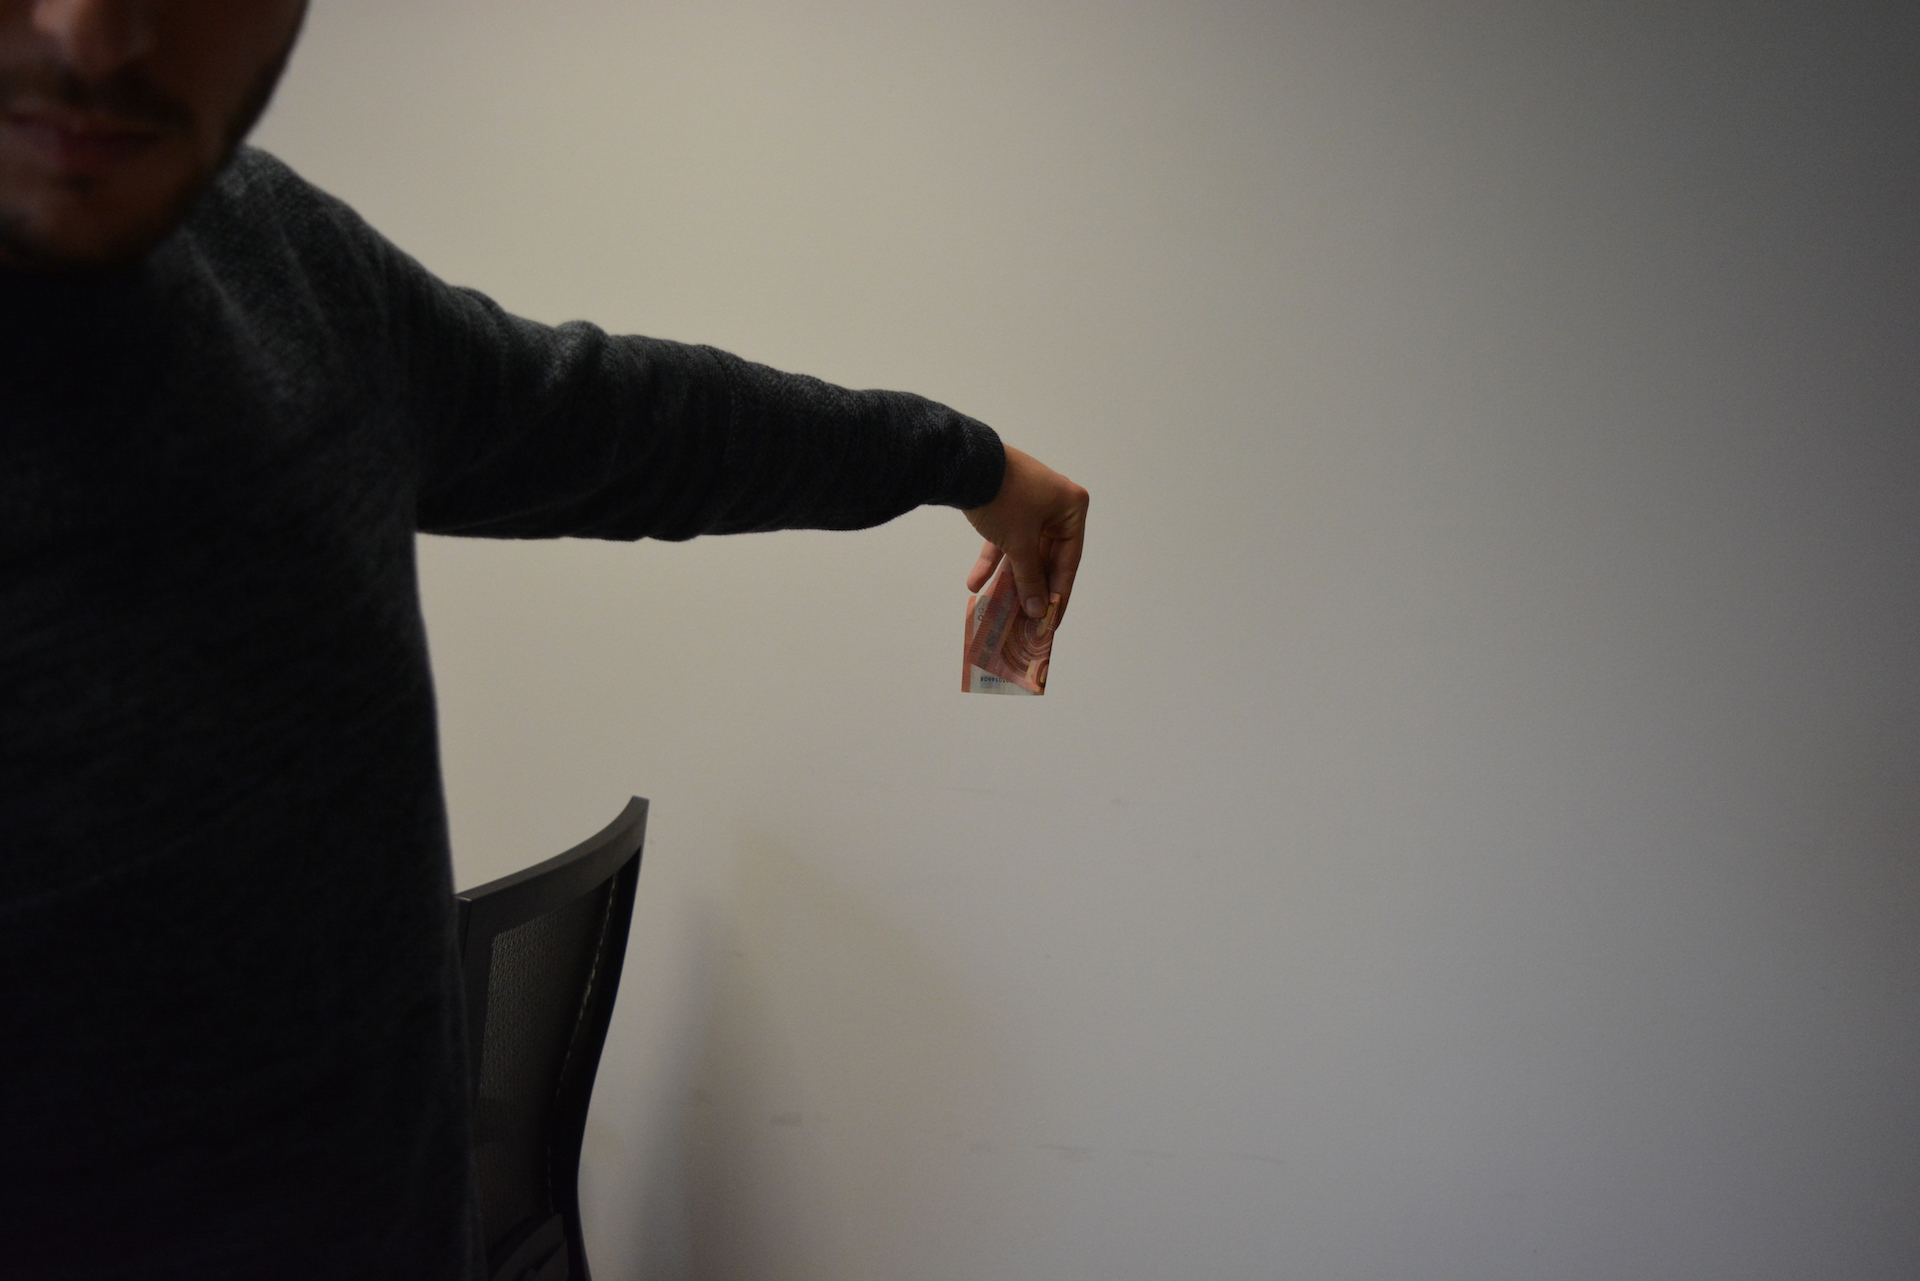

In [5]:
images[0]

### XML Coco convertion

In this section we convert the XML annotations into the COCO Json Format as we did for the DetrRes50 aswell.

#### Create Coco test annotation

In [9]:
# Directory containing your images
image_directory = "data/Sohas_weapon-Detection/test/images"
xml_directory = "data/Sohas_weapon-Detection/test/annotation"

In [10]:
import os
from xml.etree import ElementTree as ET
def extract_category_mapping(xml_directory):
  """Extracts unique object names (categories) from all XML files in a directory and maps them to consecutive integers.

  Args:
      xml_directory: Path to the directory containing the XML annotation files.

  Returns:
      A dictionary mapping unique object names (categories) to consecutive integers starting from 1.
  """
  category_mapping = {}
  category_id = 1
  for filename in tqdm(os.listdir(xml_directory)):
    if filename.endswith(".xml"):
      xml_path = os.path.join(xml_directory, filename)
      tree = ET.parse(xml_path)
      root = tree.getroot()

      for obj in root.findall('object'):
        category_name = obj.find('name').text
        if category_name not in category_mapping:
          category_mapping[category_name] = category_id
          category_id += 1

  return category_mapping

In [11]:
category_mapping = extract_category_mapping(xml_directory)

print(f"Category mapping: {category_mapping}")

100%|██████████| 866/866 [06:33<00:00,  2.20it/s]

Category mapping: {'smartphone': 1, 'knife': 2, 'billete': 3, 'monedero': 4, 'pistol': 5, 'tarjeta': 6}


In [16]:
import os
from xml.etree import ElementTree as ET
from collections import Counter


def convert_to_coco(xml_directory, category_mapping, output_filename="coco_annotations.json"):
  """Converts XML annotation files in a directory to COCO format and saves it to a JSON file.

  Args:
      xml_directory: Path to the directory containing the XML annotation files.
      category_mapping: Dictionary mapping unique object names (categories) to their corresponding COCO category IDs.
      output_filename: Filename for the output COCO annotations JSON file (default: "coco_annotations.json").
  """
  coco_annotations = {"images": [], "annotations": []}
  image_id = 1  # Counter for image IDs

  xml_files = sorted(os.listdir(xml_directory))

  for filename in tqdm(xml_files):
    if filename.endswith(".xml"):
      xml_path = os.path.join(xml_directory, filename)
      image_filename = os.path.splitext(filename)[0] + ".jpg"  # Extract filename without extension

      # Print debug information
      print(f"Processing image: {filename}")
      #print(f"Expected image filename: {image_filename}")

      tree = ET.parse(xml_path)
      root = tree.getroot()

      annotations = []
      for obj in root.findall('object'):
        name = obj.find('name').text
        category_id = category_mapping.get(name)
        if category_id is None:
          print(f"Warning: Category '{name}' not found in mapping. Skipping object.")
          continue

        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        width = xmax - xmin
        height = ymax - ymin
        area = width * height

        annotation = {
            "image_id": image_id,
            "file_name": image_filename,
            "id": len(coco_annotations["annotations"]) + 1,  # Unique ID for each annotation (incrementing counter)
            "category_id": category_id,
            "name": name,
            "bbox": [xmin, ymin, width, height],
            "area": area
        }
        annotations.append(annotation)

      # Add image information
      coco_annotations["images"].append({
            "image_id": image_id,
            "file_name": image_filename
      })

      # Add annotations for this image
      coco_annotations["annotations"].append(annotations)
      #coco_annotations["annotations"] = annotations
      #print(coco_annotations)
      image_id += 1

  # Save COCO annotations to JSON file
  with open(output_filename, "w") as f:
    json.dump(coco_annotations, f)
  print("Successfully written annotation json file")
  return coco_annotations


In [17]:
# Example usage (assuming you have the category_mapping dictionary)
coco_annotations = convert_to_coco(xml_directory, category_mapping, "data/Sohas_weapon-Detection/test/coco_annotations.json")

  0%|          | 0/866 [00:00<?, ?it/s]

Processing image: ABbframe00145.xml
Processing image: ABbframe00289.xml
Processing image: ABbframe00322.xml
Processing image: ABbframe00325.xml
Processing image: ABbframe00331.xml
Processing image: ABmframe00154.xml
Processing image: ABmframe00262.xml
Processing image: ABmframe00280.xml
Processing image: ABmframe00334.xml
Processing image: ABmframe00346.xml
Processing image: ABsframe00010.xml
Processing image: ABsframe00121.xml
Processing image: ABsframe00157.xml
Processing image: ABsframe00193.xml
Processing image: ABsframe00196.xml
Processing image: ABsframe00208.xml
Processing image: DSC_00021.xml
Processing image: DSC_0010.xml
Processing image: DSC_00131.xml
Processing image: DSC_00321.xml
Processing image: DSC_00361.xml
Processing image: DSC_00591.xml
Processing image: DSC_0069.xml
Processing image: DefenseAndSurvive14.xml
Processing image: DefenseKnifeAttack0103.xml
Processing image: DefenseKnifeAttack0155.xml
Processing image: DefenseKnifeAttack0163.xml
Processing image: Defense

 14%|█▍        | 123/866 [00:00<00:04, 177.80it/s]

Processing image: KravMagaTraining20823.xml
Processing image: KravMagaTraining20890.xml
Processing image: KravMagaTraining21067.xml
Processing image: KravMagaTraining21071.xml
Processing image: KravMagaTraining21140.xml
Processing image: KravMagaTraining21167.xml
Processing image: KravMagaTraining21168.xml
Processing image: KravMagaTraining21321.xml
Processing image: KravMagaTraining226.xml
Processing image: KravMagaTraining263.xml
Processing image: KravMagaTraining319.xml
Processing image: KravMagaTraining351.xml
Processing image: KravMagaTraining4034.xml
Processing image: KravMagaTraining4035.xml
Processing image: KravMagaTraining4045.xml
Processing image: KravMagaTraining4280.xml
Processing image: KravMagaTraining4400.xml
Processing image: KravMagaTraining4402.xml


 16%|█▋        | 141/866 [00:08<00:59, 12.27it/s] 

Processing image: KravMagaTraining4593.xml
Processing image: KravMagaTraining467.xml
Processing image: KravMagaTraining498.xml
Processing image: KravMagaTraining547.xml
Processing image: KravMagaTraining565.xml
Processing image: KravMagaTraining595.xml
Processing image: KravMagaTraining614.xml
Processing image: KravMagaTraining709.xml


 17%|█▋        | 149/866 [00:12<01:22,  8.67it/s]

Processing image: KravMagaTraining720.xml
Processing image: KravMagaTraining743.xml
Processing image: LBbframe00142.xml
Processing image: LBbframe00151.xml
Processing image: LBbframe00289.xml


 18%|█▊        | 154/866 [00:14<01:39,  7.16it/s]

Processing image: LBmframe00160.xml
Processing image: LBmframe00244.xml
Processing image: LBsframe00298.xml


 18%|█▊        | 157/866 [00:15<01:51,  6.33it/s]

Processing image: LBsframe00304.xml
Processing image: LBsframe00316.xml


 18%|█▊        | 159/866 [00:16<02:01,  5.80it/s]

Processing image: LBsframe00361.xml
Processing image: MBbframe00139.xml


 19%|█▊        | 161/866 [00:17<02:16,  5.15it/s]

Processing image: MBbframe00244.xml


 19%|█▊        | 162/866 [00:17<02:26,  4.81it/s]

Processing image: MBbframe00325.xml


 19%|█▉        | 163/866 [00:18<02:37,  4.47it/s]

Processing image: MBbframe00388.xml


 19%|█▉        | 164/866 [00:18<02:53,  4.05it/s]

Processing image: MBmframe00130.xml


 19%|█▉        | 165/866 [00:18<03:08,  3.73it/s]

Processing image: MBmframe00211.xml


 19%|█▉        | 166/866 [00:19<03:24,  3.42it/s]

Processing image: MBmframe00241.xml


 19%|█▉        | 167/866 [00:19<03:36,  3.22it/s]

Processing image: MBmframe00316.xml


 19%|█▉        | 168/866 [00:20<03:44,  3.11it/s]

Processing image: MBsframe00154.xml


 20%|█▉        | 169/866 [00:20<03:54,  2.97it/s]

Processing image: MBsframe00181.xml


 20%|█▉        | 170/866 [00:20<04:06,  2.83it/s]

Processing image: MBsframe00289.xml


 20%|█▉        | 171/866 [00:21<04:14,  2.73it/s]

Processing image: MBsframe00334.xml


 20%|█▉        | 172/866 [00:21<04:21,  2.66it/s]

Processing image: MBsframe00352.xml


 20%|█▉        | 173/866 [00:22<04:31,  2.56it/s]

Processing image: MBsframe00439.xml


 20%|██        | 174/866 [00:22<04:42,  2.45it/s]

Processing image: RealityKnifeAttacks0651.xml


 20%|██        | 175/866 [00:23<04:59,  2.31it/s]

Processing image: RusoClases005.xml


 20%|██        | 176/866 [00:23<04:47,  2.40it/s]

Processing image: RusoClases262.xml


 20%|██        | 177/866 [00:23<04:47,  2.40it/s]

Processing image: RusoClases307.xml


 21%|██        | 178/866 [00:24<04:46,  2.40it/s]

Processing image: RusoClases418.xml


 21%|██        | 179/866 [00:24<04:45,  2.41it/s]

Processing image: RusoClases463.xml


 21%|██        | 180/866 [00:25<04:44,  2.42it/s]

Processing image: billete_0102.xml


 21%|██        | 181/866 [00:25<04:46,  2.39it/s]

Processing image: billete_0104.xml


 21%|██        | 182/866 [00:26<04:58,  2.29it/s]

Processing image: billete_0106.xml


 21%|██        | 183/866 [00:26<05:00,  2.28it/s]

Processing image: billete_0113.xml


 21%|██        | 184/866 [00:26<04:50,  2.35it/s]

Processing image: billete_0142.xml


 21%|██▏       | 185/866 [00:27<05:01,  2.26it/s]

Processing image: billete_0149.xml


 21%|██▏       | 186/866 [00:27<05:01,  2.26it/s]

Processing image: billete_0151.xml


 22%|██▏       | 187/866 [00:28<04:57,  2.28it/s]

Processing image: billete_0154.xml


 22%|██▏       | 188/866 [00:28<04:51,  2.33it/s]

Processing image: billete_0156.xml


 22%|██▏       | 189/866 [00:29<04:47,  2.36it/s]

Processing image: billete_0157.xml


 22%|██▏       | 190/866 [00:29<04:48,  2.34it/s]

Processing image: billete_0158.xml


 22%|██▏       | 191/866 [00:29<04:45,  2.36it/s]

Processing image: billete_2190.xml


 22%|██▏       | 192/866 [00:30<04:46,  2.35it/s]

Processing image: billete_2191.xml


 22%|██▏       | 193/866 [00:30<04:53,  2.29it/s]

Processing image: billete_2192.xml


 22%|██▏       | 194/866 [00:31<04:43,  2.37it/s]

Processing image: billete_2193.xml


 23%|██▎       | 195/866 [00:31<04:42,  2.38it/s]

Processing image: billete_2194.xml


 23%|██▎       | 196/866 [00:32<04:34,  2.44it/s]

Processing image: billete_2198.xml


 23%|██▎       | 197/866 [00:32<04:34,  2.44it/s]

Processing image: billete_2203.xml


 23%|██▎       | 198/866 [00:32<04:35,  2.42it/s]

Processing image: billete_2204.xml


 23%|██▎       | 199/866 [00:33<04:35,  2.42it/s]

Processing image: billete_2205.xml


 23%|██▎       | 200/866 [00:33<04:36,  2.41it/s]

Processing image: billete_2207.xml


 23%|██▎       | 201/866 [00:34<04:32,  2.44it/s]

Processing image: billete_2208.xml


 23%|██▎       | 202/866 [00:34<04:31,  2.45it/s]

Processing image: billete_2209.xml


 23%|██▎       | 203/866 [00:34<04:20,  2.54it/s]

Processing image: billete_2210.xml


 24%|██▎       | 204/866 [00:35<04:17,  2.57it/s]

Processing image: billete_2211.xml


 24%|██▎       | 205/866 [00:35<04:30,  2.44it/s]

Processing image: billete_2213.xml


 24%|██▍       | 206/866 [00:36<04:24,  2.49it/s]

Processing image: billete_2217.xml


 24%|██▍       | 207/866 [00:36<04:29,  2.44it/s]

Processing image: billete_2219.xml


 24%|██▍       | 208/866 [00:36<04:41,  2.34it/s]

Processing image: billete_2221.xml


 24%|██▍       | 209/866 [00:37<04:36,  2.38it/s]

Processing image: billete_2224.xml


 24%|██▍       | 210/866 [00:37<04:36,  2.37it/s]

Processing image: billete_2229.xml


 24%|██▍       | 211/866 [00:38<04:36,  2.37it/s]

Processing image: billete_2231.xml


 24%|██▍       | 212/866 [00:38<04:29,  2.43it/s]

Processing image: billete_2233.xml


 25%|██▍       | 213/866 [00:39<04:34,  2.38it/s]

Processing image: billete_2349.xml


 25%|██▍       | 214/866 [00:39<04:35,  2.37it/s]

Processing image: billete_2350.xml


 25%|██▍       | 215/866 [00:39<04:45,  2.28it/s]

Processing image: billete_2352.xml


 25%|██▍       | 216/866 [00:40<04:33,  2.38it/s]

Processing image: billete_2355.xml


 25%|██▌       | 217/866 [00:40<04:28,  2.41it/s]

Processing image: billete_2356.xml


 25%|██▌       | 218/866 [00:41<04:26,  2.43it/s]

Processing image: billete_2357.xml


 25%|██▌       | 219/866 [00:41<04:32,  2.38it/s]

Processing image: billete_2358.xml


 25%|██▌       | 220/866 [00:42<04:32,  2.37it/s]

Processing image: billete_2359.xml


 26%|██▌       | 221/866 [00:42<04:24,  2.44it/s]

Processing image: billete_2360.xml


 26%|██▌       | 222/866 [00:42<04:24,  2.43it/s]

Processing image: billete_2361.xml


 26%|██▌       | 223/866 [00:43<04:31,  2.37it/s]

Processing image: billete_2372.xml


 26%|██▌       | 224/866 [00:43<04:25,  2.42it/s]

Processing image: billete_2373.xml


 26%|██▌       | 225/866 [00:44<04:38,  2.30it/s]

Processing image: img1102.xml


 26%|██▌       | 226/866 [00:44<04:28,  2.38it/s]

Processing image: img1139.xml


 26%|██▌       | 227/866 [00:44<04:23,  2.42it/s]

Processing image: img1241.xml


 26%|██▋       | 228/866 [00:45<04:29,  2.37it/s]

Processing image: img1261.xml


 26%|██▋       | 229/866 [00:45<04:23,  2.42it/s]

Processing image: img1273.xml


 27%|██▋       | 230/866 [00:46<04:17,  2.47it/s]

Processing image: img1296.xml


 27%|██▋       | 231/866 [00:46<04:13,  2.51it/s]

Processing image: img1302.xml


 27%|██▋       | 232/866 [00:46<04:13,  2.50it/s]

Processing image: img1364.xml


 27%|██▋       | 233/866 [00:47<04:25,  2.38it/s]

Processing image: img1463.xml


 27%|██▋       | 234/866 [00:47<04:18,  2.44it/s]

Processing image: img1475.xml


 27%|██▋       | 235/866 [00:48<04:19,  2.44it/s]

Processing image: img1490.xml


 27%|██▋       | 236/866 [00:48<04:34,  2.30it/s]

Processing image: img1542.xml


 27%|██▋       | 237/866 [00:49<04:33,  2.30it/s]

Processing image: img1558.xml


 27%|██▋       | 238/866 [00:49<04:28,  2.34it/s]

Processing image: img1590.xml


 28%|██▊       | 239/866 [00:49<04:17,  2.43it/s]

Processing image: img1616.xml


 28%|██▊       | 240/866 [00:50<04:19,  2.41it/s]

Processing image: img1625.xml


 28%|██▊       | 241/866 [00:50<04:23,  2.37it/s]

Processing image: img1641.xml


 28%|██▊       | 242/866 [00:51<04:22,  2.38it/s]

Processing image: img1652.xml


 28%|██▊       | 243/866 [00:51<04:27,  2.33it/s]

Processing image: img1690.xml


 28%|██▊       | 244/866 [00:52<04:43,  2.19it/s]

Processing image: img1728.xml


 28%|██▊       | 245/866 [00:52<04:28,  2.31it/s]

Processing image: img1733.xml


 28%|██▊       | 246/866 [00:52<04:36,  2.24it/s]

Processing image: img1733v2.xml


 29%|██▊       | 247/866 [00:53<04:33,  2.26it/s]

Processing image: img1749.xml


 29%|██▊       | 248/866 [00:53<04:19,  2.38it/s]

Processing image: img1773.xml


 29%|██▉       | 249/866 [00:54<04:12,  2.44it/s]

Processing image: img1831.xml


 29%|██▉       | 250/866 [00:54<04:11,  2.45it/s]

Processing image: img1857.xml


 29%|██▉       | 251/866 [00:55<04:23,  2.34it/s]

Processing image: img1887.xml


 29%|██▉       | 252/866 [00:55<04:13,  2.42it/s]

Processing image: img1900.xml


 29%|██▉       | 253/866 [00:55<04:19,  2.36it/s]

Processing image: img1980.xml


 29%|██▉       | 254/866 [00:56<04:10,  2.44it/s]

Processing image: img2005.xml


 29%|██▉       | 255/866 [00:56<04:21,  2.34it/s]

Processing image: img2050.xml


 30%|██▉       | 256/866 [00:57<04:21,  2.33it/s]

Processing image: img2051.xml


 30%|██▉       | 257/866 [00:57<04:24,  2.31it/s]

Processing image: img2105.xml


 30%|██▉       | 258/866 [00:58<04:21,  2.33it/s]

Processing image: img2127.xml


 30%|██▉       | 259/866 [00:58<04:09,  2.43it/s]

Processing image: img2167.xml


 30%|███       | 260/866 [00:58<04:07,  2.45it/s]

Processing image: img2233.xml


 30%|███       | 261/866 [00:59<04:12,  2.40it/s]

Processing image: img2294.xml


 30%|███       | 262/866 [00:59<04:04,  2.47it/s]

Processing image: img2367.xml


 30%|███       | 263/866 [00:59<03:56,  2.54it/s]

Processing image: img238.xml


 30%|███       | 264/866 [01:00<03:55,  2.56it/s]

Processing image: img2396.xml


 31%|███       | 265/866 [01:00<03:55,  2.55it/s]

Processing image: img2456.xml


 31%|███       | 266/866 [01:01<03:50,  2.60it/s]

Processing image: img2476.xml


 31%|███       | 267/866 [01:01<03:57,  2.52it/s]

Processing image: img2517.xml


 31%|███       | 268/866 [01:02<04:26,  2.24it/s]

Processing image: img2728.xml


 31%|███       | 269/866 [01:02<04:17,  2.32it/s]

Processing image: img279.xml


 31%|███       | 270/866 [01:02<04:06,  2.41it/s]

Processing image: img2862.xml


 31%|███▏      | 271/866 [01:03<04:00,  2.47it/s]

Processing image: img2875.xml


 31%|███▏      | 272/866 [01:03<03:53,  2.54it/s]

Processing image: img2876.xml


 32%|███▏      | 273/866 [01:04<03:51,  2.56it/s]

Processing image: img2890.xml


 32%|███▏      | 274/866 [01:04<03:49,  2.58it/s]

Processing image: img2904.xml


 32%|███▏      | 275/866 [01:04<03:57,  2.49it/s]

Processing image: img2983.xml


 32%|███▏      | 276/866 [01:05<04:04,  2.42it/s]

Processing image: img3033.xml


 32%|███▏      | 277/866 [01:05<04:07,  2.38it/s]

Processing image: img3094.xml


 32%|███▏      | 278/866 [01:06<04:02,  2.42it/s]

Processing image: img3115.xml


 32%|███▏      | 279/866 [01:06<04:14,  2.31it/s]

Processing image: img3218.xml


 32%|███▏      | 280/866 [01:06<04:07,  2.37it/s]

Processing image: img3244.xml


 32%|███▏      | 281/866 [01:07<04:00,  2.43it/s]

Processing image: img3262.xml


 33%|███▎      | 282/866 [01:07<04:02,  2.41it/s]

Processing image: img3378.xml


 33%|███▎      | 283/866 [01:08<04:00,  2.43it/s]

Processing image: img3436.xml


 33%|███▎      | 284/866 [01:08<03:54,  2.48it/s]

Processing image: img3571.xml


 33%|███▎      | 285/866 [01:08<03:54,  2.48it/s]

Processing image: img3593.xml


 33%|███▎      | 286/866 [01:09<03:48,  2.54it/s]

Processing image: img36.xml


 33%|███▎      | 287/866 [01:09<03:47,  2.55it/s]

Processing image: img3640.xml


 33%|███▎      | 288/866 [01:10<04:08,  2.32it/s]

Processing image: img3659.xml


 33%|███▎      | 289/866 [01:10<03:54,  2.46it/s]

Processing image: img3711.xml


 33%|███▎      | 290/866 [01:11<03:58,  2.41it/s]

Processing image: img3748.xml


 34%|███▎      | 291/866 [01:11<03:50,  2.49it/s]

Processing image: img3783.xml


 34%|███▎      | 292/866 [01:11<04:00,  2.39it/s]

Processing image: img381.xml


 34%|███▍      | 293/866 [01:12<04:00,  2.38it/s]

Processing image: img3820.xml


 34%|███▍      | 294/866 [01:12<04:04,  2.34it/s]

Processing image: img3844.xml


 34%|███▍      | 295/866 [01:13<03:57,  2.41it/s]

Processing image: img388.xml


 34%|███▍      | 296/866 [01:13<03:55,  2.42it/s]

Processing image: img3884.xml


 34%|███▍      | 297/866 [01:13<03:48,  2.49it/s]

Processing image: img3921.xml


 34%|███▍      | 298/866 [01:14<03:57,  2.39it/s]

Processing image: img3948.xml


 35%|███▍      | 299/866 [01:14<03:52,  2.44it/s]

Processing image: img4004.xml


 35%|███▍      | 300/866 [01:15<03:52,  2.43it/s]

Processing image: img4032.xml


 35%|███▍      | 301/866 [01:15<03:47,  2.48it/s]

Processing image: img409.xml


 35%|███▍      | 302/866 [01:15<03:46,  2.49it/s]

Processing image: img4113.xml


 35%|███▍      | 303/866 [01:16<03:42,  2.53it/s]

Processing image: img4157.xml


 35%|███▌      | 304/866 [01:16<03:42,  2.52it/s]

Processing image: img4232.xml


 35%|███▌      | 305/866 [01:17<03:42,  2.52it/s]

Processing image: img4270.xml


 35%|███▌      | 306/866 [01:17<04:16,  2.19it/s]

Processing image: img4333.xml


 35%|███▌      | 307/866 [01:18<04:04,  2.29it/s]

Processing image: img452.xml


 36%|███▌      | 308/866 [01:18<03:56,  2.36it/s]

Processing image: img470.xml


 36%|███▌      | 309/866 [01:18<03:59,  2.33it/s]

Processing image: img4809.xml


 36%|███▌      | 310/866 [01:19<03:51,  2.40it/s]

Processing image: img483.xml


 36%|███▌      | 311/866 [01:19<03:43,  2.49it/s]

Processing image: img4864.xml


 36%|███▌      | 312/866 [01:20<03:38,  2.54it/s]

Processing image: img498.xml


 36%|███▌      | 313/866 [01:20<03:40,  2.51it/s]

Processing image: img498v2.xml


 36%|███▋      | 314/866 [01:20<03:48,  2.41it/s]

Processing image: img5050.xml


 36%|███▋      | 315/866 [01:21<03:59,  2.30it/s]

Processing image: img510.xml


 36%|███▋      | 316/866 [01:21<03:58,  2.31it/s]

Processing image: img530.xml


 37%|███▋      | 317/866 [01:22<03:48,  2.41it/s]

Processing image: img533.xml


 37%|███▋      | 318/866 [01:22<03:43,  2.45it/s]

Processing image: img5353.xml


 37%|███▋      | 319/866 [01:23<03:42,  2.46it/s]

Processing image: img5449.xml


 37%|███▋      | 320/866 [01:23<03:51,  2.36it/s]

Processing image: img545.xml


 37%|███▋      | 321/866 [01:23<03:46,  2.41it/s]

Processing image: img5887.xml


 37%|███▋      | 322/866 [01:24<03:54,  2.32it/s]

Processing image: img5915.xml


 37%|███▋      | 323/866 [01:24<03:43,  2.43it/s]

Processing image: img6000.xml


 37%|███▋      | 324/866 [01:25<03:46,  2.39it/s]

Processing image: img601.xml


 38%|███▊      | 325/866 [01:25<03:46,  2.39it/s]

Processing image: img616.xml


 38%|███▊      | 326/866 [01:25<03:43,  2.42it/s]

Processing image: img6251.xml


 38%|███▊      | 327/866 [01:26<03:38,  2.47it/s]

Processing image: img6303.xml


 38%|███▊      | 328/866 [01:26<03:46,  2.37it/s]

Processing image: img6368.xml


 38%|███▊      | 329/866 [01:27<03:37,  2.47it/s]

Processing image: img641.xml


 38%|███▊      | 330/866 [01:27<03:32,  2.52it/s]

Processing image: img6452.xml


 38%|███▊      | 331/866 [01:27<03:30,  2.55it/s]

Processing image: img65.xml


 38%|███▊      | 332/866 [01:28<03:33,  2.50it/s]

Processing image: img6501.xml


 38%|███▊      | 333/866 [01:28<03:34,  2.49it/s]

Processing image: img651.xml


 39%|███▊      | 334/866 [01:29<03:29,  2.54it/s]

Processing image: img653.xml


 39%|███▊      | 335/866 [01:29<03:30,  2.52it/s]

Processing image: img6585.xml


 39%|███▉      | 336/866 [01:29<03:28,  2.55it/s]

Processing image: img6653.xml


 39%|███▉      | 337/866 [01:30<03:25,  2.58it/s]

Processing image: img6732.xml


 39%|███▉      | 338/866 [01:30<03:22,  2.60it/s]

Processing image: img6874.xml


 39%|███▉      | 339/866 [01:31<03:20,  2.63it/s]

Processing image: img701.xml


 39%|███▉      | 340/866 [01:31<03:27,  2.53it/s]

Processing image: img7197.xml


 39%|███▉      | 341/866 [01:31<03:41,  2.37it/s]

Processing image: img7322.xml


 39%|███▉      | 342/866 [01:32<03:45,  2.33it/s]

Processing image: img7356.xml


 40%|███▉      | 343/866 [01:32<03:37,  2.41it/s]

Processing image: img7532.xml


 40%|███▉      | 344/866 [01:33<03:33,  2.45it/s]

Processing image: img759.xml


 40%|███▉      | 345/866 [01:33<03:29,  2.49it/s]

Processing image: img7665.xml


 40%|███▉      | 346/866 [01:34<03:31,  2.46it/s]

Processing image: img772.xml


 40%|████      | 347/866 [01:34<03:28,  2.49it/s]

Processing image: img7773.xml


 40%|████      | 348/866 [01:34<03:33,  2.42it/s]

Processing image: img815.xml


 40%|████      | 349/866 [01:35<03:32,  2.43it/s]

Processing image: img859.xml


 40%|████      | 350/866 [01:35<04:00,  2.14it/s]

Processing image: img931.xml


 41%|████      | 351/866 [01:36<03:57,  2.17it/s]

Processing image: knifeDefenseTechnique070.xml


 41%|████      | 352/866 [01:36<03:49,  2.24it/s]

Processing image: knifeDefenseTechnique116.xml


 41%|████      | 353/866 [01:37<03:48,  2.25it/s]

Processing image: knife_1000.xml


 41%|████      | 354/866 [01:37<03:42,  2.31it/s]

Processing image: knife_1011.xml


 41%|████      | 355/866 [01:37<03:35,  2.37it/s]

Processing image: knife_1012.xml


 41%|████      | 356/866 [01:38<03:34,  2.38it/s]

Processing image: knife_1016.xml


 41%|████      | 357/866 [01:38<03:29,  2.43it/s]

Processing image: knife_1019.xml


 41%|████▏     | 358/866 [01:39<03:29,  2.43it/s]

Processing image: knife_102.xml


 41%|████▏     | 359/866 [01:39<03:30,  2.41it/s]

Processing image: knife_103.xml


 42%|████▏     | 360/866 [01:40<03:30,  2.40it/s]

Processing image: knife_1030.xml


 42%|████▏     | 361/866 [01:40<03:37,  2.33it/s]

Processing image: knife_1037.xml


 42%|████▏     | 362/866 [01:40<03:37,  2.32it/s]

Processing image: knife_1041.xml


 42%|████▏     | 363/866 [01:41<03:35,  2.34it/s]

Processing image: knife_1043.xml


 42%|████▏     | 364/866 [01:41<03:30,  2.39it/s]

Processing image: knife_1045.xml


 42%|████▏     | 365/866 [01:42<03:34,  2.34it/s]

Processing image: knife_1051.xml


 42%|████▏     | 366/866 [01:42<03:32,  2.35it/s]

Processing image: knife_1054.xml


 42%|████▏     | 367/866 [01:43<03:37,  2.30it/s]

Processing image: knife_1060.xml


 42%|████▏     | 368/866 [01:43<03:28,  2.39it/s]

Processing image: knife_1063.xml


 43%|████▎     | 369/866 [01:43<03:25,  2.42it/s]

Processing image: knife_1067.xml


 43%|████▎     | 370/866 [01:44<03:20,  2.48it/s]

Processing image: knife_1073.xml


 43%|████▎     | 371/866 [01:44<03:18,  2.49it/s]

Processing image: knife_1084.xml


 43%|████▎     | 372/866 [01:45<03:22,  2.44it/s]

Processing image: knife_1085.xml


 43%|████▎     | 373/866 [01:45<03:21,  2.45it/s]

Processing image: knife_1087.xml


 43%|████▎     | 374/866 [01:45<03:19,  2.46it/s]

Processing image: knife_1088.xml


 43%|████▎     | 375/866 [01:46<03:21,  2.43it/s]

Processing image: knife_1092.xml


 43%|████▎     | 376/866 [01:46<03:20,  2.44it/s]

Processing image: knife_1093.xml


 44%|████▎     | 377/866 [01:47<03:32,  2.30it/s]

Processing image: knife_1098.xml


 44%|████▎     | 378/866 [01:47<03:28,  2.34it/s]

Processing image: knife_110.xml


 44%|████▍     | 379/866 [01:47<03:22,  2.41it/s]

Processing image: knife_1101.xml


 44%|████▍     | 380/866 [01:48<03:17,  2.46it/s]

Processing image: knife_1102.xml


 44%|████▍     | 381/866 [01:48<03:11,  2.53it/s]

Processing image: knife_111.xml


 44%|████▍     | 382/866 [01:49<03:11,  2.53it/s]

Processing image: knife_1116.xml


 44%|████▍     | 383/866 [01:49<03:14,  2.48it/s]

Processing image: knife_1117.xml


 44%|████▍     | 384/866 [01:49<03:21,  2.39it/s]

Processing image: knife_1122.xml


 44%|████▍     | 385/866 [01:50<03:22,  2.38it/s]

Processing image: knife_1127.xml


 45%|████▍     | 386/866 [01:50<03:16,  2.45it/s]

Processing image: knife_113.xml


 45%|████▍     | 387/866 [01:51<03:44,  2.13it/s]

Processing image: knife_1136.xml


 45%|████▍     | 388/866 [01:51<03:31,  2.26it/s]

Processing image: knife_1137.xml


 45%|████▍     | 389/866 [01:52<03:28,  2.29it/s]

Processing image: knife_1144.xml


 45%|████▌     | 390/866 [01:52<03:24,  2.33it/s]

Processing image: knife_115.xml


 45%|████▌     | 391/866 [01:52<03:15,  2.43it/s]

Processing image: knife_1153.xml


 45%|████▌     | 392/866 [01:53<03:11,  2.48it/s]

Processing image: knife_1157.xml


 45%|████▌     | 393/866 [01:53<03:05,  2.55it/s]

Processing image: knife_1164.xml


 45%|████▌     | 394/866 [01:54<03:02,  2.59it/s]

Processing image: knife_1166.xml


 46%|████▌     | 395/866 [01:54<03:03,  2.57it/s]

Processing image: knife_1168.xml


 46%|████▌     | 396/866 [01:54<03:02,  2.57it/s]

Processing image: knife_1171.xml


 46%|████▌     | 397/866 [01:55<03:03,  2.56it/s]

Processing image: knife_1173.xml


 46%|████▌     | 398/866 [01:55<02:59,  2.61it/s]

Processing image: knife_1186.xml


 46%|████▌     | 399/866 [01:56<02:57,  2.63it/s]

Processing image: knife_1190.xml


 46%|████▌     | 400/866 [01:56<03:07,  2.48it/s]

Processing image: knife_1209.xml


 46%|████▋     | 401/866 [01:56<03:04,  2.53it/s]

Processing image: knife_1212.xml


 46%|████▋     | 402/866 [01:57<02:58,  2.59it/s]

Processing image: knife_1214.xml


 47%|████▋     | 403/866 [01:57<02:59,  2.58it/s]

Processing image: knife_1215.xml


 47%|████▋     | 404/866 [01:57<02:55,  2.63it/s]

Processing image: knife_1218.xml


 47%|████▋     | 405/866 [01:58<02:58,  2.58it/s]

Processing image: knife_123.xml


 47%|████▋     | 406/866 [01:58<02:58,  2.58it/s]

Processing image: knife_1236.xml


 47%|████▋     | 407/866 [01:59<03:04,  2.49it/s]

Processing image: knife_1237.xml


 47%|████▋     | 408/866 [01:59<03:04,  2.48it/s]

Processing image: knife_1239.xml


 47%|████▋     | 409/866 [02:00<03:05,  2.47it/s]

Processing image: knife_1242.xml


 47%|████▋     | 410/866 [02:00<03:01,  2.51it/s]

Processing image: knife_1253.xml


 47%|████▋     | 411/866 [02:00<03:06,  2.45it/s]

Processing image: knife_1258.xml


 48%|████▊     | 412/866 [02:01<03:04,  2.46it/s]

Processing image: knife_1261.xml


 48%|████▊     | 413/866 [02:01<03:11,  2.37it/s]

Processing image: knife_1268.xml


 48%|████▊     | 414/866 [02:02<03:11,  2.36it/s]

Processing image: knife_1270.xml


 48%|████▊     | 415/866 [02:02<03:15,  2.31it/s]

Processing image: knife_1272.xml


 48%|████▊     | 416/866 [02:03<03:19,  2.26it/s]

Processing image: knife_1286.xml


 48%|████▊     | 417/866 [02:03<03:16,  2.29it/s]

Processing image: knife_1287.xml


 48%|████▊     | 418/866 [02:03<03:09,  2.37it/s]

Processing image: knife_1288.xml


 48%|████▊     | 419/866 [02:04<03:08,  2.37it/s]

Processing image: knife_1289.xml


 48%|████▊     | 420/866 [02:04<03:10,  2.35it/s]

Processing image: knife_1293.xml


 49%|████▊     | 421/866 [02:05<03:09,  2.35it/s]

Processing image: knife_1297.xml


 49%|████▊     | 422/866 [02:05<03:06,  2.38it/s]

Processing image: knife_1298.xml


 49%|████▉     | 423/866 [02:05<03:02,  2.43it/s]

Processing image: knife_13.xml


 49%|████▉     | 424/866 [02:06<03:00,  2.45it/s]

Processing image: knife_130.xml


 49%|████▉     | 425/866 [02:06<03:05,  2.38it/s]

Processing image: knife_1308.xml


 49%|████▉     | 426/866 [02:07<02:58,  2.46it/s]

Processing image: knife_1314.xml


 49%|████▉     | 427/866 [02:07<03:00,  2.43it/s]

Processing image: knife_1315.xml


 49%|████▉     | 428/866 [02:07<02:57,  2.47it/s]

Processing image: knife_1318.xml


 50%|████▉     | 429/866 [02:08<02:54,  2.50it/s]

Processing image: knife_132.xml


 50%|████▉     | 430/866 [02:08<02:54,  2.49it/s]

Processing image: knife_1323.xml


 50%|████▉     | 431/866 [02:09<02:59,  2.42it/s]

Processing image: knife_1332.xml


 50%|████▉     | 432/866 [02:09<02:57,  2.45it/s]

Processing image: knife_1333.xml


 50%|█████     | 433/866 [02:09<02:54,  2.48it/s]

Processing image: knife_1341.xml


 50%|█████     | 434/866 [02:10<02:57,  2.43it/s]

Processing image: knife_1345.xml


 50%|█████     | 435/866 [02:10<02:58,  2.42it/s]

Processing image: knife_135.xml


 50%|█████     | 436/866 [02:11<02:57,  2.42it/s]

Processing image: knife_138.xml


 50%|█████     | 437/866 [02:11<02:54,  2.46it/s]

Processing image: knife_139.xml


 51%|█████     | 438/866 [02:12<02:55,  2.44it/s]

Processing image: knife_145.xml


 51%|█████     | 439/866 [02:12<02:59,  2.37it/s]

Processing image: knife_150.xml


 51%|█████     | 440/866 [02:12<02:54,  2.44it/s]

Processing image: knife_16.xml


 51%|█████     | 441/866 [02:13<02:51,  2.48it/s]

Processing image: knife_160.xml


 51%|█████     | 442/866 [02:13<03:00,  2.35it/s]

Processing image: knife_161.xml


 51%|█████     | 443/866 [02:14<03:12,  2.20it/s]

Processing image: knife_163.xml


 51%|█████▏    | 444/866 [02:14<03:10,  2.22it/s]

Processing image: knife_167.xml


 51%|█████▏    | 445/866 [02:15<02:59,  2.34it/s]

Processing image: knife_173.xml


 52%|█████▏    | 446/866 [02:15<02:52,  2.44it/s]

Processing image: knife_182.xml


 52%|█████▏    | 447/866 [02:15<02:51,  2.44it/s]

Processing image: knife_193.xml


 52%|█████▏    | 448/866 [02:16<02:50,  2.45it/s]

Processing image: knife_195.xml


 52%|█████▏    | 449/866 [02:16<02:51,  2.43it/s]

Processing image: knife_196.xml


 52%|█████▏    | 450/866 [02:17<02:45,  2.51it/s]

Processing image: knife_221.xml


 52%|█████▏    | 451/866 [02:17<02:42,  2.55it/s]

Processing image: knife_227.xml


 52%|█████▏    | 452/866 [02:17<02:45,  2.50it/s]

Processing image: knife_231.xml


 52%|█████▏    | 453/866 [02:18<02:47,  2.46it/s]

Processing image: knife_235.xml


 52%|█████▏    | 454/866 [02:18<02:45,  2.48it/s]

Processing image: knife_236.xml


 53%|█████▎    | 455/866 [02:19<02:43,  2.52it/s]

Processing image: knife_247.xml


 53%|█████▎    | 456/866 [02:19<02:44,  2.49it/s]

Processing image: knife_25.xml


 53%|█████▎    | 457/866 [02:19<02:44,  2.49it/s]

Processing image: knife_252.xml


 53%|█████▎    | 458/866 [02:20<02:41,  2.53it/s]

Processing image: knife_254.xml


 53%|█████▎    | 459/866 [02:20<02:43,  2.49it/s]

Processing image: knife_256.xml


 53%|█████▎    | 460/866 [02:21<02:42,  2.49it/s]

Processing image: knife_257.xml


 53%|█████▎    | 461/866 [02:21<02:44,  2.46it/s]

Processing image: knife_259.xml


 53%|█████▎    | 462/866 [02:21<02:45,  2.44it/s]

Processing image: knife_26.xml


 53%|█████▎    | 463/866 [02:22<02:42,  2.48it/s]

Processing image: knife_268.xml


 54%|█████▎    | 464/866 [02:22<02:39,  2.51it/s]

Processing image: knife_27.xml


 54%|█████▎    | 465/866 [02:23<02:41,  2.48it/s]

Processing image: knife_271.xml


 54%|█████▍    | 466/866 [02:23<02:38,  2.53it/s]

Processing image: knife_272.xml


 54%|█████▍    | 467/866 [02:23<02:50,  2.34it/s]

Processing image: knife_280.xml


 54%|█████▍    | 468/866 [02:24<02:45,  2.41it/s]

Processing image: knife_282.xml


 54%|█████▍    | 469/866 [02:24<02:39,  2.49it/s]

Processing image: knife_288.xml


 54%|█████▍    | 470/866 [02:25<02:37,  2.51it/s]

Processing image: knife_29.xml


 54%|█████▍    | 471/866 [02:25<02:41,  2.45it/s]

Processing image: knife_290.xml


 55%|█████▍    | 472/866 [02:25<02:41,  2.44it/s]

Processing image: knife_294.xml


 55%|█████▍    | 473/866 [02:26<02:41,  2.43it/s]

Processing image: knife_298.xml


 55%|█████▍    | 474/866 [02:26<02:38,  2.47it/s]

Processing image: knife_309.xml


 55%|█████▍    | 475/866 [02:27<02:36,  2.50it/s]

Processing image: knife_312.xml


 55%|█████▍    | 476/866 [02:27<02:35,  2.50it/s]

Processing image: knife_318.xml


 55%|█████▌    | 477/866 [02:27<02:31,  2.56it/s]

Processing image: knife_319.xml


 55%|█████▌    | 478/866 [02:28<02:29,  2.59it/s]

Processing image: knife_32.xml


 55%|█████▌    | 479/866 [02:28<02:29,  2.58it/s]

Processing image: knife_326.xml


 55%|█████▌    | 480/866 [02:29<02:30,  2.56it/s]

Processing image: knife_329.xml


 56%|█████▌    | 481/866 [02:29<02:32,  2.52it/s]

Processing image: knife_33.xml


 56%|█████▌    | 482/866 [02:29<02:30,  2.55it/s]

Processing image: knife_337.xml


 56%|█████▌    | 483/866 [02:30<02:29,  2.56it/s]

Processing image: knife_339.xml


 56%|█████▌    | 484/866 [02:30<02:27,  2.58it/s]

Processing image: knife_34.xml


 56%|█████▌    | 485/866 [02:31<02:36,  2.44it/s]

Processing image: knife_349.xml


 56%|█████▌    | 486/866 [02:31<02:34,  2.46it/s]

Processing image: knife_35.xml


 56%|█████▌    | 487/866 [02:31<02:34,  2.45it/s]

Processing image: knife_355.xml


 56%|█████▋    | 488/866 [02:32<02:33,  2.46it/s]

Processing image: knife_358.xml


 56%|█████▋    | 489/866 [02:32<02:33,  2.45it/s]

Processing image: knife_359.xml


 57%|█████▋    | 490/866 [02:33<02:38,  2.37it/s]

Processing image: knife_361.xml


 57%|█████▋    | 491/866 [02:33<02:38,  2.37it/s]

Processing image: knife_368.xml


 57%|█████▋    | 492/866 [02:34<02:34,  2.42it/s]

Processing image: knife_375.xml


 57%|█████▋    | 493/866 [02:34<02:42,  2.29it/s]

Processing image: knife_387.xml


 57%|█████▋    | 494/866 [02:34<02:46,  2.23it/s]

Processing image: knife_388.xml


 57%|█████▋    | 495/866 [02:35<02:41,  2.29it/s]

Processing image: knife_390.xml


 57%|█████▋    | 496/866 [02:35<02:36,  2.36it/s]

Processing image: knife_393.xml


 57%|█████▋    | 497/866 [02:36<02:35,  2.37it/s]

Processing image: knife_397.xml


 58%|█████▊    | 498/866 [02:36<02:30,  2.45it/s]

Processing image: knife_402.xml


 58%|█████▊    | 499/866 [02:36<02:29,  2.45it/s]

Processing image: knife_404.xml


 58%|█████▊    | 500/866 [02:37<02:26,  2.50it/s]

Processing image: knife_408.xml


 58%|█████▊    | 501/866 [02:37<02:29,  2.44it/s]

Processing image: knife_410.xml


 58%|█████▊    | 502/866 [02:38<02:31,  2.40it/s]

Processing image: knife_412.xml


 58%|█████▊    | 503/866 [02:38<02:27,  2.46it/s]

Processing image: knife_416.xml


 58%|█████▊    | 504/866 [02:38<02:24,  2.50it/s]

Processing image: knife_423.xml


 58%|█████▊    | 505/866 [02:39<02:22,  2.53it/s]

Processing image: knife_424.xml


 58%|█████▊    | 506/866 [02:39<02:25,  2.47it/s]

Processing image: knife_425.xml


 59%|█████▊    | 507/866 [02:40<02:24,  2.48it/s]

Processing image: knife_430.xml


 59%|█████▊    | 508/866 [02:40<02:23,  2.50it/s]

Processing image: knife_433.xml


 59%|█████▉    | 509/866 [02:41<02:24,  2.47it/s]

Processing image: knife_437.xml


 59%|█████▉    | 510/866 [02:41<02:21,  2.51it/s]

Processing image: knife_438.xml


 59%|█████▉    | 511/866 [02:41<02:19,  2.55it/s]

Processing image: knife_442.xml


 59%|█████▉    | 512/866 [02:42<02:26,  2.42it/s]

Processing image: knife_466.xml


 59%|█████▉    | 513/866 [02:42<02:25,  2.43it/s]

Processing image: knife_480.xml


 59%|█████▉    | 514/866 [02:43<02:21,  2.48it/s]

Processing image: knife_482.xml


 59%|█████▉    | 515/866 [02:43<02:24,  2.43it/s]

Processing image: knife_487.xml


 60%|█████▉    | 516/866 [02:43<02:20,  2.49it/s]

Processing image: knife_502.xml


 60%|█████▉    | 517/866 [02:44<02:18,  2.52it/s]

Processing image: knife_507.xml


 60%|█████▉    | 518/866 [02:44<02:18,  2.51it/s]

Processing image: knife_510.xml


 60%|█████▉    | 519/866 [02:45<02:17,  2.53it/s]

Processing image: knife_524.xml


 60%|██████    | 520/866 [02:45<02:15,  2.55it/s]

Processing image: knife_529.xml


 60%|██████    | 521/866 [02:45<02:16,  2.52it/s]

Processing image: knife_538.xml


 60%|██████    | 522/866 [02:46<02:14,  2.57it/s]

Processing image: knife_539.xml


 60%|██████    | 523/866 [02:46<02:14,  2.55it/s]

Processing image: knife_541.xml


 61%|██████    | 524/866 [02:47<02:18,  2.47it/s]

Processing image: knife_547.xml


 61%|██████    | 525/866 [02:47<02:16,  2.50it/s]

Processing image: knife_549.xml


 61%|██████    | 526/866 [02:47<02:14,  2.52it/s]

Processing image: knife_551.xml


 61%|██████    | 527/866 [02:48<02:13,  2.54it/s]

Processing image: knife_556.xml


 61%|██████    | 528/866 [02:48<02:13,  2.53it/s]

Processing image: knife_564.xml


 61%|██████    | 529/866 [02:49<02:17,  2.45it/s]

Processing image: knife_565.xml


 61%|██████    | 530/866 [02:49<02:15,  2.49it/s]

Processing image: knife_566.xml


 61%|██████▏   | 531/866 [02:49<02:17,  2.44it/s]

Processing image: knife_571.xml


 61%|██████▏   | 532/866 [02:50<02:15,  2.46it/s]

Processing image: knife_573.xml


 62%|██████▏   | 533/866 [02:50<02:18,  2.40it/s]

Processing image: knife_574.xml


 62%|██████▏   | 534/866 [02:51<02:13,  2.48it/s]

Processing image: knife_576.xml


 62%|██████▏   | 535/866 [02:51<02:12,  2.51it/s]

Processing image: knife_581.xml


 62%|██████▏   | 536/866 [02:51<02:14,  2.45it/s]

Processing image: knife_592.xml


 62%|██████▏   | 537/866 [02:52<02:14,  2.44it/s]

Processing image: knife_600.xml


 62%|██████▏   | 538/866 [02:52<02:17,  2.38it/s]

Processing image: knife_604.xml


 62%|██████▏   | 539/866 [02:53<02:14,  2.43it/s]

Processing image: knife_61.xml


 62%|██████▏   | 540/866 [02:53<02:11,  2.47it/s]

Processing image: knife_617.xml


 62%|██████▏   | 541/866 [02:53<02:13,  2.43it/s]

Processing image: knife_618.xml


 63%|██████▎   | 542/866 [02:54<02:12,  2.45it/s]

Processing image: knife_621.xml


 63%|██████▎   | 543/866 [02:54<02:14,  2.40it/s]

Processing image: knife_623.xml


 63%|██████▎   | 544/866 [02:55<02:16,  2.36it/s]

Processing image: knife_63.xml


 63%|██████▎   | 545/866 [02:55<02:25,  2.20it/s]

Processing image: knife_638.xml


 63%|██████▎   | 546/866 [02:56<02:21,  2.27it/s]

Processing image: knife_64.xml


 63%|██████▎   | 547/866 [02:56<02:17,  2.32it/s]

Processing image: knife_649.xml


 63%|██████▎   | 548/866 [02:57<02:22,  2.23it/s]

Processing image: knife_65.xml


 63%|██████▎   | 549/866 [02:57<02:18,  2.29it/s]

Processing image: knife_659.xml


 64%|██████▎   | 550/866 [02:57<02:12,  2.38it/s]

Processing image: knife_664.xml


 64%|██████▎   | 551/866 [02:58<02:10,  2.42it/s]

Processing image: knife_667.xml


 64%|██████▎   | 552/866 [02:58<02:08,  2.44it/s]

Processing image: knife_67.xml


 64%|██████▍   | 553/866 [02:58<02:04,  2.51it/s]

Processing image: knife_688.xml


 64%|██████▍   | 554/866 [02:59<02:07,  2.44it/s]

Processing image: knife_690.xml


 64%|██████▍   | 555/866 [02:59<02:04,  2.49it/s]

Processing image: knife_695.xml


 64%|██████▍   | 556/866 [03:00<02:04,  2.50it/s]

Processing image: knife_712.xml


 64%|██████▍   | 557/866 [03:00<02:01,  2.54it/s]

Processing image: knife_722.xml


 64%|██████▍   | 558/866 [03:00<01:59,  2.58it/s]

Processing image: knife_728.xml


 65%|██████▍   | 559/866 [03:01<02:00,  2.55it/s]

Processing image: knife_734.xml


 65%|██████▍   | 560/866 [03:01<02:03,  2.48it/s]

Processing image: knife_736.xml


 65%|██████▍   | 561/866 [03:02<02:02,  2.48it/s]

Processing image: knife_74.xml


 65%|██████▍   | 562/866 [03:02<02:01,  2.50it/s]

Processing image: knife_753.xml


 65%|██████▌   | 563/866 [03:02<02:01,  2.50it/s]

Processing image: knife_769.xml


 65%|██████▌   | 564/866 [03:03<02:01,  2.48it/s]

Processing image: knife_78.xml


 65%|██████▌   | 565/866 [03:03<02:00,  2.49it/s]

Processing image: knife_8.xml


 65%|██████▌   | 566/866 [03:04<01:59,  2.52it/s]

Processing image: knife_808.xml


 65%|██████▌   | 567/866 [03:04<01:57,  2.55it/s]

Processing image: knife_809.xml


 66%|██████▌   | 568/866 [03:04<01:55,  2.57it/s]

Processing image: knife_812.xml


 66%|██████▌   | 569/866 [03:05<01:58,  2.51it/s]

Processing image: knife_813.xml


 66%|██████▌   | 570/866 [03:05<01:55,  2.56it/s]

Processing image: knife_818.xml


 66%|██████▌   | 571/866 [03:06<01:58,  2.48it/s]

Processing image: knife_820.xml


 66%|██████▌   | 572/866 [03:06<01:57,  2.51it/s]

Processing image: knife_822.xml


 66%|██████▌   | 573/866 [03:06<01:56,  2.50it/s]

Processing image: knife_825.xml


 66%|██████▋   | 574/866 [03:07<01:54,  2.55it/s]

Processing image: knife_828.xml


 66%|██████▋   | 575/866 [03:07<01:53,  2.57it/s]

Processing image: knife_830.xml


 67%|██████▋   | 576/866 [03:08<01:58,  2.45it/s]

Processing image: knife_853.xml


 67%|██████▋   | 577/866 [03:08<01:57,  2.46it/s]

Processing image: knife_856.xml


 67%|██████▋   | 578/866 [03:08<01:56,  2.48it/s]

Processing image: knife_857.xml


 67%|██████▋   | 579/866 [03:09<01:57,  2.45it/s]

Processing image: knife_86.xml


 67%|██████▋   | 580/866 [03:09<01:57,  2.43it/s]

Processing image: knife_863.xml


 67%|██████▋   | 581/866 [03:10<02:00,  2.36it/s]

Processing image: knife_867.xml


 67%|██████▋   | 582/866 [03:10<01:59,  2.38it/s]

Processing image: knife_869.xml


 67%|██████▋   | 583/866 [03:11<02:00,  2.35it/s]

Processing image: knife_870.xml


 67%|██████▋   | 584/866 [03:11<01:55,  2.45it/s]

Processing image: knife_875.xml


 68%|██████▊   | 585/866 [03:11<01:54,  2.46it/s]

Processing image: knife_877.xml


 68%|██████▊   | 586/866 [03:12<01:54,  2.44it/s]

Processing image: knife_88.xml


 68%|██████▊   | 587/866 [03:12<01:54,  2.44it/s]

Processing image: knife_886.xml


 68%|██████▊   | 588/866 [03:13<01:53,  2.46it/s]

Processing image: knife_893.xml


 68%|██████▊   | 589/866 [03:13<01:52,  2.47it/s]

Processing image: knife_9.xml


 68%|██████▊   | 590/866 [03:13<01:53,  2.43it/s]

Processing image: knife_905.xml


 68%|██████▊   | 591/866 [03:14<01:57,  2.35it/s]

Processing image: knife_906.xml


 68%|██████▊   | 592/866 [03:14<01:52,  2.43it/s]

Processing image: knife_907.xml


 68%|██████▊   | 593/866 [03:15<01:53,  2.41it/s]

Processing image: knife_908.xml


 69%|██████▊   | 594/866 [03:15<01:51,  2.44it/s]

Processing image: knife_91.xml


 69%|██████▊   | 595/866 [03:16<01:51,  2.43it/s]

Processing image: knife_915.xml


 69%|██████▉   | 596/866 [03:16<01:51,  2.42it/s]

Processing image: knife_919.xml


 69%|██████▉   | 597/866 [03:16<01:49,  2.45it/s]

Processing image: knife_925.xml


 69%|██████▉   | 598/866 [03:17<01:50,  2.42it/s]

Processing image: knife_930.xml


 69%|██████▉   | 599/866 [03:17<01:50,  2.42it/s]

Processing image: knife_931.xml


 69%|██████▉   | 600/866 [03:18<01:53,  2.34it/s]

Processing image: knife_937.xml


 69%|██████▉   | 601/866 [03:18<01:52,  2.35it/s]

Processing image: knife_941.xml


 70%|██████▉   | 602/866 [03:18<01:52,  2.34it/s]

Processing image: knife_946.xml


 70%|██████▉   | 603/866 [03:19<01:56,  2.26it/s]

Processing image: knife_947.xml


 70%|██████▉   | 604/866 [03:19<01:53,  2.30it/s]

Processing image: knife_972.xml


 70%|██████▉   | 605/866 [03:20<01:53,  2.31it/s]

Processing image: knife_973.xml


 70%|██████▉   | 606/866 [03:20<01:52,  2.31it/s]

Processing image: knife_977.xml


 70%|███████   | 607/866 [03:21<01:50,  2.34it/s]

Processing image: knife_99.xml


 70%|███████   | 608/866 [03:21<01:48,  2.39it/s]

Processing image: knife_995.xml


 70%|███████   | 609/866 [03:21<01:45,  2.43it/s]

Processing image: knife_996.xml


 70%|███████   | 610/866 [03:22<01:46,  2.39it/s]

Processing image: monedero_1133.xml


 71%|███████   | 611/866 [03:22<01:44,  2.43it/s]

Processing image: monedero_1140.xml


 71%|███████   | 612/866 [03:23<01:48,  2.34it/s]

Processing image: monedero_1160.xml


 71%|███████   | 613/866 [03:23<01:49,  2.32it/s]

Processing image: monedero_1173.xml


 71%|███████   | 614/866 [03:24<01:47,  2.35it/s]

Processing image: monedero_1181.xml


 71%|███████   | 615/866 [03:24<01:45,  2.39it/s]

Processing image: monedero_1186.xml


 71%|███████   | 616/866 [03:24<01:44,  2.40it/s]

Processing image: monedero_1187.xml


 71%|███████   | 617/866 [03:25<01:42,  2.44it/s]

Processing image: monedero_1190.xml


 71%|███████▏  | 618/866 [03:25<01:43,  2.40it/s]

Processing image: monedero_1191.xml


 71%|███████▏  | 619/866 [03:26<01:42,  2.40it/s]

Processing image: monedero_1192.xml


 72%|███████▏  | 620/866 [03:26<01:40,  2.44it/s]

Processing image: monedero_1193.xml


 72%|███████▏  | 621/866 [03:26<01:39,  2.47it/s]

Processing image: monedero_1509.xml


 72%|███████▏  | 622/866 [03:27<01:38,  2.47it/s]

Processing image: monedero_1514.xml


 72%|███████▏  | 623/866 [03:27<01:48,  2.25it/s]

Processing image: monedero_1516.xml


 72%|███████▏  | 624/866 [03:28<01:44,  2.31it/s]

Processing image: monedero_1517.xml


 72%|███████▏  | 625/866 [03:28<01:42,  2.35it/s]

Processing image: monedero_1522.xml


 72%|███████▏  | 626/866 [03:29<01:38,  2.43it/s]

Processing image: monedero_1523.xml


 72%|███████▏  | 627/866 [03:29<01:35,  2.50it/s]

Processing image: monedero_1550.xml


 73%|███████▎  | 628/866 [03:29<01:36,  2.47it/s]

Processing image: monedero_1571.xml


 73%|███████▎  | 629/866 [03:30<01:35,  2.48it/s]

Processing image: monedero_1575.xml


 73%|███████▎  | 630/866 [03:30<01:34,  2.49it/s]

Processing image: monedero_1581.xml


 73%|███████▎  | 631/866 [03:31<01:33,  2.51it/s]

Processing image: monedero_1583.xml


 73%|███████▎  | 632/866 [03:31<01:40,  2.33it/s]

Processing image: monedero_1585.xml


 73%|███████▎  | 633/866 [03:32<01:43,  2.26it/s]

Processing image: monedero_1587.xml


 73%|███████▎  | 634/866 [03:32<01:39,  2.34it/s]

Processing image: online5.xml


 73%|███████▎  | 635/866 [03:32<01:41,  2.28it/s]

Processing image: pistol_5000.xml


 73%|███████▎  | 636/866 [03:33<01:37,  2.35it/s]

Processing image: pistol_5003.xml


 74%|███████▎  | 637/866 [03:33<01:37,  2.35it/s]

Processing image: pistol_5006.xml


 74%|███████▎  | 638/866 [03:34<01:36,  2.36it/s]

Processing image: pistol_5009.xml


 74%|███████▍  | 639/866 [03:34<01:34,  2.40it/s]

Processing image: pistol_5011.xml


 74%|███████▍  | 640/866 [03:34<01:33,  2.43it/s]

Processing image: pistol_5012.xml


 74%|███████▍  | 641/866 [03:35<01:33,  2.41it/s]

Processing image: pistol_5013.xml


 74%|███████▍  | 642/866 [03:35<01:42,  2.18it/s]

Processing image: pistol_5020.xml


 74%|███████▍  | 643/866 [03:36<01:38,  2.27it/s]

Processing image: pistol_5027.xml


 74%|███████▍  | 644/866 [03:36<01:34,  2.35it/s]

Processing image: pistol_5034.xml


 74%|███████▍  | 645/866 [03:37<01:37,  2.26it/s]

Processing image: pistol_5041.xml


 75%|███████▍  | 646/866 [03:37<01:39,  2.20it/s]

Processing image: pistol_5048.xml


 75%|███████▍  | 647/866 [03:38<01:38,  2.22it/s]

Processing image: pistol_5055.xml


 75%|███████▍  | 648/866 [03:38<01:35,  2.27it/s]

Processing image: pistol_5062.xml


 75%|███████▍  | 649/866 [03:38<01:32,  2.34it/s]

Processing image: pistol_5069.xml


 75%|███████▌  | 650/866 [03:39<01:31,  2.35it/s]

Processing image: pistol_5076.xml


 75%|███████▌  | 651/866 [03:39<01:30,  2.38it/s]

Processing image: pistol_5083.xml


 75%|███████▌  | 652/866 [03:40<01:29,  2.38it/s]

Processing image: pistol_5153.xml


 75%|███████▌  | 653/866 [03:40<01:28,  2.41it/s]

Processing image: pistol_9001.xml


 76%|███████▌  | 654/866 [03:40<01:30,  2.35it/s]

Processing image: pistol_9002.xml


 76%|███████▌  | 655/866 [03:41<01:28,  2.38it/s]

Processing image: pistol_9003.xml


 76%|███████▌  | 656/866 [03:41<01:28,  2.38it/s]

Processing image: pistol_9008.xml


 76%|███████▌  | 657/866 [03:42<01:27,  2.38it/s]

Processing image: pistol_9009.xml


 76%|███████▌  | 658/866 [03:42<01:27,  2.38it/s]

Processing image: pistol_9010.xml


 76%|███████▌  | 659/866 [03:43<01:26,  2.39it/s]

Processing image: pistol_9011.xml


 76%|███████▌  | 660/866 [03:43<01:24,  2.44it/s]

Processing image: pistol_9012.xml


 76%|███████▋  | 661/866 [03:43<01:23,  2.45it/s]

Processing image: pistol_9014.xml


 76%|███████▋  | 662/866 [03:44<01:23,  2.43it/s]

Processing image: pistol_9015.xml


 77%|███████▋  | 663/866 [03:44<01:27,  2.32it/s]

Processing image: pistol_9016.xml


 77%|███████▋  | 664/866 [03:45<01:25,  2.35it/s]

Processing image: pistol_9017.xml


 77%|███████▋  | 665/866 [03:45<01:23,  2.41it/s]

Processing image: pistol_9019.xml


 77%|███████▋  | 666/866 [03:46<01:26,  2.31it/s]

Processing image: pistol_9020.xml


 77%|███████▋  | 667/866 [03:46<01:25,  2.34it/s]

Processing image: pistol_9021.xml


 77%|███████▋  | 668/866 [03:46<01:22,  2.41it/s]

Processing image: pistol_9022.xml


 77%|███████▋  | 669/866 [03:47<01:19,  2.48it/s]

Processing image: pistol_9023.xml


 77%|███████▋  | 670/866 [03:47<01:20,  2.44it/s]

Processing image: pistol_9024.xml


 77%|███████▋  | 671/866 [03:48<01:18,  2.48it/s]

Processing image: pistol_9025.xml


 78%|███████▊  | 672/866 [03:48<01:17,  2.49it/s]

Processing image: pistol_9026.xml


 78%|███████▊  | 673/866 [03:48<01:16,  2.53it/s]

Processing image: pistol_9027.xml


 78%|███████▊  | 674/866 [03:49<01:15,  2.54it/s]

Processing image: pistol_9028.xml


 78%|███████▊  | 675/866 [03:49<01:27,  2.19it/s]

Processing image: pistol_9029.xml


 78%|███████▊  | 676/866 [03:50<01:22,  2.30it/s]

Processing image: pistol_9030.xml


 78%|███████▊  | 677/866 [03:50<01:20,  2.35it/s]

Processing image: pistol_9031.xml


 78%|███████▊  | 678/866 [03:50<01:18,  2.39it/s]

Processing image: pistol_9033.xml


 78%|███████▊  | 679/866 [03:51<01:17,  2.42it/s]

Processing image: pistol_9034.xml


 79%|███████▊  | 680/866 [03:51<01:17,  2.41it/s]

Processing image: pistol_9035.xml


 79%|███████▊  | 681/866 [03:52<01:15,  2.43it/s]

Processing image: pistol_9036.xml


 79%|███████▉  | 682/866 [03:52<01:16,  2.42it/s]

Processing image: pistol_9038.xml


 79%|███████▉  | 683/866 [03:53<01:15,  2.41it/s]

Processing image: pistol_9039.xml


 79%|███████▉  | 684/866 [03:53<01:14,  2.43it/s]

Processing image: pistol_9040.xml


 79%|███████▉  | 685/866 [03:53<01:14,  2.44it/s]

Processing image: pistol_9042.xml


 79%|███████▉  | 686/866 [03:54<01:17,  2.31it/s]

Processing image: pistol_9043.xml


 79%|███████▉  | 687/866 [03:54<01:13,  2.42it/s]

Processing image: pistol_9044.xml


 79%|███████▉  | 688/866 [03:55<01:13,  2.42it/s]

Processing image: pistol_9046.xml


 80%|███████▉  | 689/866 [03:55<01:12,  2.43it/s]

Processing image: pistol_9047.xml


 80%|███████▉  | 690/866 [03:55<01:13,  2.40it/s]

Processing image: pistol_9048.xml


 80%|███████▉  | 691/866 [03:56<01:11,  2.46it/s]

Processing image: pistol_9049.xml


 80%|███████▉  | 692/866 [03:56<01:09,  2.52it/s]

Processing image: pistol_9051.xml


 80%|████████  | 693/866 [03:57<01:10,  2.45it/s]

Processing image: pistola_z1v14_07.xml


 80%|████████  | 694/866 [03:57<01:10,  2.45it/s]

Processing image: pistola_z3v2_09.xml


 80%|████████  | 695/866 [03:57<01:08,  2.49it/s]

Processing image: pistola_z3v2_10.xml


 80%|████████  | 696/866 [03:58<01:08,  2.49it/s]

Processing image: pistola_z3v2_11.xml


 80%|████████  | 697/866 [03:58<01:06,  2.52it/s]

Processing image: pistola_z3v3_09.xml


 81%|████████  | 698/866 [03:59<01:06,  2.54it/s]

Processing image: pistola_z3v3_10.xml


 81%|████████  | 699/866 [03:59<01:05,  2.54it/s]

Processing image: pistola_z3v5_08.xml


 81%|████████  | 700/866 [03:59<01:04,  2.58it/s]

Processing image: pistola_z3v5_09.xml


 81%|████████  | 701/866 [04:00<01:04,  2.56it/s]

Processing image: pistola_z3v6_03.xml


 81%|████████  | 702/866 [04:00<01:05,  2.50it/s]

Processing image: pistola_z3v6_04.xml


 81%|████████  | 703/866 [04:01<01:05,  2.49it/s]

Processing image: pistola_z3v6_06.xml


 81%|████████▏ | 704/866 [04:01<01:06,  2.44it/s]

Processing image: pistola_z3v6_10.xml


 81%|████████▏ | 705/866 [04:01<01:04,  2.49it/s]

Processing image: pistola_z3v6_11.xml


 82%|████████▏ | 706/866 [04:02<01:03,  2.51it/s]

Processing image: pistola_z3v7_01.xml


 82%|████████▏ | 707/866 [04:02<01:03,  2.49it/s]

Processing image: pistola_z3v7_02.xml


 82%|████████▏ | 708/866 [04:03<01:03,  2.48it/s]

Processing image: pistola_z3v7_05.xml


 82%|████████▏ | 709/866 [04:03<01:01,  2.55it/s]

Processing image: pistola_z3v7_06.xml


 82%|████████▏ | 710/866 [04:03<01:03,  2.45it/s]

Processing image: pistola_z3v7_08.xml


 82%|████████▏ | 711/866 [04:04<01:01,  2.51it/s]

Processing image: pistola_z3v7_09.xml


 82%|████████▏ | 712/866 [04:04<01:02,  2.48it/s]

Processing image: pistola_z3v8_04.xml


 82%|████████▏ | 713/866 [04:05<01:02,  2.45it/s]

Processing image: sharpenKnife028.xml


 82%|████████▏ | 714/866 [04:05<01:02,  2.44it/s]

Processing image: sharpenKnife032.xml


 83%|████████▎ | 715/866 [04:05<01:01,  2.44it/s]

Processing image: sharpenKnife039.xml


 83%|████████▎ | 716/866 [04:06<01:01,  2.45it/s]

Processing image: sharpenKnife041.xml


 83%|████████▎ | 717/866 [04:06<01:00,  2.46it/s]

Processing image: sharpenKnife089.xml


 83%|████████▎ | 718/866 [04:07<00:59,  2.50it/s]

Processing image: sharpenKnife163.xml


 83%|████████▎ | 719/866 [04:07<00:58,  2.52it/s]

Processing image: sharpenKnife194.xml


 83%|████████▎ | 720/866 [04:07<00:58,  2.48it/s]

Processing image: sharpenKnife202.xml


 83%|████████▎ | 721/866 [04:08<00:59,  2.42it/s]

Processing image: sharpenKnife226.xml


 83%|████████▎ | 722/866 [04:08<01:00,  2.36it/s]

Processing image: sharpenKnife242.xml


 83%|████████▎ | 723/866 [04:09<00:59,  2.42it/s]

Processing image: sharpenKnife298.xml


 84%|████████▎ | 724/866 [04:09<01:01,  2.32it/s]

Processing image: sharpenKnife299.xml


 84%|████████▎ | 725/866 [04:10<00:58,  2.40it/s]

Processing image: smartphone_0801.xml


 84%|████████▍ | 726/866 [04:10<00:58,  2.39it/s]

Processing image: smartphone_0805.xml


 84%|████████▍ | 727/866 [04:11<01:04,  2.15it/s]

Processing image: smartphone_0806.xml


 84%|████████▍ | 728/866 [04:11<01:02,  2.20it/s]

Processing image: smartphone_0807.xml


 84%|████████▍ | 729/866 [04:12<01:08,  2.00it/s]

Processing image: smartphone_0808.xml


 84%|████████▍ | 730/866 [04:12<01:05,  2.08it/s]

Processing image: smartphone_0809.xml


 84%|████████▍ | 731/866 [04:12<01:01,  2.20it/s]

Processing image: smartphone_0810.xml


 85%|████████▍ | 732/866 [04:13<00:59,  2.25it/s]

Processing image: smartphone_0811.xml


 85%|████████▍ | 733/866 [04:13<00:59,  2.22it/s]

Processing image: smartphone_0812.xml


 85%|████████▍ | 734/866 [04:14<00:58,  2.24it/s]

Processing image: smartphone_0813.xml


 85%|████████▍ | 735/866 [04:14<00:57,  2.27it/s]

Processing image: smartphone_1000.xml


 85%|████████▍ | 736/866 [04:15<00:55,  2.35it/s]

Processing image: smartphone_1001.xml


 85%|████████▌ | 737/866 [04:15<00:52,  2.43it/s]

Processing image: smartphone_1002.xml


 85%|████████▌ | 738/866 [04:15<00:50,  2.51it/s]

Processing image: smartphone_1003.xml


 85%|████████▌ | 739/866 [04:16<00:51,  2.48it/s]

Processing image: smartphone_1004.xml


 85%|████████▌ | 740/866 [04:16<00:50,  2.51it/s]

Processing image: smartphone_1005.xml


 86%|████████▌ | 741/866 [04:17<00:51,  2.42it/s]

Processing image: smartphone_1006.xml


 86%|████████▌ | 742/866 [04:17<00:51,  2.39it/s]

Processing image: smartphone_1007.xml


 86%|████████▌ | 743/866 [04:17<00:49,  2.46it/s]

Processing image: smartphone_1008.xml


 86%|████████▌ | 744/866 [04:18<00:49,  2.48it/s]

Processing image: smartphone_1009.xml


 86%|████████▌ | 745/866 [04:18<00:48,  2.49it/s]

Processing image: smartphone_1010.xml


 86%|████████▌ | 746/866 [04:19<00:46,  2.57it/s]

Processing image: smartphone_1011.xml


 86%|████████▋ | 747/866 [04:19<00:47,  2.50it/s]

Processing image: smartphone_1012.xml


 86%|████████▋ | 748/866 [04:19<00:46,  2.54it/s]

Processing image: smartphone_1013.xml


 86%|████████▋ | 749/866 [04:20<00:45,  2.58it/s]

Processing image: smartphone_1014.xml


 87%|████████▋ | 750/866 [04:20<00:45,  2.57it/s]

Processing image: smartphone_1015.xml


 87%|████████▋ | 751/866 [04:21<00:44,  2.58it/s]

Processing image: smartphone_1016.xml


 87%|████████▋ | 752/866 [04:21<00:43,  2.62it/s]

Processing image: smartphone_1017.xml


 87%|████████▋ | 753/866 [04:21<00:43,  2.62it/s]

Processing image: smartphone_1018.xml


 87%|████████▋ | 754/866 [04:22<00:43,  2.55it/s]

Processing image: smartphone_1019.xml


 87%|████████▋ | 755/866 [04:22<00:44,  2.52it/s]

Processing image: smartphone_1020.xml


 87%|████████▋ | 756/866 [04:22<00:42,  2.58it/s]

Processing image: smartphone_1021.xml


 87%|████████▋ | 757/866 [04:23<00:42,  2.57it/s]

Processing image: smartphone_1022.xml


 88%|████████▊ | 758/866 [04:23<00:42,  2.53it/s]

Processing image: smartphone_1023.xml


 88%|████████▊ | 759/866 [04:24<00:42,  2.52it/s]

Processing image: smartphone_1024.xml


 88%|████████▊ | 760/866 [04:24<00:43,  2.45it/s]

Processing image: smartphone_1025.xml


 88%|████████▊ | 761/866 [04:24<00:42,  2.46it/s]

Processing image: smartphone_1026.xml


 88%|████████▊ | 762/866 [04:25<00:42,  2.48it/s]

Processing image: smartphone_1027.xml


 88%|████████▊ | 763/866 [04:25<00:43,  2.38it/s]

Processing image: smartphone_1028.xml


 88%|████████▊ | 764/866 [04:26<00:42,  2.41it/s]

Processing image: smartphone_1029.xml


 88%|████████▊ | 765/866 [04:26<00:40,  2.47it/s]

Processing image: smartphone_1030.xml


 88%|████████▊ | 766/866 [04:27<00:39,  2.51it/s]

Processing image: smartphone_1031.xml


 89%|████████▊ | 767/866 [04:27<00:38,  2.55it/s]

Processing image: smartphone_1032.xml


 89%|████████▊ | 768/866 [04:27<00:38,  2.55it/s]

Processing image: smartphone_1033.xml


 89%|████████▉ | 769/866 [04:28<00:39,  2.49it/s]

Processing image: smartphone_1034.xml


 89%|████████▉ | 770/866 [04:28<00:38,  2.47it/s]

Processing image: smartphone_1035.xml


 89%|████████▉ | 771/866 [04:29<00:38,  2.46it/s]

Processing image: smartphone_1036.xml


 89%|████████▉ | 772/866 [04:29<00:38,  2.44it/s]

Processing image: smartphone_1037.xml


 89%|████████▉ | 773/866 [04:29<00:38,  2.40it/s]

Processing image: smartphone_1038.xml


 89%|████████▉ | 774/866 [04:30<00:39,  2.35it/s]

Processing image: smartphone_1039.xml


 89%|████████▉ | 775/866 [04:30<00:37,  2.41it/s]

Processing image: smartphone_1040.xml


 90%|████████▉ | 776/866 [04:31<00:37,  2.37it/s]

Processing image: smartphone_1041.xml


 90%|████████▉ | 777/866 [04:31<00:37,  2.38it/s]

Processing image: smartphone_1042.xml


 90%|████████▉ | 778/866 [04:31<00:36,  2.41it/s]

Processing image: smartphone_1043.xml


 90%|████████▉ | 779/866 [04:32<00:37,  2.33it/s]

Processing image: smartphone_1044.xml


 90%|█████████ | 780/866 [04:32<00:35,  2.43it/s]

Processing image: smartphone_1045.xml


 90%|█████████ | 781/866 [04:33<00:34,  2.46it/s]

Processing image: smartphone_1046.xml


 90%|█████████ | 782/866 [04:33<00:34,  2.47it/s]

Processing image: smartphone_1047.xml


 90%|█████████ | 783/866 [04:34<00:34,  2.39it/s]

Processing image: smartphone_1048.xml


 91%|█████████ | 784/866 [04:34<00:34,  2.39it/s]

Processing image: smartphone_1049.xml


 91%|█████████ | 785/866 [04:34<00:33,  2.42it/s]

Processing image: smartphone_1050.xml


 91%|█████████ | 786/866 [04:35<00:32,  2.45it/s]

Processing image: smartphone_1051.xml


 91%|█████████ | 787/866 [04:35<00:31,  2.48it/s]

Processing image: smartphone_1052.xml


 91%|█████████ | 788/866 [04:36<00:31,  2.50it/s]

Processing image: smartphone_1053.xml


 91%|█████████ | 789/866 [04:36<00:30,  2.51it/s]

Processing image: smartphone_1054.xml


 91%|█████████ | 790/866 [04:36<00:30,  2.51it/s]

Processing image: smartphone_1055.xml


 91%|█████████▏| 791/866 [04:37<00:30,  2.47it/s]

Processing image: smartphone_1056.xml


 91%|█████████▏| 792/866 [04:37<00:29,  2.53it/s]

Processing image: smartphone_1057.xml


 92%|█████████▏| 793/866 [04:38<00:28,  2.54it/s]

Processing image: smartphone_1058.xml


 92%|█████████▏| 794/866 [04:38<00:28,  2.52it/s]

Processing image: smartphone_1059.xml


 92%|█████████▏| 795/866 [04:38<00:28,  2.51it/s]

Processing image: smartphone_1060.xml


 92%|█████████▏| 796/866 [04:39<00:28,  2.42it/s]

Processing image: smartphone_1061.xml


 92%|█████████▏| 797/866 [04:39<00:28,  2.46it/s]

Processing image: smartphone_1062.xml


 92%|█████████▏| 798/866 [04:40<00:27,  2.47it/s]

Processing image: smartphone_1063.xml


 92%|█████████▏| 799/866 [04:40<00:27,  2.45it/s]

Processing image: smartphone_1064.xml


 92%|█████████▏| 800/866 [04:40<00:26,  2.46it/s]

Processing image: smartphone_1065.xml


 92%|█████████▏| 801/866 [04:41<00:26,  2.42it/s]

Processing image: smartphone_1067.xml


 93%|█████████▎| 802/866 [04:41<00:26,  2.44it/s]

Processing image: smartphone_1068.xml


 93%|█████████▎| 803/866 [04:42<00:25,  2.48it/s]

Processing image: smartphone_1069.xml


 93%|█████████▎| 804/866 [04:42<00:24,  2.51it/s]

Processing image: smartphone_1070.xml


 93%|█████████▎| 805/866 [04:42<00:24,  2.49it/s]

Processing image: smartphone_1071.xml


 93%|█████████▎| 806/866 [04:43<00:23,  2.54it/s]

Processing image: smartphone_1115.xml


 93%|█████████▎| 807/866 [04:43<00:23,  2.53it/s]

Processing image: smartphone_9001.xml


 93%|█████████▎| 808/866 [04:44<00:22,  2.53it/s]

Processing image: smartphone_9003.xml


 93%|█████████▎| 809/866 [04:44<00:22,  2.50it/s]

Processing image: smartphone_9004.xml


 94%|█████████▎| 810/866 [04:44<00:22,  2.50it/s]

Processing image: smartphone_9005.xml


 94%|█████████▎| 811/866 [04:45<00:22,  2.45it/s]

Processing image: smartphone_9009.xml


 94%|█████████▍| 812/866 [04:45<00:22,  2.44it/s]

Processing image: smartphone_9010.xml


 94%|█████████▍| 813/866 [04:46<00:22,  2.34it/s]

Processing image: smartphone_9011.xml


 94%|█████████▍| 814/866 [04:46<00:22,  2.30it/s]

Processing image: smartphone_9012.xml


 94%|█████████▍| 815/866 [04:47<00:22,  2.31it/s]

Processing image: smartphone_9014.xml


 94%|█████████▍| 816/866 [04:47<00:23,  2.09it/s]

Processing image: smartphone_9015.xml


 94%|█████████▍| 817/866 [04:48<00:22,  2.15it/s]

Processing image: smartphone_z3v2_02.xml


 94%|█████████▍| 818/866 [04:48<00:22,  2.14it/s]

Processing image: smartphone_z3v2_28.xml


 95%|█████████▍| 819/866 [04:49<00:21,  2.17it/s]

Processing image: smartphone_z3v7_05.xml


 95%|█████████▍| 820/866 [04:49<00:20,  2.22it/s]

Processing image: smartphone_z3v7_06.xml


 95%|█████████▍| 821/866 [04:49<00:20,  2.24it/s]

Processing image: smartphone_z3v7_07.xml


 95%|█████████▍| 822/866 [04:50<00:18,  2.34it/s]

Processing image: smartphone_z3v7_08.xml


 95%|█████████▌| 823/866 [04:50<00:18,  2.39it/s]

Processing image: smartphone_z3v7_09.xml


 95%|█████████▌| 824/866 [04:51<00:17,  2.37it/s]

Processing image: smartphone_z3v7_10.xml


 95%|█████████▌| 825/866 [04:51<00:17,  2.39it/s]

Processing image: smartphone_z3v7_26.xml


 95%|█████████▌| 826/866 [04:51<00:16,  2.43it/s]

Processing image: smartphone_z3v8_07.xml


 95%|█████████▌| 827/866 [04:52<00:16,  2.43it/s]

Processing image: smartphone_z3v8_08.xml


 96%|█████████▌| 828/866 [04:52<00:15,  2.45it/s]

Processing image: smartphone_z3v8_09.xml


 96%|█████████▌| 829/866 [04:53<00:15,  2.45it/s]

Processing image: tarjeta_2144.xml


 96%|█████████▌| 830/866 [04:53<00:14,  2.49it/s]

Processing image: tarjeta_2150.xml


 96%|█████████▌| 831/866 [04:53<00:14,  2.48it/s]

Processing image: tarjeta_2361.xml


 96%|█████████▌| 832/866 [04:54<00:14,  2.35it/s]

Processing image: tarjeta_2362.xml


 96%|█████████▌| 833/866 [04:54<00:14,  2.34it/s]

Processing image: tarjeta_2363.xml


 96%|█████████▋| 834/866 [04:55<00:13,  2.38it/s]

Processing image: tarjeta_2366.xml


 96%|█████████▋| 835/866 [04:55<00:12,  2.44it/s]

Processing image: tarjeta_2367.xml


 97%|█████████▋| 836/866 [04:55<00:12,  2.50it/s]

Processing image: tarjeta_2368.xml


 97%|█████████▋| 837/866 [04:56<00:11,  2.53it/s]

Processing image: tarjeta_2369.xml


 97%|█████████▋| 838/866 [04:56<00:10,  2.55it/s]

Processing image: tarjeta_2370.xml


 97%|█████████▋| 839/866 [04:57<00:10,  2.56it/s]

Processing image: tarjeta_2372.xml


 97%|█████████▋| 840/866 [04:57<00:10,  2.59it/s]

Processing image: tarjeta_2373.xml


 97%|█████████▋| 841/866 [04:57<00:09,  2.61it/s]

Processing image: tarjeta_2374.xml


 97%|█████████▋| 842/866 [04:58<00:09,  2.47it/s]

Processing image: tarjeta_2377.xml


 97%|█████████▋| 843/866 [04:58<00:09,  2.51it/s]

Processing image: tarjeta_2378.xml


 97%|█████████▋| 844/866 [04:59<00:08,  2.47it/s]

Processing image: tarjeta_2380.xml


 98%|█████████▊| 845/866 [04:59<00:08,  2.45it/s]

Processing image: tarjeta_2381.xml


 98%|█████████▊| 846/866 [04:59<00:08,  2.47it/s]

Processing image: tarjeta_2382.xml


 98%|█████████▊| 847/866 [05:00<00:07,  2.40it/s]

Processing image: tarjeta_2384.xml


 98%|█████████▊| 848/866 [05:00<00:07,  2.31it/s]

Processing image: tarjeta_2386.xml


 98%|█████████▊| 849/866 [05:01<00:07,  2.35it/s]

Processing image: tarjeta_2390.xml


 98%|█████████▊| 850/866 [05:01<00:06,  2.44it/s]

Processing image: tarjeta_2393.xml


 98%|█████████▊| 851/866 [05:02<00:06,  2.39it/s]

Processing image: tarjeta_2395.xml


 98%|█████████▊| 852/866 [05:02<00:05,  2.45it/s]

Processing image: tarjeta_2399.xml


 98%|█████████▊| 853/866 [05:02<00:05,  2.41it/s]

Processing image: tarjeta_2401.xml


 99%|█████████▊| 854/866 [05:03<00:04,  2.47it/s]

Processing image: tarjeta_2403.xml


 99%|█████████▊| 855/866 [05:03<00:04,  2.46it/s]

Processing image: tarjeta_2405.xml


 99%|█████████▉| 856/866 [05:04<00:04,  2.49it/s]

Processing image: tarjeta_2407.xml


 99%|█████████▉| 857/866 [05:04<00:03,  2.35it/s]

Processing image: tarjeta_2409.xml


 99%|█████████▉| 858/866 [05:05<00:03,  2.29it/s]

Processing image: tarjeta_2411.xml


 99%|█████████▉| 859/866 [05:05<00:03,  2.31it/s]

Processing image: tarjeta_2413.xml


 99%|█████████▉| 860/866 [05:05<00:02,  2.39it/s]

Processing image: tarjeta_2416.xml


 99%|█████████▉| 861/866 [05:06<00:02,  2.37it/s]

Processing image: tarjeta_2418.xml


100%|█████████▉| 862/866 [05:06<00:01,  2.38it/s]

Processing image: tarjeta_2421.xml


100%|█████████▉| 863/866 [05:07<00:01,  2.41it/s]

Processing image: tarjeta_2508.xml


100%|█████████▉| 864/866 [05:07<00:00,  2.34it/s]

Processing image: tarjeta_2511.xml


100%|█████████▉| 865/866 [05:07<00:00,  2.37it/s]

Processing image: tarjeta_2512.xml


100%|██████████| 866/866 [05:08<00:00,  2.81it/s]

Successfully written annotation json file


In [18]:
with open("data/Sohas_weapon-Detection/test/coco_annotations.json", "rb") as f:
    coco_annotations = json.load(f)

In [19]:
xml_files = sorted(os.listdir(xml_directory))
len(xml_files)

866

In [20]:
len(coco_annotations["images"]), len(coco_annotations["annotations"])

(866, 866)

In [21]:
coco_annotations["images"][500], coco_annotations["annotations"][500][0]

({'image_id': 501, 'file_name': 'knife_408.jpg'},
 {'image_id': 501,
  'file_name': 'knife_408.jpg',
  'id': 501,
  'category_id': 2,
  'name': 'knife',
  'bbox': [69, 377, 326, 412],
  'area': 134312})

as you can see here the output in coco format for an object looks like this

({'image_id': 501, 'file_name': 'knife_408.jpg'},
 {'image_id': 501,
  'file_name': 'knife_408.jpg',
  'id': 501,
  'category_id': 2,
  'name': 'knife',
  'bbox': [69, 377, 326, 412],
  'area': 134312})

#### Creat Coco train annotation

In [25]:
image_directory = "data/Sohas_weapon-Detection/train/images"
xml_directory = "data/Sohas_weapon-Detection/train/annotation"
cocojson_save_path = "data/Sohas_weapon-Detection/train/coco_annotations.json"

In [26]:
category_mapping = extract_category_mapping(xml_directory)

print(f"Category mapping: {category_mapping}")

100%|██████████| 5076/5076 [44:14<00:00,  1.91it/s]   

Category mapping: {'monedero': 1, 'knife': 2, 'pistol': 3, 'smartphone': 4, 'tarjeta': 5, 'billete': 6}


In [27]:
coco_annotations = convert_to_coco(xml_directory, category_mapping, cocojson_save_path)

  0%|          | 0/5076 [00:00<?, ?it/s]

Processing image: ABbframe00154.xml


  0%|          | 1/5076 [00:00<37:38,  2.25it/s]

Processing image: ABbframe00160.xml
Processing image: ABbframe00166.xml
Processing image: ABbframe00169.xml


  0%|          | 4/5076 [00:00<16:41,  5.07it/s]

Processing image: ABbframe00190.xml


  0%|          | 5/5076 [00:01<21:39,  3.90it/s]

Processing image: ABbframe00235.xml


  0%|          | 6/5076 [00:01<25:41,  3.29it/s]

Processing image: ABbframe00265.xml
Processing image: ABbframe00271.xml
Processing image: ABbframe00274.xml
Processing image: ABbframe00277.xml
Processing image: ABbframe00280.xml
Processing image: ABbframe00283.xml
Processing image: ABbframe00286.xml
Processing image: ABbframe00292.xml
Processing image: ABbframe00295.xml
Processing image: ABbframe00298.xml
Processing image: ABbframe00301.xml
Processing image: ABbframe00304.xml
Processing image: ABbframe00313.xml
Processing image: ABbframe00316.xml
Processing image: ABbframe00319.xml
Processing image: ABbframe00328.xml
Processing image: ABbframe00346.xml
Processing image: ABbframe00349.xml
Processing image: ABbframe00370.xml
Processing image: ABbframe00421.xml


  1%|          | 26/5076 [00:02<04:22, 19.21it/s]

Processing image: ABbframe00430.xml


  1%|          | 28/5076 [00:02<06:05, 13.80it/s]

Processing image: ABbframe00457.xml
Processing image: ABmframe00127.xml
Processing image: ABmframe00133.xml
Processing image: ABmframe00142.xml
Processing image: ABmframe00157.xml
Processing image: ABmframe00163.xml
Processing image: ABmframe00172.xml
Processing image: ABmframe00211.xml
Processing image: ABmframe00226.xml
Processing image: ABmframe00271.xml


  1%|          | 37/5076 [00:02<05:06, 16.44it/s]

Processing image: ABmframe00277.xml
Processing image: ABmframe00289.xml


  1%|          | 39/5076 [00:03<09:18,  9.01it/s]

Processing image: ABmframe00301.xml
Processing image: ABmframe00313.xml


  1%|          | 41/5076 [00:04<13:15,  6.33it/s]

Processing image: ABmframe00322.xml
Processing image: ABmframe00412.xml
Processing image: ABsframe00001.xml
Processing image: ABsframe00004.xml
Processing image: ABsframe00019.xml


  1%|          | 46/5076 [00:05<11:42,  7.16it/s]

Processing image: ABsframe00064.xml
Processing image: ABsframe00067.xml
Processing image: ABsframe00094.xml
Processing image: ABsframe00100.xml
Processing image: ABsframe00133.xml
Processing image: ABsframe00151.xml


  1%|          | 52/5076 [00:06<10:55,  7.66it/s]

Processing image: ABsframe00184.xml
Processing image: ABsframe00190.xml
Processing image: ABsframe00214.xml
Processing image: ABsframe00223.xml


  1%|          | 56/5076 [00:06<10:26,  8.01it/s]

Processing image: ABsframe00241.xml
Processing image: ABsframe00256.xml
Processing image: DSC_0001.xml
Processing image: DSC_00031.xml
Processing image: DSC_0005.xml
Processing image: DSC_0007.xml
Processing image: DSC_00071.xml
Processing image: DSC_0008.xml
Processing image: DSC_00091.xml


  1%|▏         | 65/5076 [00:07<07:54, 10.56it/s]

Processing image: DSC_0012.xml
Processing image: DSC_0013.xml
Processing image: DSC_0016.xml
Processing image: DSC_00211.xml
Processing image: DSC_00221.xml
Processing image: DSC_0024.xml


  1%|▏         | 71/5076 [00:07<07:33, 11.02it/s]

Processing image: DSC_0030.xml
Processing image: DSC_0032.xml


  1%|▏         | 73/5076 [00:08<11:51,  7.03it/s]

Processing image: DSC_00341.xml
Processing image: DSC_0035.xml


  1%|▏         | 75/5076 [00:09<13:19,  6.26it/s]

Processing image: DSC_00371.xml
Processing image: DSC_0041.xml
Processing image: DSC_00411.xml
Processing image: DSC_0048.xml
Processing image: DSC_00481.xml


  2%|▏         | 80/5076 [00:09<11:24,  7.29it/s]

Processing image: DSC_00491.xml


  2%|▏         | 81/5076 [00:09<13:51,  6.01it/s]

Processing image: DSC_0050.xml
Processing image: DSC_00511.xml
Processing image: DSC_00551.xml
Processing image: DSC_00571.xml
Processing image: DSC_00601.xml
Processing image: DSC_0061.xml
Processing image: DSC_0062.xml
Processing image: DefenseAndSurvive02.xml
Processing image: DefenseAndSurvive04.xml
Processing image: DefenseAndSurvive05.xml
Processing image: DefenseAndSurvive07.xml
Processing image: DefenseAndSurvive09.xml
Processing image: DefenseAndSurvive10.xml
Processing image: DefenseAndSurvive11.xml
Processing image: DefenseKnifeAttack0002.xml
Processing image: DefenseKnifeAttack0027.xml
Processing image: DefenseKnifeAttack0030.xml
Processing image: DefenseKnifeAttack0051.xml
Processing image: DefenseKnifeAttack0052.xml
Processing image: DefenseKnifeAttack0053.xml
Processing image: DefenseKnifeAttack0059.xml


  2%|▏         | 102/5076 [00:10<04:55, 16.85it/s]

Processing image: DefenseKnifeAttack0071.xml


  2%|▏         | 104/5076 [00:10<06:06, 13.57it/s]

Processing image: DefenseKnifeAttack0091.xml
Processing image: DefenseKnifeAttack0093.xml
Processing image: DefenseKnifeAttack0095.xml
Processing image: DefenseKnifeAttack0098.xml


  2%|▏         | 107/5076 [00:11<07:15, 11.41it/s]

Processing image: DefenseKnifeAttack0122.xml
Processing image: DefenseKnifeAttack0132.xml
Processing image: DefenseKnifeAttack0135.xml
Processing image: DefenseKnifeAttack0142.xml
Processing image: DefenseKnifeAttack0161.xml
Processing image: DefenseKnifeAttack0166.xml
Processing image: DefenseKnifeAttack0167.xml
Processing image: DefenseKnifeAttack0173.xml
Processing image: DefenseKnifeAttack0177.xml
Processing image: DefenseKnifeAttack0187.xml
Processing image: DefenseKnifeAttack0198.xml
Processing image: DefenseKnifeAttack0202.xml
Processing image: DefenseKnifeAttack0209.xml
Processing image: DefenseKnifeAttack0216.xml
Processing image: DefenseKnifeAttack0219.xml
Processing image: DefenseKnifeAttack0221.xml
Processing image: DefenseKnifeAttack0225.xml
Processing image: DefenseKnifeAttack0239.xml
Processing image: DefenseKnifeAttack0300.xml


  2%|▏         | 126/5076 [00:11<04:00, 20.57it/s]

Processing image: DefenseKnifeAttack0335.xml
Processing image: DefenseKnifeAttack0337.xml
Processing image: DefenseKnifeAttack0338.xml


  3%|▎         | 129/5076 [00:12<04:59, 16.51it/s]

Processing image: DefenseKnifeAttack0342.xml
Processing image: DefenseKnifeAttack0344.xml
Processing image: DefenseKnifeAttack0359.xml
Processing image: DefenseKnifeAttack0362.xml
Processing image: DefenseKnifeAttack0364.xml
Processing image: DefenseKnifeAttack0366.xml
Processing image: DefenseKnifeAttack0373.xml
Processing image: DefenseKnifeAttack0377.xml
Processing image: DefenseKnifeAttack0393.xml
Processing image: DefenseKnifeAttack0401.xml
Processing image: DefenseKnifeAttack0419.xml
Processing image: DefenseKnifeAttack0423.xml
Processing image: DefenseKnifeAttack0426.xml
Processing image: DefenseKnifeAttack0428.xml
Processing image: DefenseKnifeAttack0452.xml
Processing image: DefenseKnifeAttack0456.xml
Processing image: DefenseKnifeAttack0475.xml


  3%|▎         | 146/5076 [00:12<03:50, 21.38it/s]

Processing image: DefenseKnifeAttack0496.xml
Processing image: DefenseKnifeAttack0500.xml
Processing image: DefenseKnifeAttack0501.xml


  3%|▎         | 149/5076 [00:13<06:06, 13.46it/s]

Processing image: DefenseKnifeAttack0502.xml


  3%|▎         | 151/5076 [00:14<07:19, 11.21it/s]

Processing image: DefenseKnifeAttack0509.xml
Processing image: DefenseKnifeAttack0511.xml
Processing image: DefenseKnifeAttack0517.xml


  3%|▎         | 153/5076 [00:14<08:19,  9.86it/s]

Processing image: DefenseKnifeAttack0563.xml
Processing image: DefenseKnifeAttack0567.xml
Processing image: DefenseKnifeAttack0666.xml


  3%|▎         | 156/5076 [00:14<08:50,  9.28it/s]

Processing image: DefenseKnifeAttack0667.xml


  3%|▎         | 157/5076 [00:15<11:17,  7.27it/s]

Processing image: DefenseKnifeAttack0668.xml
Processing image: DefenseKnifeAttack0681.xml
Processing image: DefenseKnifeAttack0700.xml


  3%|▎         | 160/5076 [00:15<11:18,  7.24it/s]

Processing image: DefenseKnifeAttack0705.xml


  3%|▎         | 161/5076 [00:16<14:17,  5.73it/s]

Processing image: DefenseKnifeAttack0731.xml
Processing image: DefenseKnifeAttack0756.xml
Processing image: DefenseKnifeAttack0762.xml
Processing image: DefenseKnifeAttack0779.xml
Processing image: DefenseKnifeAttack0782.xml
Processing image: DefenseKnifeAttack0792.xml
Processing image: DefenseKnifeAttack0795.xml
Processing image: DefenseKnifeAttack0809.xml
Processing image: DefenseKnifeAttack0824.xml
Processing image: DefenseKnifeAttack0838.xml
Processing image: DefenseKnifeAttack0842.xml


  3%|▎         | 172/5076 [00:16<06:57, 11.75it/s]

Processing image: DefenseKnifeAttack0864.xml
Processing image: DefenseKnifeAttack0886.xml


  3%|▎         | 174/5076 [00:16<08:26,  9.68it/s]

Processing image: DefenseKnifeAttack0898.xml
Processing image: DefenseKnifeAttack0912.xml
Processing image: DefenseKnifeAttack0940.xml
Processing image: DefenseKnifeAttack0942.xml
Processing image: DefenseKnifeAttack0984.xml
Processing image: DefenseKnifeAttack0986.xml
Processing image: DefenseKnifeAttack1007.xml
Processing image: DefenseKnifeAttack1008.xml


  4%|▎         | 182/5076 [00:17<06:58, 11.70it/s]

Processing image: DefenseKnifeAttack1071.xml
Processing image: DefenseKnifeAttack1102.xml
Processing image: DefenseKnifeAttack1113.xml
Processing image: DefenseKnifeAttack1123.xml
Processing image: DefenseKnifeAttack1190.xml


  4%|▎         | 187/5076 [00:17<06:56, 11.74it/s]

Processing image: DefenseKnifeAttack1213.xml
Processing image: DefenseKnifeAttack1217.xml
Processing image: DefenseKnifeAttack1222.xml


  4%|▎         | 190/5076 [00:18<07:51, 10.37it/s]

Processing image: DefenseKnifeAttack1246.xml
Processing image: DefenseKnifeAttack1290.xml
Processing image: DefenseKnifeAttack1310.xml
Processing image: DefenseKnifeAttack1312.xml
Processing image: DefenseKnifeAttack1315.xml
Processing image: DefenseKnifeAttack1318.xml
Processing image: DefenseKnifeAttack1322.xml
Processing image: DefenseKnifeAttack1327.xml
Processing image: DefenseKnifeAttack1420.xml


  4%|▍         | 199/5076 [00:18<06:13, 13.06it/s]

Processing image: DefenseKnifeAttack1422.xml
Processing image: DefenseKnifeAttack1427.xml


  4%|▍         | 201/5076 [00:19<09:30,  8.55it/s]

Processing image: HBbframe00121.xml


  4%|▍         | 202/5076 [00:19<11:18,  7.18it/s]

Processing image: HBbframe00139.xml
Processing image: HBbframe00166.xml
Processing image: HBbframe00169.xml
Processing image: HBbframe00175.xml
Processing image: HBbframe00193.xml
Processing image: HBbframe00205.xml
Processing image: HBbframe00226.xml
Processing image: HBbframe00241.xml


  4%|▍         | 210/5076 [00:20<07:52, 10.30it/s]

Processing image: HBbframe00244.xml
Processing image: HBbframe00253.xml


  4%|▍         | 212/5076 [00:21<11:40,  6.94it/s]

Processing image: HBbframe00268.xml


  4%|▍         | 213/5076 [00:21<13:39,  5.93it/s]

Processing image: HBbframe00295.xml


  4%|▍         | 214/5076 [00:22<16:40,  4.86it/s]

Processing image: HBbframe00301.xml
Processing image: HBbframe00307.xml
Processing image: HBbframe00328.xml
Processing image: HBbframe00346.xml
Processing image: HBbframe00373.xml
Processing image: HBbframe00379.xml
Processing image: HBbframe00406.xml
Processing image: HBbframe00448.xml
Processing image: HBmframe00121.xml
Processing image: HBmframe00139.xml
Processing image: HBmframe00145.xml
Processing image: HBmframe00157.xml
Processing image: HBmframe00175.xml


  4%|▍         | 227/5076 [00:22<07:03, 11.46it/s]

Processing image: HBmframe00190.xml
Processing image: HBmframe00196.xml
Processing image: HBmframe00205.xml


  5%|▍         | 230/5076 [00:22<07:44, 10.43it/s]

Processing image: HBmframe00226.xml
Processing image: HBmframe00241.xml
Processing image: HBmframe00268.xml
Processing image: HBmframe00280.xml
Processing image: HBmframe00286.xml
Processing image: HBmframe00301.xml
Processing image: HBmframe00322.xml
Processing image: HBmframe00355.xml
Processing image: HBmframe00361.xml


  5%|▍         | 239/5076 [00:23<06:38, 12.15it/s]

Processing image: HBmframe00370.xml
Processing image: HBsframe00091.xml


  5%|▍         | 241/5076 [00:24<09:40,  8.33it/s]

Processing image: HBsframe00097.xml


  5%|▍         | 242/5076 [00:24<11:59,  6.72it/s]

Processing image: HBsframe00100.xml
Processing image: HBsframe00127.xml


  5%|▍         | 244/5076 [00:25<12:55,  6.23it/s]

Processing image: HBsframe00133.xml


  5%|▍         | 245/5076 [00:25<15:58,  5.04it/s]

Processing image: HBsframe00151.xml
Processing image: HBsframe00163.xml
Processing image: HBsframe00175.xml
Processing image: HBsframe00199.xml
Processing image: HBsframe00217.xml
Processing image: HBsframe00226.xml
Processing image: HBsframe00247.xml


  5%|▍         | 252/5076 [00:26<09:53,  8.12it/s]

Processing image: HBsframe00268.xml


  5%|▍         | 253/5076 [00:26<12:05,  6.64it/s]

Processing image: HBsframe00364.xml
Processing image: HBsframe00367.xml
Processing image: HBsframe00373.xml
Processing image: HBsframe00391.xml
Processing image: HBsframe00418.xml
Processing image: HBsframe00436.xml
Processing image: HBsframe00448.xml
Processing image: KnifeDefenseKrav020.xml
Processing image: KnifeDefenseKrav022.xml
Processing image: KnifeDefenseKrav026.xml
Processing image: KnifeDefenseKrav030.xml
Processing image: KnifeDefenseKrav042.xml


  5%|▌         | 265/5076 [00:26<06:15, 12.82it/s]

Processing image: KnifeDefenseKrav047.xml


  5%|▌         | 267/5076 [00:27<07:34, 10.58it/s]

Processing image: KnifeDefenseKrav048.xml
Processing image: KnifeDefenseKrav054.xml
Processing image: KnifeDefenseKrav057.xml


  5%|▌         | 269/5076 [00:28<11:49,  6.77it/s]

Processing image: KnifeDefenseKrav060.xml
Processing image: KnifeDefenseKrav062.xml
Processing image: KnifeDefenseKrav184.xml
Processing image: KnifeDefenseKrav188.xml
Processing image: KnifeDefenseKrav228.xml
Processing image: KnifeDefenseKrav249.xml
Processing image: KravMagaKnifeDefenseTechniques038.xml
Processing image: KravMagaKnifeDefenseTechniques042.xml
Processing image: KravMagaKnifeDefenseTechniques044.xml
Processing image: KravMagaKnifeDefenseTechniques045.xml
Processing image: KravMagaKnifeDefenseTechniques046.xml
Processing image: KravMagaKnifeDefenseTechniques048.xml
Processing image: KravMagaKnifeDefenseTechniques049.xml
Processing image: KravMagaKnifeDefenseTechniques051.xml
Processing image: KravMagaKnifeDefenseTechniques052.xml
Processing image: KravMagaKnifeDefenseTechniques054.xml
Processing image: KravMagaKnifeDefenseTechniques055.xml
Processing image: KravMagaKnifeDefenseTechniques056.xml
Processing image: KravMagaKnifeDefenseTechniques060.xml
Processing image: Kr

  6%|▋         | 322/5076 [00:28<02:22, 33.42it/s]

Processing image: KravMagaKnifeDefenseTechniques149.xml
Processing image: KravMagaKnifeDefenseTechniques157.xml


  6%|▋         | 326/5076 [00:29<02:56, 26.87it/s]

Processing image: KravMagaKnifeDefenseTechniques159.xml
Processing image: KravMagaKnifeDefenseTechniques161.xml
Processing image: KravMagaKnifeDefenseTechniques162.xml
Processing image: KravMagaKnifeDefenseTechniques163.xml
Processing image: KravMagaKnifeDefenseTechniques166.xml
Processing image: KravMagaKnifeDefenseTechniques167.xml
Processing image: KravMagaKnifeDefenseTechniques169.xml


  7%|▋         | 331/5076 [00:29<03:31, 22.42it/s]

Processing image: KravMagaKnifeDefenseTechniques170.xml
Processing image: KravMagaKnifeDefenseTechniques172.xml
Processing image: KravMagaKnifeDefenseTechniques173.xml
Processing image: KravMagaKnifeDefenseTechniques175.xml
Processing image: KravMagaKnifeDefenseTechniques176.xml
Processing image: KravMagaKnifeDefenseTechniques177.xml
Processing image: KravMagaKnifeDefenseTechniques179.xml


  7%|▋         | 338/5076 [00:30<03:47, 20.78it/s]

Processing image: KravMagaKnifeDefenseTechniques181.xml
Processing image: KravMagaKnifeDefenseTechniques182.xml
Processing image: KravMagaKnifeDefenseTechniques186.xml


  7%|▋         | 341/5076 [00:31<07:17, 10.82it/s]

Processing image: KravMagaKnifeDefenseTechniques189.xml
Processing image: KravMagaKnifeDefenseTechniques190.xml


  7%|▋         | 343/5076 [00:31<08:42,  9.06it/s]

Processing image: KravMagaKnifeDefenseTechniques192.xml
Processing image: KravMagaKnifeDefenseTechniques193.xml


  7%|▋         | 345/5076 [00:32<11:41,  6.74it/s]

Processing image: KravMagaKnifeDefenseTechniques197.xml


  7%|▋         | 346/5076 [00:33<13:27,  5.86it/s]

Processing image: KravMagaKnifeDefenseTechniques201.xml
Processing image: KravMagaKnifeDefenseTechniques204.xml
Processing image: KravMagaKnifeDefenseTechniques205.xml
Processing image: KravMagaKnifeDefenseTechniques207.xml
Processing image: KravMagaKnifeDefenseTechniques209.xml


  7%|▋         | 351/5076 [00:33<10:50,  7.26it/s]

Processing image: KravMagaKnifeDefenseTechniques211.xml
Processing image: KravMagaKnifeDefenseTechniques215.xml
Processing image: KravMagaKnifeDefenseTechniques217.xml
Processing image: KravMagaKnifeDefenseTechniques220.xml
Processing image: KravMagaKnifeDefenseTechniques224.xml


  7%|▋         | 356/5076 [00:34<11:03,  7.12it/s]

Processing image: KravMagaKnifeDefenseTechniques225.xml


  7%|▋         | 357/5076 [00:34<13:48,  5.70it/s]

Processing image: KravMagaKnifeDefenseTechniques228.xml
Processing image: KravMagaKnifeDefenseTechniques231.xml


  7%|▋         | 359/5076 [00:35<14:24,  5.46it/s]

Processing image: KravMagaKnifeDefenseTechniques232.xml


  7%|▋         | 360/5076 [00:35<17:13,  4.57it/s]

Processing image: KravMagaKnifeDefenseTechniques234.xml
Processing image: KravMagaKnifeDefenseTechniques237.xml


  7%|▋         | 362/5076 [00:36<17:14,  4.56it/s]

Processing image: KravMagaKnifeDefenseTechniques240.xml
Processing image: KravMagaKnifeDefenseTechniques243.xml
Processing image: KravMagaKnifeDefenseTechniques244.xml
Processing image: KravMagaKnifeDefenseTechniques245.xml
Processing image: KravMagaKnifeDefenseTechniques246.xml
Processing image: KravMagaKnifeDefenseTechniques261.xml
Processing image: KravMagaKnifeDefenseTechniques262.xml
Processing image: KravMagaKnifeDefenseTechniques267.xml
Processing image: KravMagaKnifeDefenseTechniques269.xml
Processing image: KravMagaKnifeDefenseTechniques278.xml
Processing image: KravMagaKnifeDefenseTechniques286.xml
Processing image: KravMagaKnifeDefenseTechniques290.xml
Processing image: KravMagaKnifeDefenseTechniques292.xml
Processing image: KravMagaKnifeDefenseTechniques294.xml
Processing image: KravMagaKnifeDefenseTechniques295.xml
Processing image: KravMagaKnifeDefenseTechniques316.xml
Processing image: KravMagaKnifeDefenseTechniques377.xml
Processing image: KravMagaKnifeDefenseTechniques

  7%|▋         | 380/5076 [00:36<05:18, 14.73it/s]

Processing image: KravMagaKnifeDefenseTechniques398.xml
Processing image: KravMagaKnifeDefenseTechniques453.xml
Processing image: KravMagaKnifeDefenseTechniques474.xml
Processing image: KravMagaKnifeDefenseTechniques476.xml
Processing image: KravMagaKnifeDefenseTechniques585.xml
Processing image: KravMagaKnifeDefenseTechniques587.xml


  8%|▊         | 386/5076 [00:37<05:30, 14.17it/s]

Processing image: KravMagaKnifeDefenseTechniques590.xml
Processing image: KravMagaKnifeDefenseTechniques594.xml


  8%|▊         | 388/5076 [00:37<08:29,  9.21it/s]

Processing image: KravMagaKnifeDefenseTechniques624.xml
Processing image: KravMagaKnifeDefenseTechniques626.xml


  8%|▊         | 390/5076 [00:38<11:39,  6.70it/s]

Processing image: KravMagaKnifeDefenseTechniques628.xml
Processing image: KravMagaKnifeDefenseTechniques630.xml


  8%|▊         | 392/5076 [00:39<12:29,  6.25it/s]

Processing image: KravMagaKnifeDefenseTechniques655.xml
Processing image: KravMagaKnifeDefenseTechniques660.xml
Processing image: KravMagaKnifeDefenseTechniques670.xml
Processing image: KravMagaKnifeDefenseTechniques676.xml
Processing image: KravMagaKnifeDefenseTechniques695.xml
Processing image: KravMagaKnifeDefenseTechniques697.xml
Processing image: KravMagaKnifeDefenseTechniques699.xml
Processing image: KravMagaKnifeDefenseTechniques700.xml
Processing image: KravMagaKnifeDefenseTechniques703.xml
Processing image: KravMagaKnifeDefenseTechniques704.xml
Processing image: KravMagaKnifeDefenseTechniques706.xml
Processing image: KravMagaKnifeDefenseTechniques709.xml
Processing image: KravMagaKnifeDefenseTechniques713.xml
Processing image: KravMagaKnifeDefenseTechniques715.xml
Processing image: KravMagaKnifeDefenseTechniques719.xml
Processing image: KravMagaKnifeDefenseTechniques721.xml
Processing image: KravMagaKnifeDefenseTechniques730.xml
Processing image: KravMagaKnifeDefenseTechniques

  8%|▊         | 411/5076 [00:39<05:07, 15.17it/s]

Processing image: KravMagaKnifeDefenseTechniques746.xml
Processing image: KravMagaKnifeDefenseTechniques752.xml


  8%|▊         | 413/5076 [00:40<07:28, 10.41it/s]

Processing image: KravMagaKnifeDefenseTechniques759.xml
Processing image: KravMagaKnifeDefenseTechniques762.xml
Processing image: KravMagaKnifeDefenseTechniques765.xml
Processing image: KravMagaKnifeDefenseTechniques768.xml


  8%|▊         | 417/5076 [00:40<07:41, 10.09it/s]

Processing image: KravMagaKnifeDefenseTechniques773.xml
Processing image: KravMagaKnifeDefenseTechniques775.xml
Processing image: KravMagaKnifeDefenseTechniques780.xml


  8%|▊         | 420/5076 [00:41<08:28,  9.16it/s]

Processing image: KravMagaKnifeDefenseTechniques795.xml
Processing image: KravMagaTraining000.xml


  8%|▊         | 422/5076 [00:42<12:01,  6.45it/s]

Processing image: KravMagaTraining051.xml
Processing image: KravMagaTraining076.xml
Processing image: KravMagaTraining094.xml
Processing image: KravMagaTraining115.xml
Processing image: KravMagaTraining119.xml
Processing image: KravMagaTraining139.xml
Processing image: KravMagaTraining156.xml
Processing image: KravMagaTraining167.xml


  8%|▊         | 430/5076 [00:42<08:17,  9.34it/s]

Processing image: KravMagaTraining20041.xml
Processing image: KravMagaTraining20043.xml
Processing image: KravMagaTraining20046.xml
Processing image: KravMagaTraining20072.xml
Processing image: KravMagaTraining20098.xml
Processing image: KravMagaTraining20102.xml
Processing image: KravMagaTraining20107.xml
Processing image: KravMagaTraining20143.xml


  9%|▊         | 438/5076 [00:43<06:40, 11.59it/s]

Processing image: KravMagaTraining20147.xml
Processing image: KravMagaTraining20179.xml


  9%|▊         | 440/5076 [00:43<10:01,  7.71it/s]

Processing image: KravMagaTraining20180.xml


  9%|▊         | 442/5076 [00:44<10:45,  7.18it/s]

Processing image: KravMagaTraining20301.xml
Processing image: KravMagaTraining20314.xml
Processing image: KravMagaTraining20340.xml


  9%|▊         | 444/5076 [00:44<11:30,  6.71it/s]

Processing image: KravMagaTraining20342.xml


  9%|▉         | 445/5076 [00:45<13:58,  5.52it/s]

Processing image: KravMagaTraining20343.xml


  9%|▉         | 446/5076 [00:45<16:50,  4.58it/s]

Processing image: KravMagaTraining20344.xml


  9%|▉         | 447/5076 [00:45<19:33,  3.94it/s]

Processing image: KravMagaTraining20348.xml
Processing image: KravMagaTraining20357.xml


  9%|▉         | 449/5076 [00:46<18:46,  4.11it/s]

Processing image: KravMagaTraining20389.xml
Processing image: KravMagaTraining20390.xml


  9%|▉         | 451/5076 [00:46<17:50,  4.32it/s]

Processing image: KravMagaTraining20399.xml
Processing image: KravMagaTraining20404.xml
Processing image: KravMagaTraining20406.xml
Processing image: KravMagaTraining20407.xml
Processing image: KravMagaTraining20410.xml
Processing image: KravMagaTraining20582.xml


  9%|▉         | 457/5076 [00:47<10:55,  7.05it/s]

Processing image: KravMagaTraining20583.xml


  9%|▉         | 458/5076 [00:47<13:45,  5.59it/s]

Processing image: KravMagaTraining20585.xml


  9%|▉         | 459/5076 [00:48<16:59,  4.53it/s]

Processing image: KravMagaTraining20586.xml


  9%|▉         | 460/5076 [00:48<19:27,  3.95it/s]

Processing image: KravMagaTraining20595.xml


  9%|▉         | 461/5076 [00:49<21:53,  3.51it/s]

Processing image: KravMagaTraining20598.xml
Processing image: KravMagaTraining20602.xml
Processing image: KravMagaTraining20609.xml


  9%|▉         | 464/5076 [00:49<16:19,  4.71it/s]

Processing image: KravMagaTraining20611.xml
Processing image: KravMagaTraining20615.xml
Processing image: KravMagaTraining20622.xml
Processing image: KravMagaTraining20623.xml


  9%|▉         | 468/5076 [00:49<12:51,  5.97it/s]

Processing image: KravMagaTraining20626.xml


  9%|▉         | 469/5076 [00:50<16:37,  4.62it/s]

Processing image: KravMagaTraining20627.xml


  9%|▉         | 470/5076 [00:50<20:04,  3.82it/s]

Processing image: KravMagaTraining20703.xml
Processing image: KravMagaTraining20775.xml
Processing image: KravMagaTraining20796.xml


  9%|▉         | 473/5076 [00:51<15:50,  4.84it/s]

Processing image: KravMagaTraining20798.xml
Processing image: KravMagaTraining20802.xml


  9%|▉         | 475/5076 [00:51<15:57,  4.80it/s]

Processing image: KravMagaTraining20809.xml
Processing image: KravMagaTraining20825.xml
Processing image: KravMagaTraining20827.xml
Processing image: KravMagaTraining20833.xml
Processing image: KravMagaTraining20835.xml
Processing image: KravMagaTraining20846.xml
Processing image: KravMagaTraining20863.xml
Processing image: KravMagaTraining20921.xml
Processing image: KravMagaTraining20924.xml
Processing image: KravMagaTraining20967.xml


 10%|▉         | 485/5076 [00:52<07:19, 10.45it/s]

Processing image: KravMagaTraining20997.xml
Processing image: KravMagaTraining21024.xml
Processing image: KravMagaTraining21025.xml
Processing image: KravMagaTraining21026.xml
Processing image: KravMagaTraining21027.xml
Processing image: KravMagaTraining21028.xml
Processing image: KravMagaTraining21029.xml
Processing image: KravMagaTraining21066.xml


 10%|▉         | 493/5076 [00:52<06:01, 12.69it/s]

Processing image: KravMagaTraining21074.xml


 10%|▉         | 495/5076 [00:52<07:18, 10.46it/s]

Processing image: KravMagaTraining21079.xml
Processing image: KravMagaTraining21094.xml
Processing image: KravMagaTraining21102.xml


 10%|▉         | 497/5076 [00:53<08:42,  8.76it/s]

Processing image: KravMagaTraining21110.xml


 10%|▉         | 498/5076 [00:53<11:17,  6.76it/s]

Processing image: KravMagaTraining21138.xml
Processing image: KravMagaTraining21139.xml


 10%|▉         | 500/5076 [00:54<13:10,  5.79it/s]

Processing image: KravMagaTraining21141.xml
Processing image: KravMagaTraining21185.xml
Processing image: KravMagaTraining21222.xml
Processing image: KravMagaTraining21225.xml
Processing image: KravMagaTraining21226.xml
Processing image: KravMagaTraining21302.xml


 10%|▉         | 506/5076 [00:54<09:23,  8.11it/s]

Processing image: KravMagaTraining21304.xml


 10%|▉         | 507/5076 [00:55<12:45,  5.97it/s]

Processing image: KravMagaTraining21306.xml


 10%|█         | 508/5076 [00:55<14:55,  5.10it/s]

Processing image: KravMagaTraining21309.xml
Processing image: KravMagaTraining21315.xml


 10%|█         | 510/5076 [00:56<16:05,  4.73it/s]

Processing image: KravMagaTraining21316.xml


 10%|█         | 511/5076 [00:56<21:07,  3.60it/s]

Processing image: KravMagaTraining21319.xml
Processing image: KravMagaTraining21322.xml
Processing image: KravMagaTraining21333.xml
Processing image: KravMagaTraining21334.xml
Processing image: KravMagaTraining215.xml


 10%|█         | 516/5076 [00:57<13:17,  5.72it/s]

Processing image: KravMagaTraining216.xml


 10%|█         | 517/5076 [00:57<15:58,  4.75it/s]

Processing image: KravMagaTraining244.xml
Processing image: KravMagaTraining253.xml
Processing image: KravMagaTraining255.xml
Processing image: KravMagaTraining258.xml
Processing image: KravMagaTraining260.xml
Processing image: KravMagaTraining267.xml
Processing image: KravMagaTraining273.xml
Processing image: KravMagaTraining320.xml
Processing image: KravMagaTraining324.xml
Processing image: KravMagaTraining331.xml
Processing image: KravMagaTraining340.xml
Processing image: KravMagaTraining341.xml
Processing image: KravMagaTraining342.xml
Processing image: KravMagaTraining344.xml
Processing image: KravMagaTraining355.xml
Processing image: KravMagaTraining366.xml


 11%|█         | 533/5076 [00:58<05:26, 13.92it/s]

Processing image: KravMagaTraining367.xml


 11%|█         | 535/5076 [00:58<06:32, 11.57it/s]

Processing image: KravMagaTraining371.xml
Processing image: KravMagaTraining376.xml


 11%|█         | 537/5076 [00:58<07:53,  9.58it/s]

Processing image: KravMagaTraining379.xml
Processing image: KravMagaTraining4036.xml
Processing image: KravMagaTraining4043.xml
Processing image: KravMagaTraining4052.xml


 11%|█         | 540/5076 [00:59<08:24,  8.98it/s]

Processing image: KravMagaTraining4081.xml


 11%|█         | 541/5076 [00:59<10:40,  7.08it/s]

Processing image: KravMagaTraining4117.xml
Processing image: KravMagaTraining4118.xml


 11%|█         | 543/5076 [01:00<11:33,  6.54it/s]

Processing image: KravMagaTraining4127.xml


 11%|█         | 544/5076 [01:00<13:59,  5.40it/s]

Processing image: KravMagaTraining417.xml


 11%|█         | 545/5076 [01:00<17:40,  4.27it/s]

Processing image: KravMagaTraining4189.xml
Processing image: KravMagaTraining4278.xml


 11%|█         | 547/5076 [01:01<17:52,  4.22it/s]

Processing image: KravMagaTraining4331.xml


 11%|█         | 548/5076 [01:01<20:36,  3.66it/s]

Processing image: KravMagaTraining4341.xml
Processing image: KravMagaTraining4401.xml
Processing image: KravMagaTraining4408.xml
Processing image: KravMagaTraining4424.xml
Processing image: KravMagaTraining4442.xml


 11%|█         | 553/5076 [01:02<12:45,  5.91it/s]

Processing image: KravMagaTraining4443.xml


 11%|█         | 554/5076 [01:02<15:33,  4.85it/s]

Processing image: KravMagaTraining4610.xml
Processing image: KravMagaTraining4611.xml
Processing image: KravMagaTraining4612.xml
Processing image: KravMagaTraining4613.xml
Processing image: KravMagaTraining4614.xml
Processing image: KravMagaTraining4617.xml
Processing image: KravMagaTraining4618.xml
Processing image: KravMagaTraining4628.xml
Processing image: KravMagaTraining464.xml
Processing image: KravMagaTraining4643.xml


 11%|█         | 564/5076 [01:03<07:09, 10.52it/s]

Processing image: KravMagaTraining4652.xml


 11%|█         | 566/5076 [01:03<08:23,  8.95it/s]

Processing image: KravMagaTraining474.xml
Processing image: KravMagaTraining493.xml
Processing image: KravMagaTraining497.xml
Processing image: KravMagaTraining500.xml
Processing image: KravMagaTraining531.xml
Processing image: KravMagaTraining548.xml


 11%|█         | 571/5076 [01:03<07:27, 10.08it/s]

Processing image: KravMagaTraining550.xml
Processing image: KravMagaTraining561.xml


 11%|█▏        | 573/5076 [01:04<08:51,  8.48it/s]

Processing image: KravMagaTraining566.xml


 11%|█▏        | 574/5076 [01:04<11:15,  6.67it/s]

Processing image: KravMagaTraining572.xml


 11%|█▏        | 575/5076 [01:05<13:38,  5.50it/s]

Processing image: KravMagaTraining575.xml


 11%|█▏        | 576/5076 [01:05<17:06,  4.39it/s]

Processing image: KravMagaTraining580.xml
Processing image: KravMagaTraining590.xml
Processing image: KravMagaTraining613.xml


 11%|█▏        | 579/5076 [01:06<14:11,  5.28it/s]

Processing image: KravMagaTraining617.xml


 11%|█▏        | 580/5076 [01:06<16:33,  4.52it/s]

Processing image: KravMagaTraining619.xml
Processing image: KravMagaTraining620.xml
Processing image: KravMagaTraining624.xml
Processing image: KravMagaTraining626.xml
Processing image: KravMagaTraining634.xml
Processing image: KravMagaTraining636.xml
Processing image: KravMagaTraining637.xml
Processing image: KravMagaTraining641.xml
Processing image: KravMagaTraining657.xml
Processing image: KravMagaTraining658.xml
Processing image: KravMagaTraining659.xml
Processing image: KravMagaTraining661.xml
Processing image: KravMagaTraining682.xml
Processing image: KravMagaTraining688.xml
Processing image: KravMagaTraining690.xml
Processing image: KravMagaTraining691.xml
Processing image: KravMagaTraining705.xml
Processing image: KravMagaTraining711.xml
Processing image: KravMagaTraining713.xml
Processing image: KravMagaTraining716.xml
Processing image: KravMagaTraining718.xml
Processing image: KravMagaTraining725.xml
Processing image: KravMagaTraining726.xml
Processing image: KravMagaTraining

 12%|█▏        | 611/5076 [01:06<02:46, 26.85it/s]

Processing image: KravMagaTraining749.xml
Processing image: KravMagaTraining750.xml
Processing image: KravMagaTraining751.xml
Processing image: KravMagaTraining752.xml
Processing image: KravMagaTraining753.xml
Processing image: KravMagaTraining754.xml
Processing image: KravMagaTraining777.xml


 12%|█▏        | 618/5076 [01:07<03:03, 24.32it/s]

Processing image: KravMagaTraining784.xml
Processing image: KravMagaTraining790.xml
Processing image: LBbframe00118.xml
Processing image: LBbframe00130.xml
Processing image: LBbframe00145.xml
Processing image: LBbframe00160.xml


 12%|█▏        | 624/5076 [01:07<03:28, 21.40it/s]

Processing image: LBbframe00163.xml


 12%|█▏        | 627/5076 [01:07<04:21, 17.02it/s]

Processing image: LBbframe00166.xml
Processing image: LBbframe00178.xml
Processing image: LBbframe00238.xml


 12%|█▏        | 629/5076 [01:08<05:46, 12.83it/s]

Processing image: LBbframe00244.xml
Processing image: LBbframe00256.xml
Processing image: LBbframe00262.xml
Processing image: LBbframe00271.xml
Processing image: LBbframe00280.xml
Processing image: LBbframe00301.xml
Processing image: LBbframe00313.xml
Processing image: LBbframe00319.xml
Processing image: LBbframe00331.xml
Processing image: LBbframe00361.xml


 13%|█▎        | 638/5076 [01:08<04:40, 15.82it/s]

Processing image: LBbframe00370.xml
Processing image: LBbframe00382.xml
Processing image: LBbframe00403.xml


 13%|█▎        | 641/5076 [01:09<05:39, 13.08it/s]

Processing image: LBbframe00421.xml
Processing image: LBbframe00427.xml
Processing image: LBbframe00439.xml


 13%|█▎        | 644/5076 [01:09<06:22, 11.58it/s]

Processing image: LBmframe00121.xml
Processing image: LBmframe00133.xml


 13%|█▎        | 646/5076 [01:10<10:24,  7.09it/s]

Processing image: LBmframe00139.xml
Processing image: LBmframe00145.xml
Processing image: LBmframe00151.xml
Processing image: LBmframe00178.xml
Processing image: LBmframe00181.xml
Processing image: LBmframe00187.xml
Processing image: LBmframe00202.xml
Processing image: LBmframe00220.xml
Processing image: LBmframe00238.xml
Processing image: LBmframe00253.xml


 13%|█▎        | 656/5076 [01:10<06:37, 11.13it/s]

Processing image: LBmframe00265.xml
Processing image: LBmframe00271.xml
Processing image: LBmframe00289.xml
Processing image: LBmframe00310.xml
Processing image: LBmframe00319.xml


 13%|█▎        | 661/5076 [01:11<06:24, 11.48it/s]

Processing image: LBmframe00349.xml
Processing image: LBmframe00355.xml
Processing image: LBmframe00373.xml
Processing image: LBmframe00385.xml
Processing image: LBmframe00418.xml
Processing image: LBsframe00160.xml


 13%|█▎        | 667/5076 [01:11<05:53, 12.45it/s]

Processing image: LBsframe00172.xml
Processing image: LBsframe00199.xml


 13%|█▎        | 669/5076 [01:12<09:08,  8.04it/s]

Processing image: LBsframe00205.xml


 13%|█▎        | 671/5076 [01:13<10:23,  7.06it/s]

Processing image: LBsframe00220.xml
Processing image: LBsframe00262.xml
Processing image: LBsframe00292.xml
Processing image: LBsframe00301.xml
Processing image: LBsframe00328.xml
Processing image: LBsframe00343.xml
Processing image: LBsframe00382.xml
Processing image: LBsframe00421.xml
Processing image: LBsframe00445.xml
Processing image: LBsframe00451.xml
Processing image: LBsframe00475.xml
Processing image: LBsframe00481.xml
Processing image: LBsframe00499.xml
Processing image: MBbframe00124.xml
Processing image: MBbframe00145.xml
Processing image: MBbframe00154.xml
Processing image: MBbframe00160.xml
Processing image: MBbframe00166.xml
Processing image: MBbframe00178.xml
Processing image: MBbframe00229.xml
Processing image: MBbframe00238.xml
Processing image: MBbframe00250.xml
Processing image: MBbframe00265.xml


 14%|█▎        | 693/5076 [01:13<04:00, 18.24it/s]

Processing image: MBbframe00271.xml
Processing image: MBbframe00277.xml


 14%|█▎        | 696/5076 [01:14<06:30, 11.21it/s]

Processing image: MBbframe00280.xml
Processing image: MBbframe00289.xml
Processing image: MBbframe00298.xml


 14%|█▍        | 698/5076 [01:15<08:51,  8.24it/s]

Processing image: MBbframe00304.xml
Processing image: MBbframe00313.xml


 14%|█▍        | 700/5076 [01:16<11:37,  6.27it/s]

Processing image: MBbframe00337.xml
Processing image: MBbframe00364.xml
Processing image: MBbframe00397.xml
Processing image: MBbframe00403.xml
Processing image: MBbframe00415.xml
Processing image: MBmframe00100.xml
Processing image: MBmframe00106.xml
Processing image: MBmframe00118.xml
Processing image: MBmframe00145.xml


 14%|█▍        | 709/5076 [01:16<07:44,  9.40it/s]

Processing image: MBmframe00154.xml


 14%|█▍        | 711/5076 [01:16<08:34,  8.48it/s]

Processing image: MBmframe00157.xml
Processing image: MBmframe00175.xml
Processing image: MBmframe00187.xml


 14%|█▍        | 713/5076 [01:17<09:19,  7.80it/s]

Processing image: MBmframe00196.xml


 14%|█▍        | 714/5076 [01:17<11:29,  6.33it/s]

Processing image: MBmframe00229.xml
Processing image: MBmframe00265.xml
Processing image: MBmframe00271.xml
Processing image: MBmframe00277.xml
Processing image: MBmframe00286.xml
Processing image: MBmframe00307.xml
Processing image: MBmframe00319.xml
Processing image: MBmframe00343.xml


 14%|█▍        | 722/5076 [01:18<07:21,  9.87it/s]

Processing image: MBmframe00349.xml
Processing image: MBmframe00373.xml
Processing image: MBmframe00391.xml


 14%|█▍        | 725/5076 [01:18<08:05,  8.96it/s]

Processing image: MBmframe00406.xml
Processing image: MBsframe00163.xml
Processing image: MBsframe00199.xml
Processing image: MBsframe00250.xml
Processing image: MBsframe00271.xml


 14%|█▍        | 730/5076 [01:18<07:16,  9.95it/s]

Processing image: MBsframe00286.xml
Processing image: MBsframe00343.xml
Processing image: MBsframe00349.xml
Processing image: MBsframe00418.xml
Processing image: MBsframe00424.xml
Processing image: MBsframe00457.xml
Processing image: MBsframe00484.xml
Processing image: MBsframe00496.xml
Processing image: MBsframe00508.xml
Processing image: MBsframe00520.xml
Processing image: RealityKnifeAttacks0170.xml
Processing image: RealityKnifeAttacks0174.xml
Processing image: RealityKnifeAttacks0176.xml
Processing image: RealityKnifeAttacks0178.xml
Processing image: RealityKnifeAttacks0180.xml
Processing image: RealityKnifeAttacks0182.xml
Processing image: RealityKnifeAttacks0592.xml
Processing image: RealityKnifeAttacks0593.xml
Processing image: RealityKnifeAttacks0650.xml


 15%|█▍        | 749/5076 [01:19<03:28, 20.75it/s]

Processing image: RealityKnifeAttacks0652.xml


 15%|█▍        | 752/5076 [01:19<04:16, 16.88it/s]

Processing image: RusoClases003.xml
Processing image: RusoClases154.xml
Processing image: RusoClases179.xml
Processing image: RusoClases200.xml
Processing image: RusoClases263.xml
Processing image: RusoClases264.xml
Processing image: RusoClases306.xml
Processing image: RusoClases308.xml


 15%|█▍        | 758/5076 [01:20<04:21, 16.52it/s]

Processing image: RusoClases309.xml


 15%|█▍        | 760/5076 [01:20<05:30, 13.07it/s]

Processing image: RusoClases310.xml
Processing image: RusoClases312.xml
Processing image: RusoClases314.xml
Processing image: RusoClases315.xml
Processing image: RusoClases333.xml


 15%|█▌        | 764/5076 [01:20<06:04, 11.82it/s]

Processing image: RusoClases336.xml


 15%|█▌        | 766/5076 [01:21<07:21,  9.75it/s]

Processing image: RusoClases338.xml
Processing image: RusoClases339.xml
Processing image: RusoClases362.xml
Processing image: RusoClases393.xml
Processing image: RusoClases396.xml
Processing image: RusoClases404.xml
Processing image: RusoClases415.xml
Processing image: RusoClases416.xml
Processing image: RusoClases434.xml
Processing image: RusoClases461.xml
Processing image: RusoClases643.xml


 15%|█▌        | 776/5076 [01:21<05:02, 14.22it/s]

Processing image: RusoClases647.xml


 15%|█▌        | 778/5076 [01:22<06:22, 11.25it/s]

Processing image: RusoClases648.xml
Processing image: RusoClases793.xml
Processing image: RusoClases794.xml
Processing image: RusoClases795.xml
Processing image: billete_0001.xml
Processing image: billete_0002.xml
Processing image: billete_0003.xml
Processing image: billete_0004.xml
Processing image: billete_0005.xml
Processing image: billete_0006.xml
Processing image: billete_0007.xml
Processing image: billete_0008.xml


 16%|█▌        | 789/5076 [01:22<04:26, 16.10it/s]

Processing image: billete_0010.xml
Processing image: billete_0011.xml
Processing image: billete_0012.xml
Processing image: billete_0013.xml
Processing image: billete_0014.xml
Processing image: billete_0015.xml
Processing image: billete_0016.xml
Processing image: billete_0017.xml
Processing image: billete_0020.xml


 16%|█▌        | 798/5076 [01:23<03:58, 17.90it/s]

Processing image: billete_0021.xml
Processing image: billete_0022.xml


 16%|█▌        | 800/5076 [01:23<06:40, 10.69it/s]

Processing image: billete_0023.xml
Processing image: billete_0024.xml


 16%|█▌        | 802/5076 [01:24<10:01,  7.11it/s]

Processing image: billete_0025.xml
Processing image: billete_0026.xml


 16%|█▌        | 804/5076 [01:25<13:54,  5.12it/s]

Processing image: billete_0027.xml


 16%|█▌        | 805/5076 [01:26<15:52,  4.48it/s]

Processing image: billete_0031.xml


 16%|█▌        | 806/5076 [01:26<18:22,  3.87it/s]

Processing image: billete_0032.xml


 16%|█▌        | 807/5076 [01:27<20:28,  3.48it/s]

Processing image: billete_0033.xml


 16%|█▌        | 808/5076 [01:27<22:44,  3.13it/s]

Processing image: billete_0034.xml


 16%|█▌        | 809/5076 [01:28<24:10,  2.94it/s]

Processing image: billete_0035.xml


 16%|█▌        | 810/5076 [01:28<26:06,  2.72it/s]

Processing image: billete_0036.xml


 16%|█▌        | 811/5076 [01:28<27:43,  2.56it/s]

Processing image: billete_0037.xml


 16%|█▌        | 812/5076 [01:29<27:53,  2.55it/s]

Processing image: billete_0038.xml
Processing image: billete_0043.xml
Processing image: billete_0044.xml
Processing image: billete_0045.xml
Processing image: billete_0046.xml
Processing image: billete_0047.xml
Processing image: billete_0048.xml
Processing image: billete_0050.xml
Processing image: billete_0052.xml
Processing image: billete_0053.xml
Processing image: billete_0055.xml
Processing image: billete_0056.xml
Processing image: billete_0057.xml
Processing image: billete_0058.xml
Processing image: billete_0059.xml
Processing image: billete_0060.xml
Processing image: billete_0061.xml
Processing image: billete_0063.xml
Processing image: billete_0064.xml
Processing image: billete_0065.xml
Processing image: billete_0066.xml
Processing image: billete_0067.xml
Processing image: billete_0069.xml
Processing image: billete_0071.xml
Processing image: billete_0073.xml
Processing image: billete_0076.xml
Processing image: billete_0078.xml
Processing image: billete_0080.xml
Processing image: bi

 17%|█▋        | 864/5076 [01:29<01:54, 36.85it/s]

Processing image: billete_0146.xml
Processing image: billete_0148.xml
Processing image: billete_0150.xml


 17%|█▋        | 868/5076 [01:30<03:15, 21.50it/s]

Processing image: billete_0159.xml
Processing image: billete_0160.xml
Processing image: billete_0161.xml
Processing image: billete_0163.xml
Processing image: billete_0164.xml
Processing image: billete_0165.xml
Processing image: billete_0166.xml
Processing image: billete_0168.xml


 17%|█▋        | 875/5076 [01:31<03:26, 20.35it/s]

Processing image: billete_0174.xml
Processing image: billete_0175.xml
Processing image: billete_0177.xml
Processing image: billete_0178.xml


 17%|█▋        | 879/5076 [01:31<04:06, 17.02it/s]

Processing image: billete_0180.xml


 17%|█▋        | 881/5076 [01:32<04:58, 14.07it/s]

Processing image: billete_0181.xml
Processing image: billete_0183.xml
Processing image: billete_0184.xml


 17%|█▋        | 883/5076 [01:32<07:36,  9.19it/s]

Processing image: billete_0185.xml


 17%|█▋        | 885/5076 [01:33<08:36,  8.11it/s]

Processing image: billete_0188.xml
Processing image: billete_0189.xml
Processing image: billete_0190.xml


 17%|█▋        | 887/5076 [01:33<09:27,  7.38it/s]

Processing image: billete_0193.xml


 17%|█▋        | 888/5076 [01:34<11:29,  6.07it/s]

Processing image: billete_0194.xml


 18%|█▊        | 889/5076 [01:34<14:12,  4.91it/s]

Processing image: billete_0198.xml
Processing image: billete_0199.xml
Processing image: billete_0201.xml
Processing image: billete_0202.xml
Processing image: billete_0205.xml
Processing image: billete_0206.xml
Processing image: billete_0207.xml
Processing image: billete_0208.xml


 18%|█▊        | 897/5076 [01:35<08:23,  8.29it/s]

Processing image: billete_2011.xml
Processing image: billete_2012.xml
Processing image: billete_2013.xml
Processing image: billete_2014.xml
Processing image: billete_2015.xml
Processing image: billete_2016.xml
Processing image: billete_2017.xml
Processing image: billete_2018.xml


 18%|█▊        | 905/5076 [01:35<06:09, 11.29it/s]

Processing image: billete_2019.xml
Processing image: billete_2020.xml


 18%|█▊        | 907/5076 [01:36<09:48,  7.08it/s]

Processing image: billete_2021.xml


 18%|█▊        | 908/5076 [01:36<11:21,  6.12it/s]

Processing image: billete_2022.xml


 18%|█▊        | 909/5076 [01:37<13:37,  5.10it/s]

Processing image: billete_2023.xml


 18%|█▊        | 910/5076 [01:37<16:20,  4.25it/s]

Processing image: billete_2024.xml


 18%|█▊        | 911/5076 [01:38<18:29,  3.76it/s]

Processing image: billete_2025.xml


 18%|█▊        | 912/5076 [01:38<20:14,  3.43it/s]

Processing image: billete_2026.xml


 18%|█▊        | 913/5076 [01:38<21:57,  3.16it/s]

Processing image: billete_2027.xml
Processing image: billete_2028.xml
Processing image: billete_2029.xml
Processing image: billete_2030.xml


 18%|█▊        | 917/5076 [01:39<13:37,  5.09it/s]

Processing image: billete_2031.xml


 18%|█▊        | 918/5076 [01:39<16:15,  4.26it/s]

Processing image: billete_2032.xml


 18%|█▊        | 919/5076 [01:40<18:23,  3.77it/s]

Processing image: billete_2033.xml
Processing image: billete_2034.xml


 18%|█▊        | 921/5076 [01:40<16:22,  4.23it/s]

Processing image: billete_2035.xml


 18%|█▊        | 922/5076 [01:40<19:04,  3.63it/s]

Processing image: billete_2036.xml


 18%|█▊        | 923/5076 [01:41<22:31,  3.07it/s]

Processing image: billete_2037.xml


 18%|█▊        | 924/5076 [01:41<25:18,  2.73it/s]

Processing image: billete_2038.xml
Processing image: billete_2039.xml
Processing image: billete_2040.xml
Processing image: billete_2041.xml
Processing image: billete_2042.xml
Processing image: billete_2043.xml
Processing image: billete_2044.xml
Processing image: billete_2045.xml
Processing image: billete_2046.xml
Processing image: billete_2047.xml
Processing image: billete_2048.xml
Processing image: billete_2049.xml
Processing image: billete_2050.xml
Processing image: billete_2051.xml
Processing image: billete_2052.xml
Processing image: billete_2053.xml
Processing image: billete_2054.xml
Processing image: billete_2055.xml
Processing image: billete_2056.xml
Processing image: billete_2057.xml
Processing image: billete_2058.xml
Processing image: billete_2059.xml
Processing image: billete_2060.xml
Processing image: billete_2061.xml
Processing image: billete_2062.xml
Processing image: billete_2063.xml
Processing image: billete_2064.xml
Processing image: billete_2065.xml
Processing image: bi

 20%|██        | 1024/5076 [01:42<01:01, 65.81it/s]

Processing image: billete_2141.xml
Processing image: billete_2142.xml
Processing image: billete_2143.xml
Processing image: billete_2144.xml
Processing image: billete_2145.xml
Processing image: billete_2146.xml
Processing image: billete_2147.xml


 20%|██        | 1031/5076 [01:45<03:45, 17.92it/s]

Processing image: billete_2148.xml
Processing image: billete_2149.xml
Processing image: billete_2150.xml
Processing image: billete_2151.xml
Processing image: billete_2152.xml


 20%|██        | 1036/5076 [01:47<04:59, 13.51it/s]

Processing image: billete_2153.xml
Processing image: billete_2154.xml
Processing image: billete_2155.xml
Processing image: billete_2156.xml


 20%|██        | 1040/5076 [01:48<07:05,  9.48it/s]

Processing image: billete_2157.xml


 21%|██        | 1043/5076 [01:49<07:24,  9.08it/s]

Processing image: billete_2158.xml
Processing image: billete_2159.xml
Processing image: billete_2160.xml
Processing image: billete_2161.xml
Processing image: billete_2162.xml
Processing image: billete_2163.xml
Processing image: billete_2164.xml
Processing image: billete_2165.xml
Processing image: billete_2166.xml
Processing image: billete_2167.xml
Processing image: billete_2168.xml


 21%|██        | 1052/5076 [01:49<06:29, 10.34it/s]

Processing image: billete_2169.xml


 21%|██        | 1054/5076 [01:50<07:13,  9.27it/s]

Processing image: billete_2170.xml
Processing image: billete_2171.xml
Processing image: billete_2172.xml
Processing image: billete_2173.xml
Processing image: billete_2174.xml
Processing image: billete_2175.xml
Processing image: billete_2176.xml
Processing image: billete_2177.xml
Processing image: billete_2178.xml


 21%|██        | 1062/5076 [01:50<05:58, 11.18it/s]

Processing image: billete_2179.xml
Processing image: billete_2180.xml


 21%|██        | 1064/5076 [01:51<08:00,  8.34it/s]

Processing image: billete_2181.xml
Processing image: billete_2182.xml


 21%|██        | 1066/5076 [01:52<10:37,  6.29it/s]

Processing image: billete_2183.xml


 21%|██        | 1067/5076 [01:52<12:08,  5.50it/s]

Processing image: billete_2184.xml
Processing image: billete_2185.xml


 21%|██        | 1069/5076 [01:53<12:42,  5.25it/s]

Processing image: billete_2187.xml


 21%|██        | 1070/5076 [01:53<14:22,  4.64it/s]

Processing image: billete_2188.xml
Processing image: billete_2189.xml
Processing image: billete_2240.xml
Processing image: billete_2241.xml
Processing image: billete_2242.xml
Processing image: billete_2243.xml
Processing image: billete_2244.xml
Processing image: billete_2245.xml
Processing image: billete_2246.xml
Processing image: billete_2247.xml
Processing image: billete_2248.xml
Processing image: billete_2249.xml
Processing image: billete_2250.xml
Processing image: billete_2251.xml
Processing image: billete_2252.xml
Processing image: billete_2253.xml
Processing image: billete_2254.xml
Processing image: billete_2255.xml
Processing image: billete_2256.xml
Processing image: billete_2257.xml
Processing image: billete_2258.xml
Processing image: billete_2259.xml
Processing image: billete_2260.xml
Processing image: billete_2261.xml
Processing image: billete_2262.xml
Processing image: billete_2263.xml
Processing image: billete_2264.xml
Processing image: billete_2265.xml
Processing image: bi

 23%|██▎       | 1173/5076 [01:54<01:00, 64.59it/s]

Processing image: billete_2341.xml
Processing image: billete_2342.xml
Processing image: billete_2343.xml
Processing image: billete_2344.xml
Processing image: billete_2345.xml
Processing image: billete_2346.xml
Processing image: billete_2347.xml


 23%|██▎       | 1181/5076 [01:57<03:15, 19.93it/s]

Processing image: billete_2348.xml
Processing image: billete_2362.xml
Processing image: billete_2363.xml
Processing image: billete_2364.xml
Processing image: billete_2365.xml
Processing image: billete_2366.xml
Processing image: billete_2367.xml
Processing image: billete_2368.xml


 23%|██▎       | 1188/5076 [01:57<03:22, 19.23it/s]

Processing image: billete_2369.xml
Processing image: billete_2370.xml
Processing image: billete_2371.xml
Processing image: billete_2380.xml
Processing image: billete_2381.xml


 24%|██▎       | 1193/5076 [01:58<04:45, 13.61it/s]

Processing image: billete_2382.xml
Processing image: billete_2383.xml
Processing image: billete_2384.xml
Processing image: billete_2385.xml


 24%|██▎       | 1197/5076 [02:00<06:50,  9.44it/s]

Processing image: billete_2386.xml
Processing image: billete_2387.xml


 24%|██▎       | 1200/5076 [02:01<07:57,  8.13it/s]

Processing image: billete_2388.xml
Processing image: billete_2389.xml
Processing image: billete_2390.xml


 24%|██▎       | 1202/5076 [02:01<08:24,  7.67it/s]

Processing image: billete_2391.xml
Processing image: billete_2392.xml


 24%|██▎       | 1204/5076 [02:02<10:17,  6.27it/s]

Processing image: billete_2393.xml
Processing image: billete_2394.xml


 24%|██▍       | 1206/5076 [02:03<12:21,  5.22it/s]

Processing image: knifeDefenseTechnique011.xml
Processing image: knifeDefenseTechnique013.xml
Processing image: knifeDefenseTechnique018.xml
Processing image: knifeDefenseTechnique068.xml


 24%|██▍       | 1210/5076 [02:03<10:41,  6.03it/s]

Processing image: knifeDefenseTechnique069.xml


 24%|██▍       | 1211/5076 [02:04<12:20,  5.22it/s]

Processing image: knifeDefenseTechnique073.xml
Processing image: knifeDefenseTechnique076.xml
Processing image: knifeDefenseTechnique108.xml


 24%|██▍       | 1214/5076 [02:04<11:17,  5.70it/s]

Processing image: knifeDefenseTechnique109.xml


 24%|██▍       | 1215/5076 [02:05<13:10,  4.88it/s]

Processing image: knifeDefenseTechnique111.xml
Processing image: knife_1.xml


 24%|██▍       | 1217/5076 [02:05<12:54,  4.98it/s]

Processing image: knife_10.xml


 24%|██▍       | 1218/5076 [02:05<14:58,  4.29it/s]

Processing image: knife_100.xml
Processing image: knife_1001.xml
Processing image: knife_1003.xml
Processing image: knife_1006.xml
Processing image: knife_1008.xml
Processing image: knife_101.xml
Processing image: knife_1014.xml
Processing image: knife_1015.xml
Processing image: knife_1017.xml
Processing image: knife_1018.xml
Processing image: knife_1020.xml
Processing image: knife_1021.xml
Processing image: knife_1022.xml
Processing image: knife_1023.xml
Processing image: knife_1024.xml
Processing image: knife_1025.xml
Processing image: knife_1026.xml
Processing image: knife_1027.xml
Processing image: knife_1028.xml
Processing image: knife_1029.xml
Processing image: knife_1031.xml
Processing image: knife_1032.xml
Processing image: knife_1033.xml
Processing image: knife_1034.xml
Processing image: knife_1035.xml
Processing image: knife_1036.xml
Processing image: knife_1038.xml
Processing image: knife_1039.xml
Processing image: knife_104.xml
Processing image: knife_1040.xml


 25%|██▍       | 1248/5076 [02:06<02:45, 23.15it/s]

Processing image: knife_1042.xml
Processing image: knife_1044.xml
Processing image: knife_1046.xml


 25%|██▍       | 1251/5076 [02:07<05:45, 11.07it/s]

Processing image: knife_1047.xml
Processing image: knife_1048.xml
Processing image: knife_1049.xml
Processing image: knife_105.xml
Processing image: knife_1050.xml


 25%|██▍       | 1256/5076 [02:08<05:50, 10.90it/s]

Processing image: knife_1052.xml


 25%|██▍       | 1258/5076 [02:08<06:46,  9.40it/s]

Processing image: knife_1053.xml
Processing image: knife_1055.xml
Processing image: knife_1056.xml


 25%|██▍       | 1260/5076 [02:09<09:20,  6.81it/s]

Processing image: knife_1057.xml


 25%|██▍       | 1261/5076 [02:10<11:23,  5.58it/s]

Processing image: knife_1058.xml
Processing image: knife_1059.xml
Processing image: knife_106.xml
Processing image: knife_1061.xml
Processing image: knife_1062.xml
Processing image: knife_1064.xml
Processing image: knife_1065.xml
Processing image: knife_1066.xml
Processing image: knife_1068.xml


 25%|██▌       | 1270/5076 [02:10<06:51,  9.24it/s]

Processing image: knife_1069.xml


 25%|██▌       | 1272/5076 [02:10<07:54,  8.02it/s]

Processing image: knife_107.xml
Processing image: knife_1070.xml
Processing image: knife_1071.xml
Processing image: knife_1072.xml
Processing image: knife_1074.xml
Processing image: knife_1075.xml
Processing image: knife_1076.xml
Processing image: knife_1077.xml
Processing image: knife_1078.xml


 25%|██▌       | 1280/5076 [02:11<05:58, 10.59it/s]

Processing image: knife_1079.xml


 25%|██▌       | 1282/5076 [02:11<06:48,  9.29it/s]

Processing image: knife_108.xml
Processing image: knife_1080.xml


 25%|██▌       | 1283/5076 [02:12<08:31,  7.42it/s]

Processing image: knife_1081.xml


 25%|██▌       | 1284/5076 [02:12<11:02,  5.72it/s]

Processing image: knife_1082.xml


 25%|██▌       | 1285/5076 [02:13<13:01,  4.85it/s]

Processing image: knife_1083.xml


 25%|██▌       | 1286/5076 [02:13<14:52,  4.24it/s]

Processing image: knife_1086.xml


 25%|██▌       | 1287/5076 [02:13<16:48,  3.76it/s]

Processing image: knife_1089.xml
Processing image: knife_109.xml
Processing image: knife_1090.xml
Processing image: knife_1091.xml


 25%|██▌       | 1291/5076 [02:14<11:33,  5.46it/s]

Processing image: knife_1094.xml


 25%|██▌       | 1292/5076 [02:14<14:52,  4.24it/s]

Processing image: knife_1095.xml


 25%|██▌       | 1293/5076 [02:15<18:14,  3.46it/s]

Processing image: knife_1096.xml


 25%|██▌       | 1294/5076 [02:15<19:42,  3.20it/s]

Processing image: knife_1097.xml


 26%|██▌       | 1295/5076 [02:16<20:58,  3.00it/s]

Processing image: knife_1099.xml
Processing image: knife_11.xml


 26%|██▌       | 1297/5076 [02:16<17:52,  3.52it/s]

Processing image: knife_1100.xml
Processing image: knife_1103.xml
Processing image: knife_1104.xml
Processing image: knife_1105.xml
Processing image: knife_1106.xml
Processing image: knife_1107.xml
Processing image: knife_1108.xml


 26%|██▌       | 1304/5076 [02:16<08:25,  7.47it/s]

Processing image: knife_1109.xml


 26%|██▌       | 1305/5076 [02:17<10:43,  5.86it/s]

Processing image: knife_1110.xml
Processing image: knife_1111.xml
Processing image: knife_1112.xml
Processing image: knife_1113.xml
Processing image: knife_1114.xml
Processing image: knife_1115.xml
Processing image: knife_1118.xml


 26%|██▌       | 1312/5076 [02:17<07:06,  8.83it/s]

Processing image: knife_1119.xml


 26%|██▌       | 1313/5076 [02:18<08:51,  7.09it/s]

Processing image: knife_112.xml
Processing image: knife_1120.xml


 26%|██▌       | 1315/5076 [02:18<09:44,  6.43it/s]

Processing image: knife_1121.xml


 26%|██▌       | 1316/5076 [02:18<11:51,  5.28it/s]

Processing image: knife_1123.xml


 26%|██▌       | 1317/5076 [02:19<15:03,  4.16it/s]

Processing image: knife_1124.xml


 26%|██▌       | 1318/5076 [02:19<17:15,  3.63it/s]

Processing image: knife_1125.xml


 26%|██▌       | 1319/5076 [02:20<19:06,  3.28it/s]

Processing image: knife_1126.xml


 26%|██▌       | 1320/5076 [02:20<20:52,  3.00it/s]

Processing image: knife_1128.xml
Processing image: knife_1129.xml
Processing image: knife_1130.xml


 26%|██▌       | 1323/5076 [02:21<14:37,  4.28it/s]

Processing image: knife_1131.xml


 26%|██▌       | 1324/5076 [02:22<25:52,  2.42it/s]

Processing image: knife_1132.xml


 26%|██▌       | 1325/5076 [02:22<26:16,  2.38it/s]

Processing image: knife_1133.xml


 26%|██▌       | 1326/5076 [02:23<26:11,  2.39it/s]

Processing image: knife_1134.xml


 26%|██▌       | 1327/5076 [02:23<26:07,  2.39it/s]

Processing image: knife_1135.xml


 26%|██▌       | 1328/5076 [02:24<25:53,  2.41it/s]

Processing image: knife_1138.xml
Processing image: knife_1139.xml
Processing image: knife_114.xml
Processing image: knife_1140.xml
Processing image: knife_1141.xml
Processing image: knife_1142.xml
Processing image: knife_1143.xml
Processing image: knife_1145.xml
Processing image: knife_1146.xml
Processing image: knife_1147.xml
Processing image: knife_1148.xml
Processing image: knife_1149.xml
Processing image: knife_1150.xml
Processing image: knife_1151.xml
Processing image: knife_1152.xml
Processing image: knife_1154.xml
Processing image: knife_1155.xml
Processing image: knife_1156.xml
Processing image: knife_1158.xml
Processing image: knife_1159.xml
Processing image: knife_116.xml
Processing image: knife_1160.xml
Processing image: knife_1161.xml
Processing image: knife_1162.xml
Processing image: knife_1163.xml
Processing image: knife_1165.xml
Processing image: knife_1167.xml
Processing image: knife_1169.xml
Processing image: knife_117.xml
Processing image: knife_1170.xml
Processing im

 28%|██▊       | 1423/5076 [02:24<00:58, 62.78it/s]

Processing image: knife_1241.xml
Processing image: knife_1243.xml
Processing image: knife_1244.xml
Processing image: knife_1245.xml
Processing image: knife_1246.xml
Processing image: knife_1247.xml


 28%|██▊       | 1430/5076 [02:28<04:09, 14.64it/s]

Processing image: knife_1248.xml
Processing image: knife_1249.xml
Processing image: knife_125.xml
Processing image: knife_1250.xml
Processing image: knife_1251.xml
Processing image: knife_1252.xml


 28%|██▊       | 1435/5076 [02:30<05:56, 10.22it/s]

Processing image: knife_1254.xml
Processing image: knife_1255.xml
Processing image: knife_1256.xml
Processing image: knife_1257.xml


 28%|██▊       | 1439/5076 [02:33<09:37,  6.30it/s]

Processing image: knife_1259.xml
Processing image: knife_126.xml
Processing image: knife_1260.xml
Processing image: knife_1262.xml
Processing image: knife_1263.xml
Processing image: knife_1264.xml
Processing image: knife_1265.xml
Processing image: knife_1266.xml
Processing image: knife_1267.xml
Processing image: knife_1269.xml


 29%|██▊       | 1449/5076 [02:34<08:17,  7.30it/s]

Processing image: knife_127.xml
Processing image: knife_1271.xml
Processing image: knife_1273.xml
Processing image: knife_1274.xml
Processing image: knife_1275.xml
Processing image: knife_1276.xml
Processing image: knife_1277.xml
Processing image: knife_1278.xml


 29%|██▊       | 1457/5076 [02:35<07:43,  7.81it/s]

Processing image: knife_1279.xml
Processing image: knife_128.xml
Processing image: knife_1280.xml


 29%|██▉       | 1460/5076 [02:35<08:25,  7.16it/s]

Processing image: knife_1281.xml
Processing image: knife_1282.xml


 29%|██▉       | 1462/5076 [02:37<11:21,  5.30it/s]

Processing image: knife_1283.xml


 29%|██▉       | 1463/5076 [02:38<13:34,  4.43it/s]

Processing image: knife_1284.xml


 29%|██▉       | 1464/5076 [02:38<15:48,  3.81it/s]

Processing image: knife_1285.xml


 29%|██▉       | 1465/5076 [02:39<18:49,  3.20it/s]

Processing image: knife_129.xml
Processing image: knife_1290.xml


 29%|██▉       | 1467/5076 [02:40<19:40,  3.06it/s]

Processing image: knife_1291.xml


 29%|██▉       | 1468/5076 [02:40<22:46,  2.64it/s]

Processing image: knife_1292.xml
Processing image: knife_1294.xml


 29%|██▉       | 1470/5076 [02:41<24:03,  2.50it/s]

Processing image: knife_1295.xml


 29%|██▉       | 1471/5076 [02:42<28:15,  2.13it/s]

Processing image: knife_1296.xml


 29%|██▉       | 1472/5076 [02:43<31:10,  1.93it/s]

Processing image: knife_1299.xml
Processing image: knife_1300.xml
Processing image: knife_1301.xml
Processing image: knife_1302.xml
Processing image: knife_1303.xml
Processing image: knife_1304.xml
Processing image: knife_1305.xml
Processing image: knife_1306.xml
Processing image: knife_1307.xml
Processing image: knife_1309.xml


 29%|██▉       | 1482/5076 [02:44<11:19,  5.29it/s]

Processing image: knife_131.xml
Processing image: knife_1310.xml
Processing image: knife_1311.xml
Processing image: knife_1312.xml
Processing image: knife_1313.xml
Processing image: knife_1316.xml
Processing image: knife_1317.xml
Processing image: knife_1319.xml


 29%|██▉       | 1490/5076 [02:44<08:23,  7.12it/s]

Processing image: knife_1320.xml


 29%|██▉       | 1491/5076 [02:45<11:03,  5.40it/s]

Processing image: knife_1321.xml


 29%|██▉       | 1492/5076 [02:46<14:44,  4.05it/s]

Processing image: knife_1322.xml


 29%|██▉       | 1493/5076 [02:46<17:43,  3.37it/s]

Processing image: knife_1324.xml


 29%|██▉       | 1494/5076 [02:47<22:12,  2.69it/s]

Processing image: knife_1325.xml


 29%|██▉       | 1495/5076 [02:48<25:00,  2.39it/s]

Processing image: knife_1326.xml


 29%|██▉       | 1496/5076 [02:49<27:50,  2.14it/s]

Processing image: knife_1327.xml


 29%|██▉       | 1497/5076 [02:49<30:27,  1.96it/s]

Processing image: knife_1328.xml
Processing image: knife_1329.xml
Processing image: knife_133.xml
Processing image: knife_1330.xml


 30%|██▉       | 1501/5076 [02:50<19:09,  3.11it/s]

Processing image: knife_1331.xml


 30%|██▉       | 1502/5076 [02:51<22:49,  2.61it/s]

Processing image: knife_1334.xml


 30%|██▉       | 1503/5076 [02:51<27:16,  2.18it/s]

Processing image: knife_1335.xml


 30%|██▉       | 1504/5076 [02:52<31:28,  1.89it/s]

Processing image: knife_1336.xml


 30%|██▉       | 1505/5076 [02:53<34:13,  1.74it/s]

Processing image: knife_1337.xml


 30%|██▉       | 1506/5076 [02:55<59:06,  1.01it/s]

Processing image: knife_1338.xml
Processing image: knife_1339.xml
Processing image: knife_134.xml
Processing image: knife_1340.xml
Processing image: knife_1342.xml
Processing image: knife_1343.xml
Processing image: knife_1344.xml
Processing image: knife_1346.xml
Processing image: knife_1347.xml
Processing image: knife_1348.xml
Processing image: knife_1349.xml
Processing image: knife_1350.xml
Processing image: knife_136.xml
Processing image: knife_137.xml
Processing image: knife_14.xml


 30%|██▉       | 1521/5076 [02:56<10:35,  5.59it/s]

Processing image: knife_140.xml
Processing image: knife_141.xml
Processing image: knife_142.xml
Processing image: knife_143.xml
Processing image: knife_144.xml
Processing image: knife_146.xml
Processing image: knife_147.xml
Processing image: knife_148.xml


 30%|███       | 1529/5076 [02:56<08:45,  6.75it/s]

Processing image: knife_149.xml
Processing image: knife_15.xml


 30%|███       | 1531/5076 [02:58<13:19,  4.44it/s]

Processing image: knife_151.xml
Processing image: knife_152.xml
Processing image: knife_153.xml
Processing image: knife_154.xml
Processing image: knife_155.xml
Processing image: knife_156.xml
Processing image: knife_157.xml
Processing image: knife_158.xml


 30%|███       | 1539/5076 [02:59<09:55,  5.94it/s]

Processing image: knife_159.xml


 30%|███       | 1540/5076 [02:59<12:12,  4.83it/s]

Processing image: knife_162.xml


 30%|███       | 1541/5076 [03:00<16:13,  3.63it/s]

Processing image: knife_164.xml


 30%|███       | 1542/5076 [03:01<18:47,  3.14it/s]

Processing image: knife_165.xml


 30%|███       | 1543/5076 [03:02<22:30,  2.62it/s]

Processing image: knife_166.xml


 30%|███       | 1544/5076 [03:02<26:16,  2.24it/s]

Processing image: knife_168.xml
Processing image: knife_169.xml
Processing image: knife_17.xml


 30%|███       | 1547/5076 [03:03<20:57,  2.81it/s]

Processing image: knife_170.xml


 30%|███       | 1548/5076 [03:04<24:59,  2.35it/s]

Processing image: knife_171.xml


 31%|███       | 1549/5076 [03:05<28:31,  2.06it/s]

Processing image: knife_172.xml


 31%|███       | 1550/5076 [03:06<33:00,  1.78it/s]

Processing image: knife_174.xml


 31%|███       | 1551/5076 [03:06<38:10,  1.54it/s]

Processing image: knife_175.xml


 31%|███       | 1552/5076 [03:07<39:32,  1.49it/s]

Processing image: knife_176.xml


 31%|███       | 1553/5076 [03:08<45:41,  1.29it/s]

Processing image: knife_177.xml
Processing image: knife_178.xml
Processing image: knife_179.xml
Processing image: knife_18.xml
Processing image: knife_180.xml
Processing image: knife_181.xml
Processing image: knife_183.xml
Processing image: knife_184.xml
Processing image: knife_186.xml
Processing image: knife_187.xml
Processing image: knife_188.xml
Processing image: knife_189.xml


 31%|███       | 1565/5076 [03:09<11:08,  5.25it/s]

Processing image: knife_19.xml
Processing image: knife_190.xml
Processing image: knife_191.xml
Processing image: knife_192.xml
Processing image: knife_197.xml
Processing image: knife_198.xml


 31%|███       | 1571/5076 [03:10<10:02,  5.82it/s]

Processing image: knife_199.xml


 31%|███       | 1572/5076 [03:11<12:36,  4.63it/s]

Processing image: knife_2.xml


 31%|███       | 1573/5076 [03:11<15:43,  3.71it/s]

Processing image: knife_20.xml
Processing image: knife_200.xml


 31%|███       | 1575/5076 [03:12<17:12,  3.39it/s]

Processing image: knife_201.xml


 31%|███       | 1576/5076 [03:13<21:03,  2.77it/s]

Processing image: knife_202.xml


 31%|███       | 1577/5076 [03:14<24:46,  2.35it/s]

Processing image: knife_203.xml


 31%|███       | 1578/5076 [03:14<27:28,  2.12it/s]

Processing image: knife_204.xml


 31%|███       | 1579/5076 [03:15<32:49,  1.78it/s]

Processing image: knife_205.xml


 31%|███       | 1580/5076 [03:16<36:04,  1.62it/s]

Processing image: knife_206.xml


 31%|███       | 1581/5076 [03:17<39:40,  1.47it/s]

Processing image: knife_207.xml


 31%|███       | 1582/5076 [03:17<40:01,  1.45it/s]

Processing image: knife_208.xml
Processing image: knife_209.xml
Processing image: knife_21.xml
Processing image: knife_210.xml


 31%|███       | 1586/5076 [03:18<22:39,  2.57it/s]

Processing image: knife_211.xml


 31%|███▏      | 1587/5076 [03:19<26:24,  2.20it/s]

Processing image: knife_212.xml


 31%|███▏      | 1588/5076 [03:20<30:09,  1.93it/s]

Processing image: knife_213.xml


 31%|███▏      | 1589/5076 [03:20<32:05,  1.81it/s]

Processing image: knife_214.xml


 31%|███▏      | 1590/5076 [03:21<34:24,  1.69it/s]

Processing image: knife_215.xml


 31%|███▏      | 1591/5076 [03:22<36:03,  1.61it/s]

Processing image: knife_216.xml


 31%|███▏      | 1592/5076 [03:23<37:39,  1.54it/s]

Processing image: knife_217.xml


 31%|███▏      | 1593/5076 [03:23<40:14,  1.44it/s]

Processing image: knife_218.xml
Processing image: knife_219.xml
Processing image: knife_22.xml
Processing image: knife_220.xml
Processing image: knife_222.xml
Processing image: knife_223.xml
Processing image: knife_224.xml
Processing image: knife_225.xml
Processing image: knife_226.xml
Processing image: knife_228.xml


 32%|███▏      | 1603/5076 [03:24<11:13,  5.16it/s]

Processing image: knife_229.xml


 32%|███▏      | 1604/5076 [03:25<14:22,  4.03it/s]

Processing image: knife_23.xml
Processing image: knife_230.xml
Processing image: knife_232.xml
Processing image: knife_233.xml
Processing image: knife_234.xml
Processing image: knife_237.xml
Processing image: knife_238.xml


 32%|███▏      | 1611/5076 [03:25<09:36,  6.01it/s]

Processing image: knife_239.xml


 32%|███▏      | 1612/5076 [03:26<11:10,  5.16it/s]

Processing image: knife_24.xml
Processing image: knife_240.xml
Processing image: knife_241.xml
Processing image: knife_242.xml
Processing image: knife_243.xml
Processing image: knife_244.xml
Processing image: knife_245.xml
Processing image: knife_246.xml
Processing image: knife_248.xml
Processing image: knife_249.xml
Processing image: knife_250.xml
Processing image: knife_251.xml
Processing image: knife_253.xml
Processing image: knife_255.xml
Processing image: knife_258.xml
Processing image: knife_260.xml
Processing image: knife_261.xml
Processing image: knife_262.xml
Processing image: knife_263.xml
Processing image: knife_264.xml
Processing image: knife_265.xml
Processing image: knife_266.xml
Processing image: knife_267.xml
Processing image: knife_269.xml
Processing image: knife_270.xml
Processing image: knife_273.xml
Processing image: knife_274.xml
Processing image: knife_275.xml
Processing image: knife_276.xml
Processing image: knife_277.xml
Processing image: knife_278.xml
Processin

 32%|███▏      | 1645/5076 [03:26<02:45, 20.72it/s]

Processing image: knife_281.xml
Processing image: knife_283.xml
Processing image: knife_284.xml
Processing image: knife_285.xml
Processing image: knife_286.xml
Processing image: knife_287.xml
Processing image: knife_289.xml
Processing image: knife_291.xml
Processing image: knife_292.xml
Processing image: knife_293.xml
Processing image: knife_295.xml
Processing image: knife_296.xml
Processing image: knife_297.xml
Processing image: knife_299.xml
Processing image: knife_3.xml


 33%|███▎      | 1660/5076 [03:27<02:24, 23.69it/s]

Processing image: knife_30.xml
Processing image: knife_300.xml
Processing image: knife_301.xml
Processing image: knife_302.xml
Processing image: knife_303.xml
Processing image: knife_304.xml
Processing image: knife_305.xml
Processing image: knife_306.xml
Processing image: knife_307.xml
Processing image: knife_308.xml
Processing image: knife_31.xml
Processing image: knife_310.xml
Processing image: knife_311.xml
Processing image: knife_313.xml
Processing image: knife_314.xml
Processing image: knife_315.xml
Processing image: knife_316.xml
Processing image: knife_317.xml
Processing image: knife_320.xml
Processing image: knife_321.xml
Processing image: knife_322.xml
Processing image: knife_323.xml
Processing image: knife_324.xml
Processing image: knife_325.xml
Processing image: knife_327.xml
Processing image: knife_328.xml
Processing image: knife_330.xml
Processing image: knife_331.xml
Processing image: knife_332.xml
Processing image: knife_333.xml
Processing image: knife_334.xml
Processing

 34%|███▎      | 1703/5076 [03:27<01:17, 43.31it/s]

Processing image: knife_350.xml
Processing image: knife_351.xml
Processing image: knife_352.xml
Processing image: knife_353.xml
Processing image: knife_354.xml
Processing image: knife_356.xml
Processing image: knife_357.xml
Processing image: knife_36.xml
Processing image: knife_360.xml


 34%|███▎      | 1712/5076 [03:28<01:29, 37.53it/s]

Processing image: knife_362.xml
Processing image: knife_363.xml
Processing image: knife_364.xml
Processing image: knife_365.xml
Processing image: knife_366.xml


 34%|███▍      | 1717/5076 [03:30<04:31, 12.38it/s]

Processing image: knife_367.xml


 34%|███▍      | 1720/5076 [03:31<05:15, 10.65it/s]

Processing image: knife_369.xml
Processing image: knife_37.xml
Processing image: knife_370.xml
Processing image: knife_371.xml
Processing image: knife_372.xml


 34%|███▍      | 1723/5076 [03:33<09:01,  6.19it/s]

Processing image: knife_373.xml
Processing image: knife_374.xml


 34%|███▍      | 1725/5076 [03:35<11:56,  4.68it/s]

Processing image: knife_376.xml
Processing image: knife_377.xml


 34%|███▍      | 1727/5076 [03:36<14:09,  3.94it/s]

Processing image: knife_378.xml
Processing image: knife_379.xml
Processing image: knife_38.xml


 34%|███▍      | 1730/5076 [03:36<12:51,  4.34it/s]

Processing image: knife_380.xml
Processing image: knife_381.xml
Processing image: knife_382.xml
Processing image: knife_383.xml
Processing image: knife_384.xml
Processing image: knife_385.xml
Processing image: knife_386.xml
Processing image: knife_389.xml


 34%|███▍      | 1738/5076 [03:37<08:39,  6.43it/s]

Processing image: knife_39.xml


 34%|███▍      | 1740/5076 [03:37<08:55,  6.23it/s]

Processing image: knife_391.xml
Processing image: knife_392.xml
Processing image: knife_394.xml
Processing image: knife_395.xml
Processing image: knife_396.xml
Processing image: knife_398.xml


 34%|███▍      | 1745/5076 [03:38<07:38,  7.26it/s]

Processing image: knife_399.xml


 34%|███▍      | 1746/5076 [03:38<08:57,  6.19it/s]

Processing image: knife_4.xml


 34%|███▍      | 1747/5076 [03:38<10:38,  5.21it/s]

Processing image: knife_40.xml
Processing image: knife_400.xml


 34%|███▍      | 1749/5076 [03:39<10:51,  5.11it/s]

Processing image: knife_401.xml


 34%|███▍      | 1750/5076 [03:39<12:24,  4.47it/s]

Processing image: knife_403.xml


 34%|███▍      | 1751/5076 [03:40<14:30,  3.82it/s]

Processing image: knife_405.xml


 35%|███▍      | 1752/5076 [03:41<21:11,  2.61it/s]

Processing image: knife_406.xml


 35%|███▍      | 1753/5076 [03:41<23:19,  2.37it/s]

Processing image: knife_407.xml
Processing image: knife_409.xml
Processing image: knife_41.xml
Processing image: knife_411.xml


 35%|███▍      | 1757/5076 [03:42<13:56,  3.97it/s]

Processing image: knife_413.xml
Processing image: knife_414.xml


 35%|███▍      | 1759/5076 [03:42<13:08,  4.21it/s]

Processing image: knife_415.xml


 35%|███▍      | 1760/5076 [03:43<15:52,  3.48it/s]

Processing image: knife_417.xml


 35%|███▍      | 1761/5076 [03:43<17:46,  3.11it/s]

Processing image: knife_418.xml
Processing image: knife_419.xml
Processing image: knife_42.xml
Processing image: knife_420.xml
Processing image: knife_421.xml
Processing image: knife_422.xml
Processing image: knife_426.xml
Processing image: knife_427.xml
Processing image: knife_428.xml


 35%|███▍      | 1770/5076 [03:43<06:56,  7.93it/s]

Processing image: knife_429.xml


 35%|███▍      | 1771/5076 [03:44<08:44,  6.30it/s]

Processing image: knife_43.xml
Processing image: knife_431.xml
Processing image: knife_432.xml
Processing image: knife_434.xml
Processing image: knife_435.xml
Processing image: knife_436.xml
Processing image: knife_439.xml


 35%|███▌      | 1778/5076 [03:44<06:10,  8.90it/s]

Processing image: knife_44.xml
Processing image: knife_440.xml
Processing image: knife_441.xml
Processing image: knife_443.xml
Processing image: knife_444.xml
Processing image: knife_445.xml
Processing image: knife_446.xml
Processing image: knife_447.xml
Processing image: knife_448.xml
Processing image: knife_449.xml
Processing image: knife_45.xml
Processing image: knife_450.xml
Processing image: knife_451.xml
Processing image: knife_452.xml
Processing image: knife_453.xml
Processing image: knife_454.xml
Processing image: knife_455.xml
Processing image: knife_456.xml
Processing image: knife_457.xml
Processing image: knife_458.xml
Processing image: knife_459.xml
Processing image: knife_46.xml
Processing image: knife_460.xml
Processing image: knife_461.xml
Processing image: knife_462.xml
Processing image: knife_463.xml
Processing image: knife_464.xml
Processing image: knife_465.xml
Processing image: knife_467.xml
Processing image: knife_468.xml
Processing image: knife_469.xml
Processing 

 36%|███▌      | 1840/5076 [03:45<01:11, 45.46it/s]

Processing image: knife_50.xml
Processing image: knife_500.xml
Processing image: knife_501.xml
Processing image: knife_503.xml
Processing image: knife_504.xml
Processing image: knife_505.xml
Processing image: knife_506.xml
Processing image: knife_508.xml
Processing image: knife_509.xml
Processing image: knife_51.xml
Processing image: knife_511.xml
Processing image: knife_512.xml
Processing image: knife_513.xml
Processing image: knife_514.xml
Processing image: knife_515.xml
Processing image: knife_516.xml
Processing image: knife_517.xml
Processing image: knife_518.xml
Processing image: knife_519.xml
Processing image: knife_52.xml
Processing image: knife_520.xml
Processing image: knife_521.xml
Processing image: knife_522.xml
Processing image: knife_523.xml
Processing image: knife_525.xml
Processing image: knife_526.xml
Processing image: knife_527.xml
Processing image: knife_528.xml
Processing image: knife_53.xml
Processing image: knife_530.xml
Processing image: knife_531.xml
Processing i

 37%|███▋      | 1885/5076 [03:45<00:51, 62.56it/s]

Processing image: knife_55.xml
Processing image: knife_550.xml
Processing image: knife_552.xml
Processing image: knife_553.xml
Processing image: knife_554.xml
Processing image: knife_555.xml
Processing image: knife_557.xml
Processing image: knife_558.xml


 37%|███▋      | 1893/5076 [03:46<01:03, 50.01it/s]

Processing image: knife_559.xml
Processing image: knife_56.xml
Processing image: knife_560.xml
Processing image: knife_561.xml
Processing image: knife_562.xml
Processing image: knife_563.xml


 37%|███▋      | 1899/5076 [03:50<04:43, 11.22it/s]

Processing image: knife_567.xml


 37%|███▋      | 1903/5076 [03:50<04:49, 10.97it/s]

Processing image: knife_568.xml
Processing image: knife_569.xml
Processing image: knife_57.xml
Processing image: knife_570.xml
Processing image: knife_572.xml
Processing image: knife_575.xml


 38%|███▊      | 1906/5076 [03:52<06:25,  8.23it/s]

Processing image: knife_577.xml


 38%|███▊      | 1908/5076 [03:52<06:48,  7.76it/s]

Processing image: knife_578.xml
Processing image: knife_579.xml
Processing image: knife_58.xml
Processing image: knife_580.xml
Processing image: knife_582.xml
Processing image: knife_583.xml
Processing image: knife_584.xml
Processing image: knife_585.xml
Processing image: knife_586.xml
Processing image: knife_587.xml
Processing image: knife_588.xml


 38%|███▊      | 1918/5076 [03:52<05:07, 10.26it/s]

Processing image: knife_589.xml


 38%|███▊      | 1920/5076 [03:53<05:48,  9.05it/s]

Processing image: knife_59.xml
Processing image: knife_590.xml
Processing image: knife_591.xml
Processing image: knife_593.xml
Processing image: knife_594.xml
Processing image: knife_595.xml
Processing image: knife_596.xml
Processing image: knife_597.xml
Processing image: knife_598.xml


 38%|███▊      | 1928/5076 [03:53<04:46, 11.00it/s]

Processing image: knife_599.xml
Processing image: knife_6.xml


 38%|███▊      | 1930/5076 [03:54<06:41,  7.85it/s]

Processing image: knife_60.xml
Processing image: knife_601.xml


 38%|███▊      | 1932/5076 [03:55<07:40,  6.83it/s]

Processing image: knife_602.xml


 38%|███▊      | 1933/5076 [03:55<08:47,  5.95it/s]

Processing image: knife_603.xml


 38%|███▊      | 1934/5076 [03:55<10:09,  5.15it/s]

Processing image: knife_605.xml
Processing image: knife_606.xml


 38%|███▊      | 1936/5076 [03:56<10:51,  4.82it/s]

Processing image: knife_607.xml


 38%|███▊      | 1937/5076 [03:56<12:28,  4.19it/s]

Processing image: knife_608.xml
Processing image: knife_609.xml
Processing image: knife_610.xml


 38%|███▊      | 1940/5076 [03:57<10:27,  5.00it/s]

Processing image: knife_613.xml


 38%|███▊      | 1941/5076 [03:57<13:01,  4.01it/s]

Processing image: knife_614.xml


 38%|███▊      | 1942/5076 [03:58<14:40,  3.56it/s]

Processing image: knife_616.xml


 38%|███▊      | 1943/5076 [03:58<16:44,  3.12it/s]

Processing image: knife_619.xml
Processing image: knife_62.xml
Processing image: knife_620.xml
Processing image: knife_622.xml
Processing image: knife_624.xml
Processing image: knife_625.xml
Processing image: knife_626.xml
Processing image: knife_627.xml
Processing image: knife_628.xml


 38%|███▊      | 1952/5076 [03:59<06:21,  8.18it/s]

Processing image: knife_629.xml


 38%|███▊      | 1953/5076 [03:59<08:00,  6.50it/s]

Processing image: knife_630.xml
Processing image: knife_631.xml
Processing image: knife_632.xml
Processing image: knife_633.xml
Processing image: knife_635.xml
Processing image: knife_637.xml
Processing image: knife_639.xml
Processing image: knife_641.xml
Processing image: knife_643.xml
Processing image: knife_644.xml
Processing image: knife_645.xml
Processing image: knife_646.xml
Processing image: knife_648.xml
Processing image: knife_650.xml
Processing image: knife_651.xml
Processing image: knife_652.xml
Processing image: knife_653.xml
Processing image: knife_654.xml
Processing image: knife_655.xml
Processing image: knife_656.xml
Processing image: knife_657.xml
Processing image: knife_66.xml
Processing image: knife_660.xml
Processing image: knife_661.xml
Processing image: knife_662.xml
Processing image: knife_663.xml
Processing image: knife_665.xml
Processing image: knife_666.xml
Processing image: knife_668.xml
Processing image: knife_671.xml
Processing image: knife_672.xml
Processin

 39%|███▉      | 2001/5076 [04:00<01:22, 37.07it/s]

Processing image: knife_70.xml
Processing image: knife_702.xml
Processing image: knife_703.xml
Processing image: knife_705.xml
Processing image: knife_707.xml
Processing image: knife_708.xml
Processing image: knife_709.xml
Processing image: knife_71.xml
Processing image: knife_711.xml
Processing image: knife_714.xml
Processing image: knife_715.xml
Processing image: knife_716.xml
Processing image: knife_717.xml
Processing image: knife_72.xml
Processing image: knife_723.xml
Processing image: knife_724.xml
Processing image: knife_725.xml
Processing image: knife_727.xml
Processing image: knife_729.xml
Processing image: knife_73.xml
Processing image: knife_730.xml
Processing image: knife_732.xml
Processing image: knife_733.xml
Processing image: knife_737.xml
Processing image: knife_739.xml
Processing image: knife_740.xml
Processing image: knife_745.xml
Processing image: knife_747.xml
Processing image: knife_748.xml


 40%|███▉      | 2030/5076 [04:00<01:05, 46.28it/s]

Processing image: knife_749.xml


 40%|████      | 2035/5076 [04:00<01:24, 35.90it/s]

Processing image: knife_75.xml
Processing image: knife_750.xml
Processing image: knife_752.xml
Processing image: knife_756.xml
Processing image: knife_758.xml
Processing image: knife_759.xml
Processing image: knife_76.xml
Processing image: knife_760.xml


 40%|████      | 2039/5076 [04:02<03:04, 16.45it/s]

Processing image: knife_762.xml
Processing image: knife_77.xml
Processing image: knife_770.xml


 40%|████      | 2042/5076 [04:03<04:13, 11.96it/s]

Processing image: knife_771.xml
Processing image: knife_772.xml


 40%|████      | 2044/5076 [04:04<05:40,  8.89it/s]

Processing image: knife_775.xml
Processing image: knife_777.xml


 40%|████      | 2046/5076 [04:04<07:15,  6.96it/s]

Processing image: knife_778.xml
Processing image: knife_782.xml
Processing image: knife_786.xml
Processing image: knife_79.xml
Processing image: knife_796.xml
Processing image: knife_80.xml
Processing image: knife_802.xml
Processing image: knife_804.xml
Processing image: knife_805.xml
Processing image: knife_806.xml
Processing image: knife_807.xml
Processing image: knife_81.xml
Processing image: knife_810.xml
Processing image: knife_811.xml
Processing image: knife_814.xml
Processing image: knife_815.xml
Processing image: knife_816.xml
Processing image: knife_817.xml
Processing image: knife_819.xml


 41%|████      | 2065/5076 [04:05<03:36, 13.92it/s]

Processing image: knife_82.xml
Processing image: knife_821.xml
Processing image: knife_823.xml


 41%|████      | 2068/5076 [04:06<04:52, 10.28it/s]

Processing image: knife_824.xml
Processing image: knife_826.xml


 41%|████      | 2070/5076 [04:07<06:44,  7.43it/s]

Processing image: knife_827.xml


 41%|████      | 2072/5076 [04:07<07:15,  6.90it/s]

Processing image: knife_829.xml
Processing image: knife_83.xml
Processing image: knife_831.xml


 41%|████      | 2074/5076 [04:07<07:45,  6.45it/s]

Processing image: knife_832.xml


 41%|████      | 2075/5076 [04:08<09:10,  5.45it/s]

Processing image: knife_833.xml


 41%|████      | 2076/5076 [04:08<10:29,  4.76it/s]

Processing image: knife_834.xml


 41%|████      | 2077/5076 [04:09<12:14,  4.09it/s]

Processing image: knife_835.xml


 41%|████      | 2078/5076 [04:09<13:49,  3.62it/s]

Processing image: knife_836.xml
Processing image: knife_837.xml


 41%|████      | 2080/5076 [04:10<14:17,  3.49it/s]

Processing image: knife_838.xml
Processing image: knife_839.xml
Processing image: knife_84.xml
Processing image: knife_840.xml
Processing image: knife_841.xml
Processing image: knife_842.xml
Processing image: knife_843.xml
Processing image: knife_844.xml
Processing image: knife_845.xml
Processing image: knife_846.xml
Processing image: knife_847.xml
Processing image: knife_848.xml
Processing image: knife_849.xml
Processing image: knife_85.xml
Processing image: knife_850.xml
Processing image: knife_851.xml
Processing image: knife_852.xml
Processing image: knife_854.xml
Processing image: knife_855.xml
Processing image: knife_858.xml
Processing image: knife_859.xml
Processing image: knife_860.xml
Processing image: knife_861.xml
Processing image: knife_862.xml
Processing image: knife_864.xml
Processing image: knife_865.xml
Processing image: knife_866.xml
Processing image: knife_868.xml
Processing image: knife_87.xml
Processing image: knife_871.xml
Processing image: knife_872.xml
Processing 

 43%|████▎     | 2164/5076 [04:10<00:55, 52.53it/s]

Processing image: knife_942.xml
Processing image: knife_943.xml
Processing image: knife_944.xml
Processing image: knife_945.xml


 43%|████▎     | 2170/5076 [04:12<01:46, 27.39it/s]

Processing image: knife_948.xml
Processing image: knife_949.xml
Processing image: knife_95.xml
Processing image: knife_950.xml
Processing image: knife_951.xml
Processing image: knife_952.xml


 43%|████▎     | 2174/5076 [04:13<02:53, 16.72it/s]

Processing image: knife_953.xml
Processing image: knife_954.xml
Processing image: knife_955.xml


 43%|████▎     | 2177/5076 [04:14<04:16, 11.30it/s]

Processing image: knife_956.xml
Processing image: knife_957.xml


 43%|████▎     | 2180/5076 [04:15<04:40, 10.32it/s]

Processing image: knife_958.xml
Processing image: knife_96.xml
Processing image: knife_961.xml
Processing image: knife_963.xml
Processing image: knife_965.xml
Processing image: knife_966.xml
Processing image: knife_969.xml


 43%|████▎     | 2186/5076 [04:15<04:22, 11.02it/s]

Processing image: knife_97.xml
Processing image: knife_970.xml
Processing image: knife_971.xml
Processing image: knife_974.xml
Processing image: knife_975.xml
Processing image: knife_976.xml
Processing image: knife_978.xml


 43%|████▎     | 2193/5076 [04:16<03:56, 12.19it/s]

Processing image: knife_979.xml


 43%|████▎     | 2195/5076 [04:16<04:30, 10.66it/s]

Processing image: knife_98.xml
Processing image: knife_980.xml
Processing image: knife_981.xml


 43%|████▎     | 2197/5076 [04:17<06:49,  7.03it/s]

Processing image: knife_982.xml


 43%|████▎     | 2198/5076 [04:17<07:47,  6.16it/s]

Processing image: knife_983.xml


 43%|████▎     | 2199/5076 [04:18<09:08,  5.25it/s]

Processing image: knife_984.xml


 43%|████▎     | 2200/5076 [04:18<10:36,  4.52it/s]

Processing image: knife_985.xml


 43%|████▎     | 2201/5076 [04:19<12:05,  3.96it/s]

Processing image: knife_986.xml


 43%|████▎     | 2202/5076 [04:19<13:59,  3.42it/s]

Processing image: knife_988.xml
Processing image: knife_989.xml
Processing image: knife_990.xml


 43%|████▎     | 2205/5076 [04:20<11:22,  4.21it/s]

Processing image: knife_991.xml


 43%|████▎     | 2206/5076 [04:20<13:11,  3.63it/s]

Processing image: knife_992.xml


 43%|████▎     | 2207/5076 [04:20<14:15,  3.35it/s]

Processing image: knife_994.xml


 43%|████▎     | 2208/5076 [04:21<15:57,  3.00it/s]

Processing image: knife_998.xml
Processing image: monedero_1001.xml
Processing image: monedero_1002.xml
Processing image: monedero_1003.xml
Processing image: monedero_1004.xml
Processing image: monedero_1005.xml
Processing image: monedero_1006.xml
Processing image: monedero_1007.xml
Processing image: monedero_1008.xml
Processing image: monedero_1009.xml
Processing image: monedero_1010.xml
Processing image: monedero_1011.xml
Processing image: monedero_1012.xml
Processing image: monedero_1013.xml
Processing image: monedero_1014.xml
Processing image: monedero_1015.xml
Processing image: monedero_1016.xml
Processing image: monedero_1017.xml
Processing image: monedero_1018.xml
Processing image: monedero_1019.xml
Processing image: monedero_1020.xml
Processing image: monedero_1021.xml
Processing image: monedero_1022.xml
Processing image: monedero_1023.xml
Processing image: monedero_1024.xml
Processing image: monedero_1025.xml
Processing image: monedero_1026.xml
Processing image: monedero_1027.

 44%|████▍     | 2248/5076 [04:21<01:37, 28.94it/s]

Processing image: monedero_1041.xml
Processing image: monedero_1042.xml
Processing image: monedero_1043.xml


 44%|████▍     | 2251/5076 [04:23<03:14, 14.53it/s]

Processing image: monedero_1044.xml
Processing image: monedero_1045.xml
Processing image: monedero_1046.xml


 44%|████▍     | 2254/5076 [04:24<05:11,  9.07it/s]

Processing image: monedero_1048.xml
Processing image: monedero_1049.xml
Processing image: monedero_1050.xml


 44%|████▍     | 2257/5076 [04:24<05:18,  8.84it/s]

Processing image: monedero_1051.xml
Processing image: monedero_1052.xml


 45%|████▍     | 2259/5076 [04:25<07:02,  6.66it/s]

Processing image: monedero_1053.xml
Processing image: monedero_1055.xml


 45%|████▍     | 2261/5076 [04:26<09:08,  5.14it/s]

Processing image: monedero_1056.xml


 45%|████▍     | 2262/5076 [04:26<10:08,  4.62it/s]

Processing image: monedero_1058.xml
Processing image: monedero_1060.xml
Processing image: monedero_1061.xml
Processing image: monedero_1062.xml
Processing image: monedero_1065.xml
Processing image: monedero_1066.xml
Processing image: monedero_1067.xml
Processing image: monedero_1068.xml


 45%|████▍     | 2270/5076 [04:27<06:06,  7.65it/s]

Processing image: monedero_1069.xml


 45%|████▍     | 2272/5076 [04:27<06:41,  6.99it/s]

Processing image: monedero_1070.xml
Processing image: monedero_1071.xml
Processing image: monedero_1072.xml
Processing image: monedero_1073.xml
Processing image: monedero_1074.xml
Processing image: monedero_1075.xml
Processing image: monedero_1076.xml
Processing image: monedero_1077.xml
Processing image: monedero_1078.xml


 45%|████▍     | 2280/5076 [04:28<04:44,  9.82it/s]

Processing image: monedero_1081.xml
Processing image: monedero_1082.xml


 45%|████▍     | 2282/5076 [04:29<06:47,  6.86it/s]

Processing image: monedero_1084.xml


 45%|████▍     | 2283/5076 [04:29<08:12,  5.67it/s]

Processing image: monedero_1085.xml


 45%|████▍     | 2284/5076 [04:29<09:32,  4.88it/s]

Processing image: monedero_1087.xml


 45%|████▌     | 2285/5076 [04:30<10:59,  4.24it/s]

Processing image: monedero_1088.xml
Processing image: monedero_1089.xml
Processing image: monedero_1092.xml


 45%|████▌     | 2288/5076 [04:30<09:07,  5.10it/s]

Processing image: monedero_1093.xml


 45%|████▌     | 2289/5076 [04:31<10:37,  4.37it/s]

Processing image: monedero_1097.xml


 45%|████▌     | 2290/5076 [04:31<12:31,  3.71it/s]

Processing image: monedero_1098.xml
Processing image: monedero_1099.xml
Processing image: monedero_1100.xml
Processing image: monedero_1101.xml
Processing image: monedero_1103.xml
Processing image: monedero_1104.xml
Processing image: monedero_1105.xml
Processing image: monedero_1106.xml
Processing image: monedero_1107.xml
Processing image: monedero_1108.xml


 45%|████▌     | 2300/5076 [04:32<04:53,  9.46it/s]

Processing image: monedero_1109.xml


 45%|████▌     | 2301/5076 [04:32<06:12,  7.45it/s]

Processing image: monedero_1110.xml
Processing image: monedero_1111.xml
Processing image: monedero_1112.xml
Processing image: monedero_1113.xml
Processing image: monedero_1114.xml
Processing image: monedero_1115.xml
Processing image: monedero_1116.xml
Processing image: monedero_1117.xml
Processing image: monedero_1118.xml


 46%|████▌     | 2310/5076 [04:32<03:56, 11.68it/s]

Processing image: monedero_1119.xml
Processing image: monedero_1120.xml


 46%|████▌     | 2312/5076 [04:33<06:08,  7.49it/s]

Processing image: monedero_1121.xml


 46%|████▌     | 2313/5076 [04:34<07:15,  6.34it/s]

Processing image: monedero_1122.xml


 46%|████▌     | 2314/5076 [04:34<08:43,  5.28it/s]

Processing image: monedero_1123.xml
Processing image: monedero_1124.xml


 46%|████▌     | 2316/5076 [04:34<09:00,  5.11it/s]

Processing image: monedero_1125.xml


 46%|████▌     | 2317/5076 [04:35<11:08,  4.13it/s]

Processing image: monedero_1162.xml
Processing image: monedero_1168.xml
Processing image: monedero_1170.xml
Processing image: monedero_1171.xml
Processing image: monedero_1175.xml
Processing image: monedero_1176.xml
Processing image: monedero_1177.xml
Processing image: monedero_1179.xml
Processing image: monedero_1183.xml
Processing image: monedero_1196.xml
Processing image: monedero_1198.xml
Processing image: monedero_1199.xml
Processing image: monedero_1200.xml
Processing image: monedero_1201.xml
Processing image: monedero_1203.xml
Processing image: monedero_1204.xml
Processing image: monedero_1205.xml
Processing image: monedero_1207.xml
Processing image: monedero_1208.xml
Processing image: monedero_1209.xml
Processing image: monedero_1210.xml
Processing image: monedero_1211.xml
Processing image: monedero_1212.xml
Processing image: monedero_1213.xml
Processing image: monedero_1214.xml
Processing image: monedero_1215.xml
Processing image: monedero_1216.xml
Processing image: monedero_1

 47%|████▋     | 2361/5076 [04:35<01:25, 31.70it/s]

Processing image: monedero_1292.xml
Processing image: monedero_1295.xml


 47%|████▋     | 2365/5076 [04:36<02:19, 19.41it/s]

Processing image: monedero_1298.xml
Processing image: monedero_1309.xml
Processing image: monedero_1310.xml
Processing image: monedero_1311.xml
Processing image: monedero_1312.xml
Processing image: monedero_1320.xml


 47%|████▋     | 2369/5076 [04:37<02:39, 16.98it/s]

Processing image: monedero_1321.xml
Processing image: monedero_1322.xml
Processing image: monedero_1323.xml


 47%|████▋     | 2372/5076 [04:38<04:25, 10.18it/s]

Processing image: monedero_1324.xml
Processing image: monedero_1325.xml


 47%|████▋     | 2374/5076 [04:39<06:42,  6.71it/s]

Processing image: monedero_1326.xml
Processing image: monedero_1327.xml


 47%|████▋     | 2376/5076 [04:40<08:32,  5.27it/s]

Processing image: monedero_1328.xml
Processing image: monedero_1329.xml
Processing image: monedero_1330.xml


 47%|████▋     | 2379/5076 [04:40<08:36,  5.22it/s]

Processing image: monedero_1331.xml


 47%|████▋     | 2380/5076 [04:41<09:34,  4.69it/s]

Processing image: monedero_1332.xml


 47%|████▋     | 2381/5076 [04:41<10:35,  4.24it/s]

Processing image: monedero_1333.xml


 47%|████▋     | 2382/5076 [04:42<12:14,  3.67it/s]

Processing image: monedero_1334.xml


 47%|████▋     | 2383/5076 [04:42<13:32,  3.32it/s]

Processing image: monedero_1335.xml
Processing image: monedero_1336.xml


 47%|████▋     | 2385/5076 [04:43<12:17,  3.65it/s]

Processing image: monedero_1337.xml


 47%|████▋     | 2386/5076 [04:43<13:22,  3.35it/s]

Processing image: monedero_1338.xml
Processing image: monedero_1339.xml
Processing image: monedero_1340.xml
Processing image: monedero_1341.xml
Processing image: monedero_1342.xml
Processing image: monedero_1343.xml
Processing image: monedero_1344.xml
Processing image: monedero_1345.xml
Processing image: monedero_1346.xml
Processing image: monedero_1347.xml
Processing image: monedero_1348.xml
Processing image: monedero_1349.xml
Processing image: monedero_1350.xml
Processing image: monedero_1351.xml
Processing image: monedero_1352.xml
Processing image: monedero_1353.xml
Processing image: monedero_1354.xml
Processing image: monedero_1355.xml
Processing image: monedero_1356.xml
Processing image: monedero_1357.xml
Processing image: monedero_1358.xml
Processing image: monedero_1359.xml
Processing image: monedero_1360.xml
Processing image: monedero_1361.xml
Processing image: monedero_1362.xml
Processing image: monedero_1363.xml
Processing image: monedero_1364.xml
Processing image: monedero_1

 49%|████▉     | 2486/5076 [04:43<00:38, 67.10it/s]

Processing image: monedero_1441.xml
Processing image: monedero_1442.xml
Processing image: monedero_1443.xml
Processing image: monedero_1444.xml
Processing image: monedero_1445.xml
Processing image: monedero_1446.xml


 49%|████▉     | 2493/5076 [04:46<02:05, 20.56it/s]

Processing image: monedero_1447.xml
Processing image: monedero_1448.xml
Processing image: monedero_1449.xml
Processing image: monedero_1450.xml
Processing image: monedero_1451.xml
Processing image: monedero_1452.xml


 49%|████▉     | 2498/5076 [04:48<02:48, 15.31it/s]

Processing image: monedero_1453.xml
Processing image: monedero_1454.xml
Processing image: monedero_1455.xml
Processing image: monedero_1456.xml


 49%|████▉     | 2502/5076 [04:49<03:45, 11.40it/s]

Processing image: monedero_1457.xml


 49%|████▉     | 2505/5076 [04:49<03:58, 10.77it/s]

Processing image: monedero_1458.xml
Processing image: monedero_1459.xml
Processing image: monedero_1460.xml
Processing image: monedero_1461.xml
Processing image: monedero_1462.xml
Processing image: monedero_1463.xml
Processing image: monedero_1464.xml
Processing image: monedero_1465.xml
Processing image: monedero_1466.xml
Processing image: monedero_1468.xml


 50%|████▉     | 2513/5076 [04:50<03:34, 11.93it/s]

Processing image: monedero_1469.xml


 50%|████▉     | 2515/5076 [04:50<04:01, 10.59it/s]

Processing image: monedero_1470.xml
Processing image: monedero_1471.xml
Processing image: monedero_1472.xml
Processing image: monedero_1473.xml
Processing image: monedero_1474.xml
Processing image: monedero_1475.xml
Processing image: monedero_1476.xml
Processing image: monedero_1477.xml
Processing image: monedero_1478.xml


 50%|████▉     | 2523/5076 [04:51<03:28, 12.23it/s]

Processing image: monedero_1479.xml
Processing image: monedero_1480.xml


 50%|████▉     | 2525/5076 [04:51<04:54,  8.67it/s]

Processing image: monedero_1481.xml
Processing image: monedero_1482.xml


 50%|████▉     | 2527/5076 [04:52<06:26,  6.59it/s]

Processing image: monedero_1483.xml


 50%|████▉     | 2528/5076 [04:53<07:38,  5.56it/s]

Processing image: monedero_1484.xml
Processing image: monedero_1485.xml


 50%|████▉     | 2530/5076 [04:53<07:55,  5.36it/s]

Processing image: monedero_1486.xml


 50%|████▉     | 2531/5076 [04:54<10:00,  4.24it/s]

Processing image: monedero_1487.xml


 50%|████▉     | 2532/5076 [04:54<11:06,  3.82it/s]

Processing image: monedero_1488.xml
Processing image: monedero_1489.xml
Processing image: monedero_1490.xml
Processing image: monedero_1491.xml


 50%|████▉     | 2536/5076 [04:55<08:19,  5.09it/s]

Processing image: monedero_1492.xml


 50%|████▉     | 2537/5076 [04:55<09:43,  4.35it/s]

Processing image: monedero_1493.xml


 50%|█████     | 2538/5076 [04:56<11:07,  3.80it/s]

Processing image: monedero_1494.xml


 50%|█████     | 2539/5076 [04:56<12:45,  3.31it/s]

Processing image: monedero_1495.xml


 50%|█████     | 2540/5076 [04:56<13:54,  3.04it/s]

Processing image: monedero_1496.xml


 50%|█████     | 2541/5076 [04:57<15:01,  2.81it/s]

Processing image: monedero_1497.xml


 50%|█████     | 2542/5076 [04:57<15:34,  2.71it/s]

Processing image: monedero_1498.xml
Processing image: monedero_1499.xml
Processing image: monedero_1570.xml
Processing image: monedero_1572.xml
Processing image: monedero_1574.xml
Processing image: monedero_1576.xml
Processing image: monedero_1578.xml
Processing image: monedero_1580.xml
Processing image: monedero_1582.xml
Processing image: monedero_1584.xml
Processing image: monedero_1586.xml
Processing image: monedero_1588.xml
Processing image: monedero_1589.xml
Processing image: monedero_1590.xml
Processing image: monedero_1591.xml
Processing image: monedero_1592.xml
Processing image: monedero_1593.xml
Processing image: monedero_1594.xml
Processing image: monedero_1595.xml
Processing image: monedero_1596.xml
Processing image: monedero_1597.xml
Processing image: monedero_1598.xml
Processing image: monedero_1599.xml
Processing image: monedero_1600.xml
Processing image: monedero_1601.xml
Processing image: monedero_1602.xml
Processing image: monedero_1603.xml
Processing image: monedero_1

 51%|█████▏    | 2606/5076 [04:58<00:53, 45.92it/s]

Processing image: monedero_1641.xml
Processing image: monedero_1642.xml
Processing image: monedero_1643.xml
Processing image: monedero_1644.xml


 51%|█████▏    | 2611/5076 [04:59<02:08, 19.20it/s]

Processing image: monedero_1645.xml
Processing image: monedero_1646.xml
Processing image: monedero_1647.xml


 52%|█████▏    | 2615/5076 [05:00<02:46, 14.75it/s]

Processing image: monedero_1648.xml
Processing image: monedero_1649.xml
Processing image: monedero_1650.xml
Processing image: monedero_1651.xml
Processing image: monedero_1652.xml


 52%|█████▏    | 2618/5076 [05:01<03:37, 11.30it/s]

Processing image: monedero_1653.xml
Processing image: monedero_1654.xml


 52%|█████▏    | 2620/5076 [05:02<04:51,  8.42it/s]

Processing image: monedero_1655.xml
Processing image: monedero_1656.xml


 52%|█████▏    | 2622/5076 [05:03<06:33,  6.23it/s]

Processing image: monedero_1657.xml


 52%|█████▏    | 2624/5076 [05:04<07:10,  5.70it/s]

Processing image: monedero_1660.xml
Processing image: monedero_1661.xml
Processing image: monedero_1662.xml
Processing image: monedero_1663.xml
Processing image: monedero_1664.xml
Processing image: monedero_1665.xml
Processing image: monedero_1666.xml
Processing image: monedero_1667.xml
Processing image: monedero_1668.xml


 52%|█████▏    | 2632/5076 [05:04<05:03,  8.05it/s]

Processing image: monedero_1669.xml


 52%|█████▏    | 2634/5076 [05:04<05:31,  7.37it/s]

Processing image: monedero_1670.xml
Processing image: monedero_1671.xml
Processing image: monedero_1672.xml
Processing image: monedero_1673.xml
Processing image: monedero_1674.xml
Processing image: monedero_1675.xml
Processing image: monedero_1676.xml
Processing image: monedero_1677.xml
Processing image: monedero_1678.xml


 52%|█████▏    | 2642/5076 [05:05<04:04,  9.96it/s]

Processing image: monedero_1679.xml
Processing image: monedero_1680.xml


 52%|█████▏    | 2644/5076 [05:05<04:42,  8.60it/s]

Processing image: monedero_1681.xml


 52%|█████▏    | 2645/5076 [05:06<05:46,  7.02it/s]

Processing image: monedero_1682.xml


 52%|█████▏    | 2646/5076 [05:06<07:02,  5.76it/s]

Processing image: monedero_1683.xml


 52%|█████▏    | 2647/5076 [05:07<08:46,  4.62it/s]

Processing image: monedero_1684.xml


 52%|█████▏    | 2648/5076 [05:07<10:09,  3.98it/s]

Processing image: monedero_1685.xml


 52%|█████▏    | 2649/5076 [05:07<11:18,  3.58it/s]

Processing image: monedero_1686.xml
Processing image: monedero_1687.xml


 52%|█████▏    | 2651/5076 [05:08<10:20,  3.91it/s]

Processing image: monedero_1688.xml
Processing image: monedero_1689.xml
Processing image: monedero_1690.xml


 52%|█████▏    | 2654/5076 [05:08<08:18,  4.86it/s]

Processing image: monedero_1691.xml


 52%|█████▏    | 2655/5076 [05:09<09:39,  4.18it/s]

Processing image: monedero_1692.xml
Processing image: monedero_1693.xml


 52%|█████▏    | 2657/5076 [05:09<09:14,  4.37it/s]

Processing image: monedero_1694.xml


 52%|█████▏    | 2658/5076 [05:09<10:32,  3.82it/s]

Processing image: monedero_1695.xml


 52%|█████▏    | 2659/5076 [05:10<11:57,  3.37it/s]

Processing image: monedero_1696.xml


 52%|█████▏    | 2660/5076 [05:10<13:21,  3.01it/s]

Processing image: monedero_1697.xml


 52%|█████▏    | 2661/5076 [05:11<13:59,  2.88it/s]

Processing image: monedero_1698.xml
Processing image: monedero_1699.xml
Processing image: monedero_1700.xml
Processing image: monedero_1701.xml
Processing image: monedero_1702.xml
Processing image: monedero_1703.xml
Processing image: monedero_1704.xml
Processing image: monedero_1705.xml
Processing image: monedero_1706.xml
Processing image: monedero_1707.xml
Processing image: monedero_1708.xml


 53%|█████▎    | 2672/5076 [05:11<04:08,  9.68it/s]

Processing image: monedero_1709.xml


 53%|█████▎    | 2673/5076 [05:12<05:31,  7.25it/s]

Processing image: monedero_1710.xml
Processing image: monedero_1711.xml
Processing image: monedero_1712.xml
Processing image: monedero_1713.xml
Processing image: monedero_1714.xml
Processing image: monedero_1715.xml
Processing image: monedero_1716.xml
Processing image: monedero_1717.xml
Processing image: monedero_1718.xml


 53%|█████▎    | 2682/5076 [05:12<03:30, 11.38it/s]

Processing image: monedero_1719.xml
Processing image: monedero_1720.xml


 53%|█████▎    | 2684/5076 [05:13<05:29,  7.25it/s]

Processing image: monedero_1722.xml


 53%|█████▎    | 2685/5076 [05:13<06:31,  6.10it/s]

Processing image: monedero_1723.xml


 53%|█████▎    | 2686/5076 [05:14<07:44,  5.14it/s]

Processing image: monedero_1725.xml


 53%|█████▎    | 2687/5076 [05:14<08:59,  4.43it/s]

Processing image: monedero_1726.xml


 53%|█████▎    | 2688/5076 [05:15<11:49,  3.37it/s]

Processing image: monedero_1727.xml


 53%|█████▎    | 2689/5076 [05:15<12:39,  3.14it/s]

Processing image: monedero_1728.xml
Processing image: monedero_1729.xml
Processing image: monedero_1730.xml


 53%|█████▎    | 2692/5076 [05:16<09:18,  4.27it/s]

Processing image: monedero_1731.xml


 53%|█████▎    | 2693/5076 [05:16<10:19,  3.84it/s]

Processing image: monedero_1732.xml


 53%|█████▎    | 2694/5076 [05:16<11:49,  3.36it/s]

Processing image: monedero_1733.xml


 53%|█████▎    | 2695/5076 [05:17<12:50,  3.09it/s]

Processing image: monedero_1734.xml


 53%|█████▎    | 2696/5076 [05:17<14:56,  2.66it/s]

Processing image: monedero_1735.xml


 53%|█████▎    | 2697/5076 [05:18<15:46,  2.51it/s]

Processing image: monedero_1736.xml


 53%|█████▎    | 2698/5076 [05:18<15:47,  2.51it/s]

Processing image: monedero_1738.xml
Processing image: monedero_1739.xml
Processing image: monedero_1740.xml
Processing image: monedero_1741.xml
Processing image: monedero_1742.xml
Processing image: monedero_1743.xml
Processing image: monedero_1744.xml
Processing image: monedero_1745.xml
Processing image: monedero_1746.xml
Processing image: monedero_1747.xml
Processing image: monedero_1748.xml
Processing image: monedero_1749.xml
Processing image: monedero_1750.xml
Processing image: monedero_1751.xml
Processing image: monedero_1752.xml
Processing image: monedero_1753.xml
Processing image: monedero_1754.xml
Processing image: monedero_1755.xml
Processing image: monedero_1756.xml
Processing image: monedero_1757.xml
Processing image: monedero_1758.xml
Processing image: monedero_1759.xml
Processing image: monedero_1760.xml
Processing image: monedero_1761.xml
Processing image: monedero_1762.xml
Processing image: monedero_1763.xml
Processing image: monedero_1764.xml
Processing image: monedero_1

 54%|█████▍    | 2763/5076 [05:19<00:49, 46.30it/s]

Processing image: pistol_0042.xml
Processing image: pistol_0043.xml
Processing image: pistol_0044.xml
Processing image: pistol_0047.xml


 55%|█████▍    | 2768/5076 [05:20<01:40, 23.00it/s]

Processing image: pistol_0048.xml
Processing image: pistol_0050.xml
Processing image: pistol_0051.xml
Processing image: pistol_0057.xml


 55%|█████▍    | 2772/5076 [05:21<02:43, 14.09it/s]

Processing image: pistol_0059.xml
Processing image: pistol_0060.xml
Processing image: pistol_0061.xml
Processing image: pistol_0063.xml
Processing image: pistol_0064.xml
Processing image: pistol_0065.xml
Processing image: pistol_0066.xml
Processing image: pistol_0071.xml
Processing image: pistol_0073.xml
Processing image: pistol_0075.xml
Processing image: pistol_0076.xml
Processing image: pistol_0078.xml


 55%|█████▍    | 2783/5076 [05:22<02:23, 15.97it/s]

Processing image: pistol_0082.xml
Processing image: pistol_0085.xml
Processing image: pistol_0087.xml


 55%|█████▍    | 2786/5076 [05:23<03:45, 10.14it/s]

Processing image: pistol_0090.xml


 55%|█████▍    | 2788/5076 [05:23<04:14,  8.99it/s]

Processing image: pistol_0095.xml
Processing image: pistol_0096.xml
Processing image: pistol_0097.xml


 55%|█████▍    | 2790/5076 [05:24<05:38,  6.76it/s]

Processing image: pistol_0102.xml
Processing image: pistol_0105.xml
Processing image: pistol_0106.xml
Processing image: pistol_0108.xml


 55%|█████▌    | 2794/5076 [05:25<05:16,  7.22it/s]

Processing image: pistol_0109.xml


 55%|█████▌    | 2796/5076 [05:25<05:45,  6.61it/s]

Processing image: pistol_0113.xml
Processing image: pistol_0118.xml


 55%|█████▌    | 2797/5076 [05:26<06:40,  5.69it/s]

Processing image: pistol_0119.xml


 55%|█████▌    | 2798/5076 [05:26<07:36,  4.99it/s]

Processing image: pistol_0124.xml


 55%|█████▌    | 2799/5076 [05:26<08:52,  4.28it/s]

Processing image: pistol_0129.xml
Processing image: pistol_0130.xml


 55%|█████▌    | 2801/5076 [05:27<08:55,  4.25it/s]

Processing image: pistol_0131.xml


 55%|█████▌    | 2802/5076 [05:27<10:27,  3.62it/s]

Processing image: pistol_0132.xml


 55%|█████▌    | 2803/5076 [05:28<11:48,  3.21it/s]

Processing image: pistol_0134.xml


 55%|█████▌    | 2804/5076 [05:28<13:01,  2.91it/s]

Processing image: pistol_0136.xml


 55%|█████▌    | 2805/5076 [05:29<13:30,  2.80it/s]

Processing image: pistol_0139.xml
Processing image: pistol_0143.xml
Processing image: pistol_0144.xml
Processing image: pistol_0145.xml
Processing image: pistol_0146.xml
Processing image: pistol_0147.xml
Processing image: pistol_0148.xml
Processing image: pistol_0149.xml
Processing image: pistol_0154.xml
Processing image: pistol_0155.xml
Processing image: pistol_0157.xml
Processing image: pistol_0160.xml
Processing image: pistol_0163.xml
Processing image: pistol_0164.xml
Processing image: pistol_0166.xml
Processing image: pistol_0167.xml
Processing image: pistol_0168.xml
Processing image: pistol_0169.xml
Processing image: pistol_0170.xml
Processing image: pistol_0171.xml
Processing image: pistol_0173.xml
Processing image: pistol_0176.xml
Processing image: pistol_0178.xml
Processing image: pistol_0179.xml
Processing image: pistol_0180.xml
Processing image: pistol_0181.xml
Processing image: pistol_0183.xml
Processing image: pistol_0186.xml
Processing image: pistol_0187.xml
Processing ima

 56%|█████▋    | 2865/5076 [05:29<00:51, 42.93it/s]

Processing image: pistol_0245.xml
Processing image: pistol_0252.xml
Processing image: pistol_0254.xml
Processing image: pistol_0255.xml
Processing image: pistol_0257.xml


 57%|█████▋    | 2870/5076 [05:31<02:04, 17.78it/s]

Processing image: pistol_0262.xml
Processing image: pistol_0263.xml
Processing image: pistol_0265.xml
Processing image: pistol_0267.xml
Processing image: pistol_0269.xml


 57%|█████▋    | 2875/5076 [05:31<02:16, 16.16it/s]

Processing image: pistol_0270.xml
Processing image: pistol_0271.xml
Processing image: pistol_0272.xml
Processing image: pistol_0275.xml
Processing image: pistol_0277.xml
Processing image: pistol_0282.xml


 57%|█████▋    | 2881/5076 [05:32<02:18, 15.81it/s]

Processing image: pistol_0283.xml
Processing image: pistol_0284.xml
Processing image: pistol_0285.xml


 57%|█████▋    | 2884/5076 [05:33<03:13, 11.34it/s]

Processing image: pistol_0286.xml
Processing image: pistol_0287.xml


 57%|█████▋    | 2886/5076 [05:34<04:26,  8.20it/s]

Processing image: pistol_0288.xml
Processing image: pistol_0290.xml


 57%|█████▋    | 2888/5076 [05:34<04:51,  7.51it/s]

Processing image: pistol_0291.xml


 57%|█████▋    | 2889/5076 [05:34<05:42,  6.39it/s]

Processing image: pistol_0293.xml


 57%|█████▋    | 2890/5076 [05:35<06:48,  5.36it/s]

Processing image: pistol_0294.xml


 57%|█████▋    | 2891/5076 [05:35<07:53,  4.62it/s]

Processing image: pistol_0300.xml
Processing image: pistol_0301.xml
Processing image: pistol_0305.xml
Processing image: pistol_0306.xml
Processing image: pistol_0307.xml
Processing image: pistol_0309.xml


 57%|█████▋    | 2897/5076 [05:36<05:10,  7.02it/s]

Processing image: pistol_0313.xml
Processing image: pistol_0317.xml
Processing image: pistol_0322.xml


 57%|█████▋    | 2900/5076 [05:36<05:14,  6.91it/s]

Processing image: pistol_0323.xml


 57%|█████▋    | 2901/5076 [05:37<06:22,  5.68it/s]

Processing image: pistol_0326.xml


 57%|█████▋    | 2902/5076 [05:37<07:35,  4.77it/s]

Processing image: pistol_0327.xml


 57%|█████▋    | 2903/5076 [05:37<08:58,  4.03it/s]

Processing image: pistol_0328.xml
Processing image: pistol_0329.xml
Processing image: pistol_0330.xml


 57%|█████▋    | 2906/5076 [05:38<07:55,  4.56it/s]

Processing image: pistol_0333.xml


 57%|█████▋    | 2907/5076 [05:38<09:10,  3.94it/s]

Processing image: pistol_0334.xml
Processing image: pistol_0342.xml
Processing image: pistol_0345.xml
Processing image: pistol_0347.xml
Processing image: pistol_0349.xml
Processing image: pistol_0351.xml
Processing image: pistol_0353.xml
Processing image: pistol_0355.xml
Processing image: pistol_0356.xml
Processing image: pistol_0359.xml
Processing image: pistol_0360.xml
Processing image: pistol_0361.xml
Processing image: pistol_0362.xml
Processing image: pistol_0363.xml
Processing image: pistol_0365.xml
Processing image: pistol_0367.xml
Processing image: pistol_0373.xml
Processing image: pistol_0378.xml
Processing image: pistol_0382.xml
Processing image: pistol_0383.xml
Processing image: pistol_0384.xml
Processing image: pistol_0385.xml
Processing image: pistol_0386.xml
Processing image: pistol_0387.xml
Processing image: pistol_0388.xml
Processing image: pistol_0390.xml
Processing image: pistol_0391.xml
Processing image: pistol_0396.xml
Processing image: pistol_0397.xml
Processing ima

 58%|█████▊    | 2960/5076 [05:39<00:55, 38.12it/s]

Processing image: pistol_0441.xml
Processing image: pistol_0445.xml


 58%|█████▊    | 2964/5076 [05:40<01:30, 23.34it/s]

Processing image: pistol_0446.xml
Processing image: pistol_0448.xml
Processing image: pistol_0451.xml
Processing image: pistol_0452.xml
Processing image: pistol_0453.xml


 58%|█████▊    | 2967/5076 [05:41<02:16, 15.42it/s]

Processing image: pistol_0454.xml
Processing image: pistol_0455.xml
Processing image: pistol_0456.xml


 59%|█████▊    | 2970/5076 [05:42<03:40,  9.55it/s]

Processing image: pistol_0458.xml
Processing image: pistol_0459.xml
Processing image: pistol_0460.xml
Processing image: pistol_0465.xml
Processing image: pistol_0470.xml
Processing image: pistol_0477.xml
Processing image: pistol_0481.xml


 59%|█████▊    | 2977/5076 [05:42<03:18, 10.59it/s]

Processing image: pistol_0482.xml
Processing image: pistol_0484.xml


 59%|█████▊    | 2979/5076 [05:43<04:30,  7.75it/s]

Processing image: pistol_0485.xml
Processing image: pistol_0486.xml


 59%|█████▊    | 2981/5076 [05:44<05:45,  6.06it/s]

Processing image: pistol_0490.xml


 59%|█████▊    | 2982/5076 [05:44<06:25,  5.43it/s]

Processing image: pistol_0492.xml


 59%|█████▉    | 2983/5076 [05:45<07:37,  4.58it/s]

Processing image: pistol_0495.xml


 59%|█████▉    | 2984/5076 [05:45<08:37,  4.04it/s]

Processing image: pistol_0497.xml


 59%|█████▉    | 2985/5076 [05:46<09:39,  3.61it/s]

Processing image: pistol_0498.xml
Processing image: pistol_0500.xml
Processing image: pistol_0501.xml
Processing image: pistol_0502.xml
Processing image: pistol_0506.xml
Processing image: pistol_0508.xml


 59%|█████▉    | 2991/5076 [05:46<05:31,  6.29it/s]

Processing image: pistol_0515.xml
Processing image: pistol_0516.xml
Processing image: pistol_0519.xml


 59%|█████▉    | 2994/5076 [05:47<05:21,  6.48it/s]

Processing image: pistol_0522.xml


 59%|█████▉    | 2995/5076 [05:47<06:27,  5.37it/s]

Processing image: pistol_0523.xml


 59%|█████▉    | 2996/5076 [05:47<07:42,  4.50it/s]

Processing image: pistol_0524.xml


 59%|█████▉    | 2997/5076 [05:48<08:45,  3.96it/s]

Processing image: pistol_0525.xml


 59%|█████▉    | 2998/5076 [05:48<09:54,  3.50it/s]

Processing image: pistol_0526.xml
Processing image: pistol_0527.xml


 59%|█████▉    | 3000/5076 [05:49<08:53,  3.89it/s]

Processing image: pistol_0528.xml
Processing image: pistol_0529.xml
Processing image: pistol_0531.xml


 59%|█████▉    | 3003/5076 [05:49<07:03,  4.89it/s]

Processing image: pistol_0539.xml
Processing image: pistol_0546.xml
Processing image: pistol_0552.xml
Processing image: pistol_0554.xml
Processing image: pistol_0555.xml
Processing image: pistol_0556.xml
Processing image: pistol_0558.xml
Processing image: pistol_0560.xml
Processing image: pistol_0562.xml
Processing image: pistol_0563.xml
Processing image: pistol_0564.xml
Processing image: pistol_0567.xml
Processing image: pistol_0569.xml
Processing image: pistol_0572.xml
Processing image: pistol_0574.xml
Processing image: pistol_0576.xml
Processing image: pistol_0577.xml
Processing image: pistol_0578.xml
Processing image: pistol_0579.xml
Processing image: pistol_0583.xml
Processing image: pistol_0585.xml
Processing image: pistol_0586.xml
Processing image: pistol_0587.xml
Processing image: pistol_0590.xml
Processing image: pistol_0592.xml
Processing image: pistol_0593.xml
Processing image: pistol_0598.xml
Processing image: pistol_0599.xml
Processing image: pistol_0600.xml
Processing ima

 60%|██████    | 3059/5076 [05:50<00:47, 42.82it/s]

Processing image: pistol_0644.xml
Processing image: pistol_0647.xml
Processing image: pistol_0648.xml
Processing image: pistol_0651.xml
Processing image: pistol_0655.xml


 60%|██████    | 3064/5076 [05:51<01:56, 17.31it/s]

Processing image: pistol_0656.xml


 60%|██████    | 3068/5076 [05:52<02:08, 15.69it/s]

Processing image: pistol_0662.xml
Processing image: pistol_0664.xml
Processing image: pistol_0665.xml
Processing image: pistol_0668.xml
Processing image: pistol_0669.xml


 61%|██████    | 3071/5076 [05:53<02:50, 11.75it/s]

Processing image: pistol_0670.xml
Processing image: pistol_0671.xml
Processing image: pistol_0674.xml
Processing image: pistol_0675.xml
Processing image: pistol_0679.xml


 61%|██████    | 3075/5076 [05:53<02:56, 11.34it/s]

Processing image: pistol_0681.xml
Processing image: pistol_0682.xml


 61%|██████    | 3077/5076 [05:54<04:11,  7.95it/s]

Processing image: pistol_0683.xml
Processing image: pistol_0684.xml


 61%|██████    | 3079/5076 [05:55<05:38,  5.90it/s]

Processing image: pistol_0686.xml


 61%|██████    | 3080/5076 [05:55<06:28,  5.13it/s]

Processing image: pistol_0690.xml


 61%|██████    | 3081/5076 [05:56<07:15,  4.58it/s]

Processing image: pistol_0691.xml


 61%|██████    | 3082/5076 [05:56<08:05,  4.11it/s]

Processing image: pistol_0693.xml


 61%|██████    | 3083/5076 [05:56<08:57,  3.71it/s]

Processing image: pistol_0696.xml


 61%|██████    | 3084/5076 [05:57<10:24,  3.19it/s]

Processing image: pistol_0699.xml
Processing image: pistol_0701.xml
Processing image: pistol_0704.xml
Processing image: pistol_0705.xml
Processing image: pistol_0706.xml
Processing image: pistol_0707.xml
Processing image: pistol_0713.xml
Processing image: pistol_0715.xml
Processing image: pistol_0716.xml
Processing image: pistol_0723.xml


 61%|██████    | 3094/5076 [05:57<03:59,  8.28it/s]

Processing image: pistol_0724.xml
Processing image: pistol_0725.xml


 61%|██████    | 3096/5076 [05:58<04:22,  7.53it/s]

Processing image: pistol_0726.xml


 61%|██████    | 3097/5076 [05:58<05:40,  5.82it/s]

Processing image: pistol_0728.xml
Processing image: pistol_0730.xml
Processing image: pistol_0731.xml


 61%|██████    | 3100/5076 [05:59<05:21,  6.15it/s]

Processing image: pistol_0732.xml


 61%|██████    | 3101/5076 [05:59<07:00,  4.70it/s]

Processing image: pistol_0735.xml


 61%|██████    | 3102/5076 [06:00<08:00,  4.11it/s]

Processing image: pistol_0738.xml
Processing image: pistol_0742.xml
Processing image: pistol_0743.xml
Processing image: pistol_0744.xml
Processing image: pistol_0748.xml
Processing image: pistol_0749.xml
Processing image: pistol_0750.xml
Processing image: pistol_0753.xml
Processing image: pistol_0754.xml
Processing image: pistol_0755.xml
Processing image: pistol_0758.xml
Processing image: pistol_0760.xml
Processing image: pistol_0761.xml
Processing image: pistol_0762.xml
Processing image: pistol_0763.xml
Processing image: pistol_0818.xml
Processing image: pistol_0836.xml
Processing image: pistol_0837.xml
Processing image: pistol_0838.xml
Processing image: pistol_0842.xml
Processing image: pistol_0844.xml
Processing image: pistol_0845.xml
Processing image: pistol_0846.xml
Processing image: pistol_0857.xml
Processing image: pistol_0860.xml


 62%|██████▏   | 3127/5076 [06:00<01:41, 19.17it/s]

Processing image: pistol_0871.xml


 62%|██████▏   | 3129/5076 [06:01<02:09, 15.09it/s]

Processing image: pistol_0884.xml
Processing image: pistol_0890.xml
Processing image: pistol_0896.xml
Processing image: pistol_0898.xml


 62%|██████▏   | 3132/5076 [06:01<02:30, 12.91it/s]

Processing image: pistol_0913.xml


 62%|██████▏   | 3134/5076 [06:01<03:12, 10.10it/s]

Processing image: pistol_0921.xml
Processing image: pistol_0949.xml
Processing image: pistol_0952.xml
Processing image: pistol_0962.xml
Processing image: pistol_0976.xml
Processing image: pistol_0983.xml
Processing image: pistol_0996.xml
Processing image: pistol_1003.xml


 62%|██████▏   | 3141/5076 [06:02<02:42, 11.91it/s]

Processing image: pistol_1037.xml
Processing image: pistol_1038.xml


 62%|██████▏   | 3143/5076 [06:02<03:20,  9.65it/s]

Processing image: pistol_1051.xml
Processing image: pistol_1052.xml
Processing image: pistol_1053.xml
Processing image: pistol_1054.xml
Processing image: pistol_1057.xml
Processing image: pistol_1060.xml
Processing image: pistol_1061.xml
Processing image: pistol_1066.xml
Processing image: pistol_1067.xml
Processing image: pistol_1069.xml
Processing image: pistol_1072.xml
Processing image: pistol_1087.xml
Processing image: pistol_1089.xml
Processing image: pistol_1093.xml
Processing image: pistol_1094.xml
Processing image: pistol_1095.xml
Processing image: pistol_1097.xml
Processing image: pistol_1100.xml
Processing image: pistol_1101.xml
Processing image: pistol_1105.xml
Processing image: pistol_1106.xml
Processing image: pistol_1107.xml
Processing image: pistol_1111.xml
Processing image: pistol_1112.xml
Processing image: pistol_1117.xml
Processing image: pistol_1118.xml
Processing image: pistol_1119.xml
Processing image: pistol_1120.xml
Processing image: pistol_1128.xml
Processing ima

 63%|██████▎   | 3178/5076 [06:03<01:00, 31.19it/s]

Processing image: pistol_1149.xml
Processing image: pistol_1150.xml
Processing image: pistol_1159.xml
Processing image: pistol_1161.xml


 63%|██████▎   | 3182/5076 [06:04<01:59, 15.88it/s]

Processing image: pistol_1162.xml
Processing image: pistol_1171.xml


 63%|██████▎   | 3185/5076 [06:04<02:14, 14.11it/s]

Processing image: pistol_1181.xml
Processing image: pistol_1186.xml
Processing image: pistol_1188.xml


 63%|██████▎   | 3187/5076 [06:05<02:38, 11.95it/s]

Processing image: pistol_1189.xml
Processing image: pistol_1190.xml
Processing image: pistol_1191.xml
Processing image: pistol_1195.xml
Processing image: pistol_1196.xml
Processing image: pistol_1197.xml
Processing image: pistol_1198.xml


 63%|██████▎   | 3194/5076 [06:05<02:21, 13.28it/s]

Processing image: pistol_1199.xml
Processing image: pistol_1206.xml


 63%|██████▎   | 3196/5076 [06:06<03:36,  8.67it/s]

Processing image: pistol_1208.xml
Processing image: pistol_1209.xml
Processing image: pistol_1213.xml


 63%|██████▎   | 3199/5076 [06:07<03:50,  8.15it/s]

Processing image: pistol_1216.xml


 63%|██████▎   | 3201/5076 [06:07<04:16,  7.32it/s]

Processing image: pistol_1218.xml
Processing image: pistol_1219.xml
Processing image: pistol_1222.xml
Processing image: pistol_1224.xml
Processing image: pistol_1232.xml
Processing image: pistol_1233.xml
Processing image: pistol_1235.xml
Processing image: pistol_1236.xml
Processing image: pistol_1237.xml
Processing image: pistol_1238.xml


 63%|██████▎   | 3210/5076 [06:07<02:48, 11.04it/s]

Processing image: pistol_1239.xml


 63%|██████▎   | 3212/5076 [06:08<03:21,  9.27it/s]

Processing image: pistol_1240.xml
Processing image: pistol_1241.xml
Processing image: pistol_1242.xml
Processing image: pistol_1243.xml
Processing image: pistol_1244.xml
Processing image: pistol_1245.xml
Processing image: pistol_1247.xml
Processing image: pistol_1249.xml
Processing image: pistol_1251.xml
Processing image: pistol_1254.xml
Processing image: pistol_1255.xml
Processing image: pistol_1257.xml
Processing image: pistol_1263.xml
Processing image: pistol_1264.xml
Processing image: pistol_1274.xml
Processing image: pistol_1277.xml
Processing image: pistol_1278.xml
Processing image: pistol_1294.xml
Processing image: pistol_1298.xml
Processing image: pistol_1299.xml
Processing image: pistol_1300.xml
Processing image: pistol_1301.xml
Processing image: pistol_1302.xml
Processing image: pistol_1303.xml
Processing image: pistol_1304.xml
Processing image: pistol_1305.xml
Processing image: pistol_1306.xml
Processing image: pistol_1307.xml
Processing image: pistol_1308.xml
Processing ima

 64%|██████▍   | 3258/5076 [06:08<00:51, 35.18it/s]

Processing image: pistol_1359.xml
Processing image: pistol_1361.xml
Processing image: pistol_1363.xml
Processing image: pistol_1364.xml


 64%|██████▍   | 3262/5076 [06:10<01:57, 15.42it/s]

Processing image: pistol_1368.xml
Processing image: pistol_1376.xml


 64%|██████▍   | 3265/5076 [06:10<02:08, 14.14it/s]

Processing image: pistol_1378.xml
Processing image: pistol_1379.xml
Processing image: pistol_1381.xml
Processing image: pistol_1382.xml
Processing image: pistol_1386.xml
Processing image: pistol_1392.xml
Processing image: pistol_1399.xml


 64%|██████▍   | 3271/5076 [06:11<02:08, 14.05it/s]

Processing image: pistol_1400.xml
Processing image: pistol_1401.xml


 64%|██████▍   | 3273/5076 [06:12<03:07,  9.60it/s]

Processing image: pistol_1402.xml
Processing image: pistol_1403.xml


 65%|██████▍   | 3275/5076 [06:13<04:20,  6.93it/s]

Processing image: pistol_1404.xml


 65%|██████▍   | 3276/5076 [06:13<04:59,  6.01it/s]

Processing image: pistol_1405.xml


 65%|██████▍   | 3277/5076 [06:13<05:37,  5.34it/s]

Processing image: pistol_1407.xml


 65%|██████▍   | 3278/5076 [06:14<06:31,  4.59it/s]

Processing image: pistol_1422.xml
Processing image: pistol_1423.xml
Processing image: pistol_1424.xml
Processing image: pistol_1425.xml
Processing image: pistol_1427.xml
Processing image: pistol_1428.xml


 65%|██████▍   | 3284/5076 [06:14<04:23,  6.80it/s]

Processing image: pistol_1431.xml
Processing image: pistol_1432.xml
Processing image: pistol_1441.xml
Processing image: pistol_1450.xml
Processing image: pistol_1451.xml
Processing image: pistol_1453.xml
Processing image: pistol_1464.xml
Processing image: pistol_1465.xml
Processing image: pistol_1466.xml
Processing image: pistol_1472.xml
Processing image: pistol_1473.xml
Processing image: pistol_1475.xml
Processing image: pistol_1476.xml
Processing image: pistol_1477.xml
Processing image: pistol_1479.xml
Processing image: pistol_1480.xml
Processing image: pistol_1482.xml
Processing image: pistol_1487.xml
Processing image: pistol_1488.xml
Processing image: pistol_1490.xml
Processing image: pistol_1491.xml
Processing image: pistol_1492.xml
Processing image: pistol_1493.xml
Processing image: pistol_1494.xml
Processing image: pistol_1495.xml
Processing image: pistol_1496.xml
Processing image: pistol_1497.xml
Processing image: pistol_1498.xml
Processing image: pistol_1499.xml
Processing ima

 66%|██████▌   | 3337/5076 [06:15<00:48, 36.21it/s]

Processing image: pistol_1559.xml
Processing image: pistol_1567.xml
Processing image: pistol_1569.xml
Processing image: pistol_1570.xml


 66%|██████▌   | 3341/5076 [06:16<01:33, 18.57it/s]

Processing image: pistol_1572.xml
Processing image: pistol_1573.xml
Processing image: pistol_1574.xml


 66%|██████▌   | 3344/5076 [06:17<02:28, 11.69it/s]

Processing image: pistol_1575.xml
Processing image: pistol_1577.xml


 66%|██████▌   | 3347/5076 [06:18<03:09,  9.12it/s]

Processing image: pistol_1590.xml
Processing image: pistol_1591.xml
Processing image: pistol_1596.xml
Processing image: pistol_1603.xml


 66%|██████▌   | 3350/5076 [06:19<03:15,  8.84it/s]

Processing image: pistol_1604.xml
Processing image: pistol_1608.xml
Processing image: pistol_1612.xml


 66%|██████▌   | 3353/5076 [06:19<03:19,  8.62it/s]

Processing image: pistol_1615.xml
Processing image: pistol_1616.xml


 66%|██████▌   | 3355/5076 [06:20<04:41,  6.10it/s]

Processing image: pistol_1621.xml
Processing image: pistol_1632.xml
Processing image: pistol_1633.xml
Processing image: pistol_1634.xml
Processing image: pistol_1636.xml
Processing image: pistol_1637.xml
Processing image: pistol_1638.xml
Processing image: pistol_1639.xml


 66%|██████▋   | 3363/5076 [06:21<03:16,  8.71it/s]

Processing image: pistol_1640.xml
Processing image: pistol_1642.xml
Processing image: pistol_1643.xml
Processing image: pistol_1644.xml
Processing image: pistol_1645.xml
Processing image: pistol_1646.xml
Processing image: pistol_1647.xml
Processing image: pistol_1648.xml
Processing image: pistol_1649.xml
Processing image: pistol_1651.xml
Processing image: pistol_1653.xml
Processing image: pistol_1654.xml
Processing image: pistol_1658.xml
Processing image: pistol_1662.xml
Processing image: pistol_1667.xml
Processing image: pistol_1668.xml
Processing image: pistol_1670.xml
Processing image: pistol_1673.xml
Processing image: pistol_1675.xml
Processing image: pistol_1687.xml
Processing image: pistol_1688.xml
Processing image: pistol_1692.xml
Processing image: pistol_1693.xml
Processing image: pistol_1694.xml
Processing image: pistol_1695.xml
Processing image: pistol_1696.xml
Processing image: pistol_1697.xml
Processing image: pistol_1700.xml
Processing image: pistol_1701.xml
Processing ima

 67%|██████▋   | 3410/5076 [06:21<00:53, 31.06it/s]

Processing image: pistol_1750.xml
Processing image: pistol_1752.xml
Processing image: pistol_1753.xml
Processing image: pistol_1754.xml
Processing image: pistol_1755.xml
Processing image: pistol_1756.xml
Processing image: pistol_1763.xml


 67%|██████▋   | 3417/5076 [06:21<00:59, 28.06it/s]

Processing image: pistol_1764.xml
Processing image: pistol_1765.xml
Processing image: pistol_1766.xml
Processing image: pistol_1767.xml


 67%|██████▋   | 3421/5076 [06:23<02:04, 13.31it/s]

Processing image: pistol_1768.xml
Processing image: pistol_1769.xml
Processing image: pistol_1771.xml


 67%|██████▋   | 3424/5076 [06:23<02:16, 12.09it/s]

Processing image: pistol_1773.xml
Processing image: pistol_1774.xml


 67%|██████▋   | 3426/5076 [06:24<03:02,  9.02it/s]

Processing image: pistol_1775.xml
Processing image: pistol_1776.xml


 68%|██████▊   | 3428/5076 [06:25<04:02,  6.79it/s]

Processing image: pistol_1777.xml


 68%|██████▊   | 3430/5076 [06:26<04:14,  6.47it/s]

Processing image: pistol_1779.xml
Processing image: pistol_1781.xml
Processing image: pistol_1782.xml
Processing image: pistol_1783.xml
Processing image: pistol_1789.xml


 68%|██████▊   | 3434/5076 [06:26<03:49,  7.15it/s]

Processing image: pistol_1793.xml
Processing image: pistol_1796.xml
Processing image: pistol_1797.xml
Processing image: pistol_1798.xml


 68%|██████▊   | 3438/5076 [06:26<03:33,  7.66it/s]

Processing image: pistol_1808.xml


 68%|██████▊   | 3439/5076 [06:27<04:23,  6.22it/s]

Processing image: pistol_1811.xml
Processing image: pistol_1812.xml
Processing image: pistol_1820.xml


 68%|██████▊   | 3442/5076 [06:27<04:12,  6.46it/s]

Processing image: pistol_1821.xml


 68%|██████▊   | 3443/5076 [06:28<05:02,  5.39it/s]

Processing image: pistol_1822.xml


 68%|██████▊   | 3444/5076 [06:28<06:03,  4.49it/s]

Processing image: pistol_1823.xml
Processing image: pistol_1824.xml


 68%|██████▊   | 3446/5076 [06:29<05:55,  4.59it/s]

Processing image: pistol_1830.xml


 68%|██████▊   | 3447/5076 [06:29<06:52,  3.95it/s]

Processing image: pistol_1838.xml
Processing image: pistol_1849.xml
Processing image: pistol_1860.xml
Processing image: pistol_1862.xml
Processing image: pistol_1863.xml
Processing image: pistol_1864.xml
Processing image: pistol_1870.xml
Processing image: pistol_1872.xml
Processing image: pistol_1873.xml
Processing image: pistol_1875.xml
Processing image: pistol_1879.xml
Processing image: pistol_1880.xml
Processing image: pistol_1881.xml
Processing image: pistol_1883.xml
Processing image: pistol_1884.xml
Processing image: pistol_1885.xml
Processing image: pistol_1890.xml
Processing image: pistol_1894.xml
Processing image: pistol_1897.xml
Processing image: pistol_1898.xml
Processing image: pistol_1901.xml
Processing image: pistol_1914.xml
Processing image: pistol_1915.xml
Processing image: pistol_1918.xml
Processing image: pistol_1926.xml
Processing image: pistol_1927.xml
Processing image: pistol_1928.xml
Processing image: pistol_1930.xml
Processing image: pistol_1931.xml
Processing ima

 69%|██████▊   | 3478/5076 [06:29<01:04, 24.89it/s]

Processing image: pistol_1942.xml
Processing image: pistol_1943.xml
Processing image: pistol_1944.xml


 69%|██████▊   | 3481/5076 [06:31<02:18, 11.49it/s]

Processing image: pistol_1945.xml


 69%|██████▊   | 3483/5076 [06:31<02:36, 10.17it/s]

Processing image: pistol_1949.xml
Processing image: pistol_1950.xml
Processing image: pistol_1955.xml


 69%|██████▊   | 3485/5076 [06:32<03:52,  6.84it/s]

Processing image: pistol_1964.xml
Processing image: pistol_1966.xml
Processing image: pistol_1969.xml


 69%|██████▊   | 3488/5076 [06:33<03:49,  6.91it/s]

Processing image: pistol_1972.xml
Processing image: pistol_1974.xml
Processing image: pistol_1975.xml
Processing image: pistol_1986.xml


 69%|██████▉   | 3492/5076 [06:33<03:34,  7.39it/s]

Processing image: pistol_1987.xml


 69%|██████▉   | 3493/5076 [06:33<04:11,  6.28it/s]

Processing image: pistol_1990.xml


 69%|██████▉   | 3494/5076 [06:34<04:55,  5.36it/s]

Processing image: pistol_1994.xml
Processing image: pistol_2000.xml
Processing image: pistol_2011.xml
Processing image: pistol_2012.xml
Processing image: pistol_2013.xml
Processing image: pistol_2015.xml
Processing image: pistol_2021.xml
Processing image: pistol_2025.xml
Processing image: pistol_2033.xml
Processing image: pistol_2036.xml
Processing image: pistol_2037.xml
Processing image: pistol_2045.xml


 69%|██████▉   | 3506/5076 [06:34<02:17, 11.44it/s]

Processing image: pistol_2046.xml
Processing image: pistol_2050.xml


 69%|██████▉   | 3508/5076 [06:35<03:33,  7.33it/s]

Processing image: pistol_2051.xml


 69%|██████▉   | 3509/5076 [06:36<04:16,  6.12it/s]

Processing image: pistol_2052.xml


 69%|██████▉   | 3510/5076 [06:36<05:01,  5.19it/s]

Processing image: pistol_2054.xml


 69%|██████▉   | 3511/5076 [06:36<05:43,  4.55it/s]

Processing image: pistol_2056.xml


 69%|██████▉   | 3512/5076 [06:37<06:50,  3.81it/s]

Processing image: pistol_2061.xml
Processing image: pistol_2062.xml
Processing image: pistol_2066.xml
Processing image: pistol_2067.xml
Processing image: pistol_2068.xml


 69%|██████▉   | 3517/5076 [06:37<04:14,  6.12it/s]

Processing image: pistol_2069.xml


 69%|██████▉   | 3518/5076 [06:38<05:07,  5.07it/s]

Processing image: pistol_2071.xml
Processing image: pistol_2076.xml
Processing image: pistol_2079.xml


 69%|██████▉   | 3521/5076 [06:38<04:44,  5.46it/s]

Processing image: pistol_2084.xml


 69%|██████▉   | 3522/5076 [06:39<05:37,  4.61it/s]

Processing image: pistol_2085.xml


 69%|██████▉   | 3523/5076 [06:39<06:43,  3.85it/s]

Processing image: pistol_2086.xml


 69%|██████▉   | 3524/5076 [06:39<07:27,  3.47it/s]

Processing image: pistol_2087.xml


 69%|██████▉   | 3525/5076 [06:40<08:10,  3.16it/s]

Processing image: pistol_2088.xml
Processing image: pistol_2089.xml
Processing image: pistol_2091.xml


 70%|██████▉   | 3528/5076 [06:40<06:09,  4.19it/s]

Processing image: pistol_2095.xml


 70%|██████▉   | 3529/5076 [06:41<07:35,  3.40it/s]

Processing image: pistol_2096.xml


 70%|██████▉   | 3530/5076 [06:41<08:18,  3.10it/s]

Processing image: pistol_2097.xml


 70%|██████▉   | 3531/5076 [06:42<08:59,  2.86it/s]

Processing image: pistol_2098.xml
Processing image: pistol_2099.xml
Processing image: pistol_2100.xml
Processing image: pistol_2101.xml
Processing image: pistol_2104.xml
Processing image: pistol_2105.xml
Processing image: pistol_2106.xml
Processing image: pistol_2107.xml
Processing image: pistol_2108.xml


 70%|██████▉   | 3540/5076 [06:42<03:23,  7.54it/s]

Processing image: pistol_2112.xml
Processing image: pistol_2114.xml
Processing image: pistol_2115.xml
Processing image: pistol_2116.xml
Processing image: pistol_2119.xml


 70%|██████▉   | 3545/5076 [06:43<02:56,  8.67it/s]

Processing image: pistol_2123.xml


 70%|██████▉   | 3546/5076 [06:43<03:45,  6.79it/s]

Processing image: pistol_2124.xml


 70%|██████▉   | 3547/5076 [06:44<04:33,  5.58it/s]

Processing image: pistol_2126.xml


 70%|██████▉   | 3548/5076 [06:44<05:33,  4.58it/s]

Processing image: pistol_2130.xml


 70%|██████▉   | 3549/5076 [06:45<07:10,  3.54it/s]

Processing image: pistol_2138.xml
Processing image: pistol_2140.xml
Processing image: pistol_2141.xml
Processing image: pistol_2144.xml
Processing image: pistol_2145.xml
Processing image: pistol_2152.xml
Processing image: pistol_2154.xml
Processing image: pistol_2156.xml
Processing image: pistol_2159.xml
Processing image: pistol_2162.xml
Processing image: pistol_2164.xml
Processing image: pistol_2166.xml
Processing image: pistol_2167.xml
Processing image: pistol_2168.xml
Processing image: pistol_2169.xml
Processing image: pistol_2170.xml
Processing image: pistol_2171.xml
Processing image: pistol_2172.xml
Processing image: pistol_2173.xml
Processing image: pistol_2174.xml
Processing image: pistol_2175.xml
Processing image: pistol_2176.xml
Processing image: pistol_2177.xml
Processing image: pistol_2178.xml
Processing image: pistol_2179.xml
Processing image: pistol_2180.xml
Processing image: pistol_2181.xml
Processing image: pistol_2182.xml
Processing image: pistol_2183.xml
Processing ima

 71%|███████   | 3607/5076 [06:45<00:38, 38.22it/s]

Processing image: pistol_2254.xml
Processing image: pistol_2255.xml
Processing image: pistol_2257.xml


 71%|███████   | 3611/5076 [06:46<01:16, 19.21it/s]

Processing image: pistol_2259.xml
Processing image: pistol_2260.xml
Processing image: pistol_2261.xml
Processing image: pistol_2262.xml
Processing image: pistol_2264.xml
Processing image: pistol_2265.xml
Processing image: pistol_2266.xml
Processing image: pistol_2267.xml
Processing image: pistol_2268.xml


 71%|███████▏  | 3619/5076 [06:47<01:16, 19.15it/s]

Processing image: pistol_2269.xml


 71%|███████▏  | 3622/5076 [06:47<01:27, 16.59it/s]

Processing image: pistol_2270.xml
Processing image: pistol_2271.xml
Processing image: pistol_2272.xml
Processing image: pistol_2273.xml
Processing image: pistol_2274.xml
Processing image: pistol_2276.xml
Processing image: pistol_2277.xml
Processing image: pistol_2278.xml


 71%|███████▏  | 3628/5076 [06:48<01:29, 16.12it/s]

Processing image: pistol_2279.xml
Processing image: pistol_2280.xml


 72%|███████▏  | 3630/5076 [06:48<01:53, 12.73it/s]

Processing image: pistol_2283.xml
Processing image: pistol_2284.xml


 72%|███████▏  | 3632/5076 [06:49<02:58,  8.09it/s]

Processing image: pistol_2285.xml
Processing image: pistol_2286.xml


 72%|███████▏  | 3634/5076 [06:50<04:06,  5.85it/s]

Processing image: pistol_2287.xml


 72%|███████▏  | 3635/5076 [06:50<04:40,  5.13it/s]

Processing image: pistol_2288.xml
Processing image: pistol_2289.xml
Processing image: pistol_2290.xml


 72%|███████▏  | 3638/5076 [06:51<04:23,  5.46it/s]

Processing image: pistol_2291.xml


 72%|███████▏  | 3639/5076 [06:51<05:07,  4.68it/s]

Processing image: pistol_2292.xml


 72%|███████▏  | 3640/5076 [06:52<05:54,  4.06it/s]

Processing image: pistol_2293.xml


 72%|███████▏  | 3641/5076 [06:52<06:33,  3.65it/s]

Processing image: pistol_2294.xml


 72%|███████▏  | 3642/5076 [06:53<07:43,  3.10it/s]

Processing image: pistol_2295.xml


 72%|███████▏  | 3643/5076 [06:53<08:16,  2.89it/s]

Processing image: pistol_2296.xml


 72%|███████▏  | 3644/5076 [06:54<08:40,  2.75it/s]

Processing image: pistol_2297.xml


 72%|███████▏  | 3645/5076 [06:54<09:01,  2.64it/s]

Processing image: pistol_2298.xml
Processing image: pistol_2301.xml
Processing image: pistol_2304.xml
Processing image: pistol_2306.xml
Processing image: pistol_2307.xml
Processing image: pistol_2308.xml


 72%|███████▏  | 3651/5076 [06:55<04:15,  5.57it/s]

Processing image: pistol_2309.xml


 72%|███████▏  | 3652/5076 [06:55<05:02,  4.70it/s]

Processing image: pistol_2310.xml
Processing image: pistol_2311.xml
Processing image: pistol_2312.xml
Processing image: pistol_2313.xml
Processing image: pistol_2314.xml
Processing image: pistol_2316.xml
Processing image: pistol_2317.xml
Processing image: pistol_2318.xml


 72%|███████▏  | 3660/5076 [06:55<02:51,  8.26it/s]

Processing image: pistol_2319.xml
Processing image: pistol_2320.xml


 72%|███████▏  | 3662/5076 [06:56<03:14,  7.27it/s]

Processing image: pistol_2321.xml


 72%|███████▏  | 3663/5076 [06:56<03:59,  5.90it/s]

Processing image: pistol_2322.xml


 72%|███████▏  | 3664/5076 [06:57<04:57,  4.75it/s]

Processing image: pistol_2323.xml


 72%|███████▏  | 3665/5076 [06:57<05:45,  4.09it/s]

Processing image: pistol_2324.xml


 72%|███████▏  | 3666/5076 [06:58<06:42,  3.51it/s]

Processing image: pistol_2325.xml
Processing image: pistol_2326.xml


 72%|███████▏  | 3668/5076 [06:58<06:52,  3.41it/s]

Processing image: pistol_2327.xml


 72%|███████▏  | 3669/5076 [06:59<07:21,  3.19it/s]

Processing image: pistol_2328.xml
Processing image: pistol_2329.xml
Processing image: pistol_2330.xml


 72%|███████▏  | 3672/5076 [06:59<05:30,  4.24it/s]

Processing image: pistol_2332.xml


 72%|███████▏  | 3673/5076 [06:59<06:07,  3.81it/s]

Processing image: pistol_2333.xml


 72%|███████▏  | 3674/5076 [07:00<06:49,  3.42it/s]

Processing image: pistol_2334.xml


 72%|███████▏  | 3675/5076 [07:00<07:40,  3.05it/s]

Processing image: pistol_2335.xml


 72%|███████▏  | 3676/5076 [07:01<08:25,  2.77it/s]

Processing image: pistol_2336.xml


 72%|███████▏  | 3677/5076 [07:01<08:31,  2.74it/s]

Processing image: pistol_2337.xml


 72%|███████▏  | 3678/5076 [07:02<09:06,  2.56it/s]

Processing image: pistol_2339.xml
Processing image: pistol_2340.xml
Processing image: pistol_2341.xml
Processing image: pistol_2342.xml
Processing image: pistol_2343.xml
Processing image: pistol_2344.xml
Processing image: pistol_2347.xml
Processing image: pistol_2348.xml
Processing image: pistol_2349.xml
Processing image: pistol_2350.xml
Processing image: pistol_2351.xml
Processing image: pistol_2352.xml
Processing image: pistol_2353.xml
Processing image: pistol_2354.xml
Processing image: pistol_2355.xml
Processing image: pistol_2356.xml
Processing image: pistol_2359.xml
Processing image: pistol_2360.xml
Processing image: pistol_2361.xml
Processing image: pistol_2388.xml
Processing image: pistol_2389.xml
Processing image: pistol_2391.xml
Processing image: pistol_2392.xml
Processing image: pistol_2395.xml
Processing image: pistol_2396.xml
Processing image: pistol_2398.xml
Processing image: pistol_2402.xml
Processing image: pistol_2404.xml
Processing image: pistol_2408.xml
Processing ima

 74%|███████▎  | 3733/5076 [07:02<00:33, 40.64it/s]

Processing image: pistol_2442.xml
Processing image: pistol_2445.xml
Processing image: pistol_2447.xml


 74%|███████▎  | 3738/5076 [07:03<01:04, 20.84it/s]

Processing image: pistol_2448.xml
Processing image: pistol_2449.xml
Processing image: pistol_2450.xml
Processing image: pistol_2451.xml
Processing image: pistol_2452.xml
Processing image: pistol_2453.xml


 74%|███████▎  | 3742/5076 [07:05<01:58, 11.29it/s]

Processing image: pistol_2454.xml
Processing image: pistol_2455.xml
Processing image: pistol_2456.xml


 74%|███████▍  | 3745/5076 [07:06<02:46,  7.99it/s]

Processing image: pistol_2457.xml
Processing image: pistol_2458.xml
Processing image: pistol_2459.xml
Processing image: pistol_2460.xml
Processing image: pistol_2461.xml
Processing image: pistol_2462.xml
Processing image: pistol_2463.xml
Processing image: pistol_2464.xml
Processing image: pistol_2465.xml
Processing image: pistol_2466.xml
Processing image: pistol_2467.xml
Processing image: pistol_2468.xml


 74%|███████▍  | 3757/5076 [07:07<01:58, 11.11it/s]

Processing image: pistol_2469.xml


 74%|███████▍  | 3760/5076 [07:07<02:14,  9.81it/s]

Processing image: pistol_2470.xml
Processing image: pistol_2471.xml
Processing image: pistol_2472.xml
Processing image: pistol_2473.xml
Processing image: pistol_2474.xml
Processing image: pistol_2475.xml
Processing image: pistol_2476.xml
Processing image: pistol_2477.xml
Processing image: pistol_2478.xml


 74%|███████▍  | 3767/5076 [07:08<02:00, 10.88it/s]

Processing image: pistol_2479.xml


 74%|███████▍  | 3769/5076 [07:08<02:18,  9.45it/s]

Processing image: pistol_2480.xml
Processing image: pistol_2481.xml
Processing image: pistol_2482.xml


 74%|███████▍  | 3771/5076 [07:09<03:03,  7.10it/s]

Processing image: pistol_2488.xml
Processing image: pistol_2489.xml
Processing image: pistol_2490.xml


 74%|███████▍  | 3774/5076 [07:09<03:14,  6.68it/s]

Processing image: pistol_2495.xml


 74%|███████▍  | 3775/5076 [07:10<03:45,  5.77it/s]

Processing image: pistol_2503.xml
Processing image: pistol_2510.xml
Processing image: pistol_2511.xml
Processing image: pistol_2512.xml
Processing image: pistol_2513.xml
Processing image: pistol_2514.xml
Processing image: pistol_2522.xml


 75%|███████▍  | 3782/5076 [07:10<02:32,  8.46it/s]

Processing image: pistol_2523.xml
Processing image: pistol_2524.xml


 75%|███████▍  | 3784/5076 [07:11<02:56,  7.33it/s]

Processing image: pistol_2539.xml
Processing image: pistol_2540.xml
Processing image: pistol_2541.xml
Processing image: pistol_2546.xml
Processing image: pistol_2549.xml
Processing image: pistol_2550.xml
Processing image: pistol_2551.xml
Processing image: pistol_2552.xml
Processing image: pistol_2553.xml
Processing image: pistol_2554.xml
Processing image: pistol_2555.xml
Processing image: pistol_2557.xml
Processing image: pistol_2558.xml
Processing image: pistol_2559.xml
Processing image: pistol_2560.xml
Processing image: pistol_2561.xml
Processing image: pistol_2562.xml
Processing image: pistol_2563.xml
Processing image: pistol_2564.xml
Processing image: pistol_2568.xml
Processing image: pistol_2571.xml
Processing image: pistol_2572.xml
Processing image: pistol_2573.xml
Processing image: pistol_2582.xml
Processing image: pistol_2583.xml
Processing image: pistol_2596.xml
Processing image: pistol_2603.xml
Processing image: pistol_2604.xml
Processing image: pistol_2609.xml
Processing ima

 75%|███████▌  | 3822/5076 [07:11<00:42, 29.64it/s]

Processing image: pistol_2642.xml
Processing image: pistol_2644.xml
Processing image: pistol_2645.xml
Processing image: pistol_2650.xml


 75%|███████▌  | 3826/5076 [07:13<01:37, 12.82it/s]

Processing image: pistol_2651.xml
Processing image: pistol_2652.xml
Processing image: pistol_2653.xml


 75%|███████▌  | 3829/5076 [07:14<02:25,  8.57it/s]

Processing image: pistol_2654.xml


 75%|███████▌  | 3831/5076 [07:15<02:38,  7.86it/s]

Processing image: pistol_2655.xml
Processing image: pistol_2656.xml
Processing image: pistol_2657.xml


 76%|███████▌  | 3833/5076 [07:15<03:19,  6.23it/s]

Processing image: pistol_2658.xml
Processing image: pistol_2659.xml
Processing image: pistol_2661.xml
Processing image: pistol_2662.xml
Processing image: pistol_2663.xml
Processing image: pistol_2664.xml
Processing image: pistol_2665.xml
Processing image: pistol_2666.xml
Processing image: pistol_2667.xml
Processing image: pistol_2668.xml


 76%|███████▌  | 3843/5076 [07:16<02:11,  9.40it/s]

Processing image: pistol_2669.xml
Processing image: pistol_2670.xml
Processing image: pistol_2671.xml
Processing image: pistol_2672.xml
Processing image: pistol_2673.xml
Processing image: pistol_2674.xml
Processing image: pistol_2679.xml


 76%|███████▌  | 3850/5076 [07:16<01:53, 10.77it/s]

Processing image: pistol_2680.xml


 76%|███████▌  | 3852/5076 [07:17<02:07,  9.60it/s]

Processing image: pistol_2689.xml
Processing image: pistol_2724.xml


 76%|███████▌  | 3854/5076 [07:17<02:29,  8.19it/s]

Processing image: pistol_2744.xml
Processing image: pistol_2745.xml
Processing image: pistol_2746.xml
Processing image: pistol_2747.xml
Processing image: pistol_2750.xml
Processing image: pistol_2755.xml
Processing image: pistol_2756.xml
Processing image: pistol_2758.xml
Processing image: pistol_2760.xml
Processing image: pistol_2761.xml
Processing image: pistol_2762.xml
Processing image: pistol_2763.xml
Processing image: pistol_2764.xml
Processing image: pistol_2766.xml
Processing image: pistol_2767.xml
Processing image: pistol_2768.xml
Processing image: pistol_2769.xml
Processing image: pistol_2770.xml
Processing image: pistol_2771.xml
Processing image: pistol_2772.xml
Processing image: pistol_2775.xml
Processing image: pistol_2776.xml
Processing image: pistol_2777.xml
Processing image: pistol_2778.xml
Processing image: pistol_2780.xml
Processing image: pistol_2784.xml
Processing image: pistol_2785.xml
Processing image: pistol_2790.xml
Processing image: pistol_2795.xml
Processing ima

 77%|███████▋  | 3901/5076 [07:18<00:34, 34.13it/s]

Processing image: pistol_2849.xml


 77%|███████▋  | 3905/5076 [07:18<00:42, 27.63it/s]

Processing image: pistol_2850.xml
Processing image: pistol_2854.xml
Processing image: pistol_2855.xml
Processing image: pistol_2856.xml
Processing image: pistol_2857.xml
Processing image: pistol_2859.xml
Processing image: pistol_2863.xml


 77%|███████▋  | 3909/5076 [07:19<01:07, 17.41it/s]

Processing image: pistol_2865.xml


 77%|███████▋  | 3912/5076 [07:19<01:18, 14.87it/s]

Processing image: pistol_2866.xml
Processing image: pistol_2872.xml
Processing image: pistol_2873.xml
Processing image: pistol_2875.xml


 77%|███████▋  | 3914/5076 [07:20<01:59,  9.70it/s]

Processing image: pistol_2881.xml
Processing image: pistol_2882.xml
Processing image: pistol_2884.xml
Processing image: pistol_2888.xml


 77%|███████▋  | 3918/5076 [07:21<01:59,  9.67it/s]

Processing image: pistol_2889.xml


 77%|███████▋  | 3920/5076 [07:21<02:15,  8.56it/s]

Processing image: pistol_2890.xml
Processing image: pistol_2891.xml
Processing image: pistol_2894.xml
Processing image: pistol_2895.xml
Processing image: pistol_2901.xml


 77%|███████▋  | 3924/5076 [07:21<02:09,  8.90it/s]

Processing image: pistol_2918.xml
Processing image: pistol_2925.xml
Processing image: pistol_2928.xml


 77%|███████▋  | 3927/5076 [07:22<02:15,  8.46it/s]

Processing image: pistol_2929.xml


 77%|███████▋  | 3928/5076 [07:22<02:49,  6.79it/s]

Processing image: pistol_2932.xml
Processing image: pistol_2933.xml
Processing image: pistol_2941.xml
Processing image: pistol_2944.xml
Processing image: pistol_2948.xml
Processing image: pistol_2957.xml
Processing image: pistol_2958.xml
Processing image: pistol_2959.xml
Processing image: pistol_2960.xml
Processing image: pistol_2973.xml
Processing image: pistol_2978.xml
Processing image: pistol_2982.xml
Processing image: pistol_2983.xml
Processing image: pistol_2986.xml
Processing image: pistol_2999.xml
Processing image: pistol_4001.xml
Processing image: pistol_4003.xml
Processing image: pistol_4004.xml
Processing image: pistol_4005.xml
Processing image: pistol_4006.xml
Processing image: pistol_4007.xml
Processing image: pistol_4008.xml


 78%|███████▊  | 3950/5076 [07:23<00:57, 19.75it/s]

Processing image: pistol_4009.xml


 78%|███████▊  | 3953/5076 [07:23<01:10, 16.00it/s]

Processing image: pistol_4010.xml
Processing image: pistol_4011.xml
Processing image: pistol_4012.xml
Processing image: pistol_4018.xml


 78%|███████▊  | 3955/5076 [07:23<01:25, 13.15it/s]

Processing image: pistol_4019.xml
Processing image: pistol_4020.xml


 78%|███████▊  | 3957/5076 [07:24<02:31,  7.38it/s]

Processing image: pistol_4024.xml


 78%|███████▊  | 3958/5076 [07:25<02:58,  6.26it/s]

Processing image: pistol_4026.xml
Processing image: pistol_4027.xml


 78%|███████▊  | 3960/5076 [07:25<03:10,  5.87it/s]

Processing image: pistol_4028.xml
Processing image: pistol_4029.xml
Processing image: pistol_4030.xml


 78%|███████▊  | 3963/5076 [07:26<02:59,  6.20it/s]

Processing image: pistol_4031.xml


 78%|███████▊  | 3964/5076 [07:26<03:38,  5.10it/s]

Processing image: pistol_4034.xml


 78%|███████▊  | 3965/5076 [07:27<04:10,  4.44it/s]

Processing image: pistol_4035.xml


 78%|███████▊  | 3966/5076 [07:27<04:48,  3.85it/s]

Processing image: pistol_4036.xml


 78%|███████▊  | 3967/5076 [07:27<05:32,  3.33it/s]

Processing image: pistol_4037.xml


 78%|███████▊  | 3968/5076 [07:28<06:09,  3.00it/s]

Processing image: pistol_4038.xml
Processing image: pistol_4039.xml
Processing image: pistol_4040.xml
Processing image: pistol_4041.xml
Processing image: pistol_4043.xml
Processing image: pistol_4044.xml
Processing image: pistol_4045.xml
Processing image: pistol_4046.xml
Processing image: pistol_4048.xml
Processing image: pistol_4049.xml
Processing image: pistol_4052.xml
Processing image: pistol_4054.xml
Processing image: pistol_4055.xml
Processing image: pistol_4056.xml
Processing image: pistol_4057.xml
Processing image: pistol_4058.xml
Processing image: pistol_4059.xml
Processing image: pistol_4060.xml
Processing image: pistol_4062.xml
Processing image: pistol_4063.xml
Processing image: pistol_4065.xml
Processing image: pistol_4066.xml
Processing image: pistol_4067.xml
Processing image: pistol_4068.xml
Processing image: pistol_4069.xml
Processing image: pistol_4071.xml
Processing image: pistol_4072.xml
Processing image: pistol_4073.xml
Processing image: pistol_4074.xml
Processing ima

 80%|███████▉  | 4050/5076 [07:28<00:17, 58.75it/s]

Processing image: pistol_5050.xml
Processing image: pistol_5051.xml
Processing image: pistol_5052.xml
Processing image: pistol_5053.xml
Processing image: pistol_5054.xml
Processing image: pistol_5056.xml
Processing image: pistol_5057.xml
Processing image: pistol_5058.xml


 80%|███████▉  | 4058/5076 [07:29<00:21, 46.49it/s]

Processing image: pistol_5059.xml
Processing image: pistol_5060.xml
Processing image: pistol_5061.xml
Processing image: pistol_5063.xml
Processing image: pistol_5064.xml


 80%|████████  | 4063/5076 [07:31<01:02, 16.28it/s]

Processing image: pistol_5065.xml
Processing image: pistol_5066.xml
Processing image: pistol_5067.xml


 80%|████████  | 4067/5076 [07:32<01:27, 11.52it/s]

Processing image: pistol_5068.xml
Processing image: pistol_5070.xml
Processing image: pistol_5071.xml
Processing image: pistol_5072.xml


 80%|████████  | 4070/5076 [07:34<02:03,  8.17it/s]

Processing image: pistol_5073.xml
Processing image: pistol_5074.xml


 80%|████████  | 4072/5076 [07:34<02:26,  6.87it/s]

Processing image: pistol_5075.xml
Processing image: pistol_5077.xml


 80%|████████  | 4074/5076 [07:35<02:54,  5.73it/s]

Processing image: pistol_5078.xml
Processing image: pistol_5079.xml
Processing image: pistol_5080.xml
Processing image: pistol_5081.xml
Processing image: pistol_5082.xml
Processing image: pistol_5084.xml
Processing image: pistol_5085.xml
Processing image: pistol_5086.xml
Processing image: pistol_5087.xml
Processing image: pistol_5088.xml


 80%|████████  | 4084/5076 [07:36<01:56,  8.49it/s]

Processing image: pistol_5089.xml


 80%|████████  | 4086/5076 [07:36<02:08,  7.69it/s]

Processing image: pistol_5090.xml
Processing image: pistol_5091.xml
Processing image: pistol_5092.xml
Processing image: pistol_5093.xml
Processing image: pistol_5094.xml
Processing image: pistol_5095.xml
Processing image: pistol_5096.xml
Processing image: pistol_5097.xml
Processing image: pistol_5098.xml


 81%|████████  | 4094/5076 [07:37<01:39,  9.87it/s]

Processing image: pistol_5099.xml
Processing image: pistol_5100.xml


 81%|████████  | 4096/5076 [07:37<02:18,  7.08it/s]

Processing image: pistol_5101.xml


 81%|████████  | 4097/5076 [07:38<02:38,  6.19it/s]

Processing image: pistol_5102.xml


 81%|████████  | 4098/5076 [07:38<03:03,  5.34it/s]

Processing image: pistol_5103.xml


 81%|████████  | 4099/5076 [07:39<03:36,  4.51it/s]

Processing image: pistol_5104.xml


 81%|████████  | 4100/5076 [07:39<04:02,  4.02it/s]

Processing image: pistol_5105.xml


 81%|████████  | 4101/5076 [07:40<04:30,  3.60it/s]

Processing image: pistol_5106.xml
Processing image: pistol_5107.xml


 81%|████████  | 4103/5076 [07:40<04:01,  4.02it/s]

Processing image: pistol_5108.xml
Processing image: pistol_5109.xml
Processing image: pistol_5110.xml


 81%|████████  | 4106/5076 [07:40<03:11,  5.06it/s]

Processing image: pistol_5111.xml


 81%|████████  | 4107/5076 [07:41<03:42,  4.36it/s]

Processing image: pistol_5112.xml
Processing image: pistol_5113.xml


 81%|████████  | 4109/5076 [07:41<03:38,  4.42it/s]

Processing image: pistol_5114.xml


 81%|████████  | 4110/5076 [07:42<04:09,  3.88it/s]

Processing image: pistol_5115.xml


 81%|████████  | 4111/5076 [07:42<04:45,  3.38it/s]

Processing image: pistol_5116.xml


 81%|████████  | 4112/5076 [07:42<05:06,  3.14it/s]

Processing image: pistol_5117.xml


 81%|████████  | 4113/5076 [07:43<05:31,  2.91it/s]

Processing image: pistol_5118.xml
Processing image: pistol_5119.xml
Processing image: pistol_5120.xml
Processing image: pistol_5121.xml
Processing image: pistol_5122.xml
Processing image: pistol_5123.xml
Processing image: pistol_5124.xml
Processing image: pistol_5125.xml
Processing image: pistol_5126.xml
Processing image: pistol_5127.xml
Processing image: pistol_5128.xml


 81%|████████  | 4124/5076 [07:43<01:33, 10.22it/s]

Processing image: pistol_5129.xml


 81%|████████▏ | 4126/5076 [07:44<01:48,  8.74it/s]

Processing image: pistol_5130.xml
Processing image: pistol_5131.xml
Processing image: pistol_5132.xml
Processing image: pistol_5133.xml
Processing image: pistol_5134.xml
Processing image: pistol_5135.xml
Processing image: pistol_5136.xml
Processing image: pistol_5137.xml
Processing image: pistol_5138.xml


 81%|████████▏ | 4134/5076 [07:44<01:18, 12.07it/s]

Processing image: pistol_5139.xml


 81%|████████▏ | 4136/5076 [07:44<01:34,  9.95it/s]

Processing image: pistol_5140.xml
Processing image: pistol_5141.xml
Processing image: pistol_5142.xml
Processing image: pistol_5143.xml
Processing image: pistol_5144.xml
Processing image: pistol_5145.xml
Processing image: pistol_5146.xml
Processing image: pistol_5147.xml
Processing image: pistol_5148.xml
Processing image: pistol_5149.xml
Processing image: pistol_5150.xml
Processing image: pistol_5151.xml
Processing image: pistol_5152.xml
Processing image: pistol_5160.xml
Processing image: pistol_5161.xml
Processing image: pistol_5162.xml
Processing image: pistol_5163.xml
Processing image: pistol_5164.xml
Processing image: pistol_5165.xml
Processing image: pistol_5166.xml
Processing image: pistol_5167.xml
Processing image: pistol_5168.xml
Processing image: pistol_5169.xml
Processing image: pistol_5170.xml
Processing image: pistol_5171.xml
Processing image: pistol_5172.xml
Processing image: pistol_5173.xml
Processing image: pistol_5174.xml
Processing image: pistol_5175.xml
Processing ima

 82%|████████▏ | 4178/5076 [07:45<00:23, 38.62it/s]

Processing image: sharpenKnife057.xml
Processing image: sharpenKnife091.xml
Processing image: sharpenKnife096.xml
Processing image: sharpenKnife099.xml


 82%|████████▏ | 4182/5076 [07:45<00:29, 29.90it/s]

Processing image: sharpenKnife100.xml
Processing image: sharpenKnife101.xml
Processing image: sharpenKnife102.xml


 82%|████████▏ | 4186/5076 [07:46<01:03, 14.01it/s]

Processing image: sharpenKnife109.xml
Processing image: sharpenKnife110.xml
Processing image: sharpenKnife111.xml
Processing image: sharpenKnife129.xml


 83%|████████▎ | 4189/5076 [07:48<01:40,  8.87it/s]

Processing image: sharpenKnife159.xml
Processing image: sharpenKnife161.xml
Processing image: sharpenKnife180.xml
Processing image: sharpenKnife182.xml
Processing image: sharpenKnife193.xml
Processing image: sharpenKnife200.xml
Processing image: sharpenKnife211.xml
Processing image: sharpenKnife227.xml
Processing image: sharpenKnife248.xml


 83%|████████▎ | 4198/5076 [07:48<01:18, 11.13it/s]

Processing image: sharpenKnife254.xml
Processing image: sharpenKnife261.xml


 83%|████████▎ | 4200/5076 [07:49<01:27,  9.96it/s]

Processing image: sharpenKnife272.xml


 83%|████████▎ | 4202/5076 [07:49<01:38,  8.84it/s]

Processing image: sharpenKnife297.xml
Processing image: sharpenKnife300.xml


 83%|████████▎ | 4204/5076 [07:49<01:52,  7.76it/s]

Processing image: sharpenKnife301.xml
Processing image: sharpenKnife303.xml


 83%|████████▎ | 4205/5076 [07:50<02:15,  6.43it/s]

Processing image: smartphone_0001.xml


 83%|████████▎ | 4206/5076 [07:50<02:46,  5.23it/s]

Processing image: smartphone_0002.xml


 83%|████████▎ | 4207/5076 [07:51<03:11,  4.54it/s]

Processing image: smartphone_0003.xml


 83%|████████▎ | 4208/5076 [07:51<03:38,  3.98it/s]

Processing image: smartphone_0004.xml


 83%|████████▎ | 4209/5076 [07:51<04:01,  3.58it/s]

Processing image: smartphone_0005.xml
Processing image: smartphone_0006.xml


 83%|████████▎ | 4211/5076 [07:52<03:33,  4.04it/s]

Processing image: smartphone_0007.xml


 83%|████████▎ | 4212/5076 [07:52<03:53,  3.71it/s]

Processing image: smartphone_0008.xml
Processing image: smartphone_0009.xml
Processing image: smartphone_0010.xml


 83%|████████▎ | 4215/5076 [07:53<03:00,  4.77it/s]

Processing image: smartphone_0011.xml
Processing image: smartphone_0012.xml


 83%|████████▎ | 4217/5076 [07:53<02:59,  4.79it/s]

Processing image: smartphone_0013.xml


 83%|████████▎ | 4218/5076 [07:53<03:42,  3.86it/s]

Processing image: smartphone_0014.xml


 83%|████████▎ | 4219/5076 [07:54<04:14,  3.36it/s]

Processing image: smartphone_0015.xml


 83%|████████▎ | 4220/5076 [07:54<04:39,  3.06it/s]

Processing image: smartphone_0016.xml


 83%|████████▎ | 4221/5076 [07:55<04:58,  2.87it/s]

Processing image: smartphone_0017.xml


 83%|████████▎ | 4222/5076 [07:55<05:13,  2.72it/s]

Processing image: smartphone_0019.xml
Processing image: smartphone_0020.xml
Processing image: smartphone_0021.xml
Processing image: smartphone_0022.xml
Processing image: smartphone_0023.xml
Processing image: smartphone_0024.xml
Processing image: smartphone_0025.xml
Processing image: smartphone_0026.xml
Processing image: smartphone_0027.xml
Processing image: smartphone_0028.xml


 83%|████████▎ | 4232/5076 [07:56<01:37,  8.68it/s]

Processing image: smartphone_0029.xml


 83%|████████▎ | 4233/5076 [07:56<02:05,  6.74it/s]

Processing image: smartphone_0030.xml
Processing image: smartphone_0031.xml
Processing image: smartphone_0032.xml
Processing image: smartphone_0033.xml
Processing image: smartphone_0034.xml
Processing image: smartphone_0035.xml
Processing image: smartphone_0036.xml
Processing image: smartphone_0037.xml
Processing image: smartphone_0038.xml


 84%|████████▎ | 4242/5076 [07:57<01:15, 11.09it/s]

Processing image: smartphone_0039.xml
Processing image: smartphone_0040.xml
Processing image: smartphone_0041.xml
Processing image: smartphone_0042.xml
Processing image: smartphone_0043.xml
Processing image: smartphone_0045.xml
Processing image: smartphone_0046.xml
Processing image: smartphone_0047.xml
Processing image: smartphone_0048.xml
Processing image: smartphone_0049.xml
Processing image: smartphone_0053.xml
Processing image: smartphone_0054.xml
Processing image: smartphone_0055.xml
Processing image: smartphone_0056.xml
Processing image: smartphone_0057.xml
Processing image: smartphone_0058.xml
Processing image: smartphone_0059.xml
Processing image: smartphone_0060.xml
Processing image: smartphone_0061.xml
Processing image: smartphone_0063.xml
Processing image: smartphone_0064.xml
Processing image: smartphone_0065.xml
Processing image: smartphone_0066.xml
Processing image: smartphone_0068.xml
Processing image: smartphone_0069.xml
Processing image: smartphone_0071.xml
Processing i

 85%|████████▌ | 4334/5076 [07:57<00:10, 68.10it/s]

Processing image: smartphone_0149.xml


 86%|████████▌ | 4341/5076 [07:57<00:13, 53.74it/s]

Processing image: smartphone_0150.xml
Processing image: smartphone_0151.xml
Processing image: smartphone_0153.xml
Processing image: smartphone_0154.xml
Processing image: smartphone_0155.xml
Processing image: smartphone_0156.xml
Processing image: smartphone_0157.xml
Processing image: smartphone_0158.xml
Processing image: smartphone_0159.xml
Processing image: smartphone_0160.xml
Processing image: smartphone_0161.xml


 86%|████████▌ | 4346/5076 [07:59<00:35, 20.52it/s]

Processing image: smartphone_0162.xml
Processing image: smartphone_0164.xml
Processing image: smartphone_0165.xml
Processing image: smartphone_0166.xml


 86%|████████▌ | 4350/5076 [08:01<00:58, 12.42it/s]

Processing image: smartphone_0167.xml
Processing image: smartphone_0168.xml
Processing image: smartphone_0170.xml


 86%|████████▌ | 4353/5076 [08:02<01:10, 10.30it/s]

Processing image: smartphone_0172.xml
Processing image: smartphone_0173.xml


 86%|████████▌ | 4355/5076 [08:03<01:26,  8.36it/s]

Processing image: smartphone_0174.xml
Processing image: smartphone_0175.xml


 86%|████████▌ | 4357/5076 [08:04<01:48,  6.63it/s]

Processing image: smartphone_0176.xml
Processing image: smartphone_0177.xml


 86%|████████▌ | 4359/5076 [08:04<02:14,  5.35it/s]

Processing image: smartphone_0178.xml
Processing image: smartphone_0179.xml
Processing image: smartphone_0180.xml
Processing image: smartphone_0181.xml
Processing image: smartphone_0182.xml
Processing image: smartphone_0183.xml
Processing image: smartphone_0184.xml
Processing image: smartphone_0185.xml
Processing image: smartphone_0186.xml
Processing image: smartphone_0188.xml


 86%|████████▌ | 4369/5076 [08:05<01:24,  8.39it/s]

Processing image: smartphone_0189.xml


 86%|████████▌ | 4371/5076 [08:05<01:33,  7.56it/s]

Processing image: smartphone_0190.xml
Processing image: smartphone_0191.xml
Processing image: smartphone_0192.xml
Processing image: smartphone_0193.xml
Processing image: smartphone_0194.xml
Processing image: smartphone_0195.xml
Processing image: smartphone_0196.xml
Processing image: smartphone_0197.xml
Processing image: smartphone_0198.xml


 86%|████████▋ | 4379/5076 [08:06<01:09,  9.96it/s]

Processing image: smartphone_0199.xml
Processing image: smartphone_0201.xml


 86%|████████▋ | 4381/5076 [08:07<01:36,  7.19it/s]

Processing image: smartphone_0203.xml


 86%|████████▋ | 4382/5076 [08:07<01:57,  5.91it/s]

Processing image: smartphone_0204.xml


 86%|████████▋ | 4383/5076 [08:07<02:13,  5.20it/s]

Processing image: smartphone_0205.xml


 86%|████████▋ | 4384/5076 [08:08<02:33,  4.51it/s]

Processing image: smartphone_0206.xml


 86%|████████▋ | 4385/5076 [08:08<03:00,  3.83it/s]

Processing image: smartphone_0207.xml
Processing image: smartphone_0208.xml
Processing image: smartphone_0209.xml
Processing image: smartphone_0210.xml


 86%|████████▋ | 4389/5076 [08:09<02:08,  5.34it/s]

Processing image: smartphone_0211.xml


 86%|████████▋ | 4390/5076 [08:09<02:33,  4.46it/s]

Processing image: smartphone_0212.xml


 87%|████████▋ | 4391/5076 [08:10<02:58,  3.85it/s]

Processing image: smartphone_0213.xml
Processing image: smartphone_0214.xml


 87%|████████▋ | 4393/5076 [08:10<02:45,  4.12it/s]

Processing image: smartphone_0215.xml


 87%|████████▋ | 4394/5076 [08:11<03:17,  3.46it/s]

Processing image: smartphone_0216.xml


 87%|████████▋ | 4395/5076 [08:11<03:34,  3.17it/s]

Processing image: smartphone_0217.xml


 87%|████████▋ | 4396/5076 [08:11<03:55,  2.89it/s]

Processing image: smartphone_0218.xml
Processing image: smartphone_0219.xml
Processing image: smartphone_0220.xml
Processing image: smartphone_0221.xml
Processing image: smartphone_0222.xml
Processing image: smartphone_0224.xml
Processing image: smartphone_0225.xml
Processing image: smartphone_0226.xml
Processing image: smartphone_0227.xml
Processing image: smartphone_0228.xml


 87%|████████▋ | 4406/5076 [08:12<01:18,  8.52it/s]

Processing image: smartphone_0229.xml


 87%|████████▋ | 4407/5076 [08:12<01:36,  6.93it/s]

Processing image: smartphone_0230.xml
Processing image: smartphone_0231.xml
Processing image: smartphone_0232.xml
Processing image: smartphone_0233.xml
Processing image: smartphone_0234.xml
Processing image: smartphone_0235.xml
Processing image: smartphone_0236.xml
Processing image: smartphone_0238.xml


 87%|████████▋ | 4415/5076 [08:13<01:05, 10.17it/s]

Processing image: smartphone_0239.xml


 87%|████████▋ | 4416/5076 [08:13<01:23,  7.90it/s]

Processing image: smartphone_0240.xml
Processing image: smartphone_0242.xml
Processing image: smartphone_0243.xml
Processing image: smartphone_0244.xml
Processing image: smartphone_0245.xml
Processing image: smartphone_0246.xml
Processing image: smartphone_0247.xml
Processing image: smartphone_0248.xml
Processing image: smartphone_0249.xml
Processing image: smartphone_0250.xml
Processing image: smartphone_0251.xml
Processing image: smartphone_0252.xml
Processing image: smartphone_0253.xml
Processing image: smartphone_0254.xml
Processing image: smartphone_0255.xml
Processing image: smartphone_0256.xml
Processing image: smartphone_0257.xml
Processing image: smartphone_0258.xml
Processing image: smartphone_0259.xml
Processing image: smartphone_0260.xml
Processing image: smartphone_0262.xml
Processing image: smartphone_0263.xml
Processing image: smartphone_0264.xml
Processing image: smartphone_0265.xml
Processing image: smartphone_0266.xml
Processing image: smartphone_0267.xml
Processing i

 89%|████████▉ | 4507/5076 [08:14<00:08, 68.32it/s]

Processing image: smartphone_0350.xml
Processing image: smartphone_0351.xml
Processing image: smartphone_0353.xml
Processing image: smartphone_0354.xml
Processing image: smartphone_0356.xml
Processing image: smartphone_0357.xml
Processing image: smartphone_0358.xml


 89%|████████▉ | 4514/5076 [08:14<00:10, 53.82it/s]

Processing image: smartphone_0360.xml
Processing image: smartphone_0361.xml
Processing image: smartphone_0362.xml
Processing image: smartphone_0363.xml
Processing image: smartphone_0364.xml
Processing image: smartphone_0366.xml


 89%|████████▉ | 4520/5076 [08:17<00:34, 15.97it/s]

Processing image: smartphone_0367.xml
Processing image: smartphone_0368.xml
Processing image: smartphone_0369.xml
Processing image: smartphone_0370.xml


 89%|████████▉ | 4524/5076 [08:18<00:41, 13.31it/s]

Processing image: smartphone_0371.xml
Processing image: smartphone_0373.xml
Processing image: smartphone_0374.xml


 89%|████████▉ | 4527/5076 [08:19<00:57,  9.54it/s]

Processing image: smartphone_0375.xml
Processing image: smartphone_0376.xml
Processing image: smartphone_0377.xml


 89%|████████▉ | 4530/5076 [08:20<01:17,  7.01it/s]

Processing image: smartphone_0378.xml
Processing image: smartphone_0380.xml
Processing image: smartphone_0381.xml
Processing image: smartphone_0382.xml
Processing image: smartphone_0383.xml
Processing image: smartphone_0384.xml
Processing image: smartphone_0385.xml
Processing image: smartphone_0386.xml
Processing image: smartphone_0387.xml
Processing image: smartphone_0388.xml


 89%|████████▉ | 4540/5076 [08:21<00:58,  9.18it/s]

Processing image: smartphone_0389.xml


 89%|████████▉ | 4542/5076 [08:21<01:03,  8.37it/s]

Processing image: smartphone_0390.xml
Processing image: smartphone_0391.xml
Processing image: smartphone_0392.xml
Processing image: smartphone_0394.xml
Processing image: smartphone_0395.xml
Processing image: smartphone_0396.xml
Processing image: smartphone_0398.xml


 90%|████████▉ | 4548/5076 [08:22<00:57,  9.18it/s]

Processing image: smartphone_0399.xml
Processing image: smartphone_0400.xml


 90%|████████▉ | 4550/5076 [08:23<01:20,  6.53it/s]

Processing image: smartphone_0401.xml


 90%|████████▉ | 4551/5076 [08:23<01:39,  5.29it/s]

Processing image: smartphone_0402.xml


 90%|████████▉ | 4552/5076 [08:24<01:56,  4.50it/s]

Processing image: smartphone_0403.xml


 90%|████████▉ | 4553/5076 [08:25<02:37,  3.33it/s]

Processing image: smartphone_0405.xml


 90%|████████▉ | 4554/5076 [08:25<02:43,  3.19it/s]

Processing image: smartphone_0406.xml


 90%|████████▉ | 4555/5076 [08:25<02:51,  3.03it/s]

Processing image: smartphone_0407.xml


 90%|████████▉ | 4556/5076 [08:26<03:02,  2.84it/s]

Processing image: smartphone_0408.xml
Processing image: smartphone_0409.xml
Processing image: smartphone_0411.xml


 90%|████████▉ | 4559/5076 [08:26<02:10,  3.95it/s]

Processing image: smartphone_0412.xml


 90%|████████▉ | 4560/5076 [08:27<02:23,  3.60it/s]

Processing image: smartphone_0413.xml


 90%|████████▉ | 4561/5076 [08:27<02:38,  3.25it/s]

Processing image: smartphone_0414.xml


 90%|████████▉ | 4562/5076 [08:27<02:50,  3.02it/s]

Processing image: smartphone_0415.xml


 90%|████████▉ | 4563/5076 [08:28<02:56,  2.91it/s]

Processing image: smartphone_0416.xml


 90%|████████▉ | 4564/5076 [08:28<03:05,  2.76it/s]

Processing image: smartphone_0418.xml
Processing image: smartphone_0419.xml
Processing image: smartphone_0422.xml
Processing image: smartphone_0423.xml
Processing image: smartphone_0424.xml
Processing image: smartphone_0425.xml
Processing image: smartphone_0426.xml
Processing image: smartphone_0427.xml
Processing image: smartphone_0428.xml


 90%|█████████ | 4573/5076 [08:29<01:01,  8.19it/s]

Processing image: smartphone_0429.xml


 90%|█████████ | 4574/5076 [08:29<01:16,  6.52it/s]

Processing image: smartphone_0430.xml
Processing image: smartphone_0431.xml
Processing image: smartphone_0433.xml
Processing image: smartphone_0434.xml
Processing image: smartphone_0435.xml
Processing image: smartphone_0436.xml
Processing image: smartphone_0438.xml


 90%|█████████ | 4581/5076 [08:30<00:59,  8.36it/s]

Processing image: smartphone_0439.xml


 90%|█████████ | 4582/5076 [08:30<01:16,  6.47it/s]

Processing image: smartphone_0441.xml
Processing image: smartphone_0442.xml
Processing image: smartphone_0443.xml
Processing image: smartphone_0444.xml
Processing image: smartphone_0445.xml
Processing image: smartphone_0446.xml
Processing image: smartphone_0448.xml
Processing image: smartphone_0449.xml
Processing image: smartphone_0452.xml
Processing image: smartphone_0453.xml
Processing image: smartphone_0454.xml
Processing image: smartphone_0458.xml
Processing image: smartphone_0459.xml
Processing image: smartphone_0460.xml
Processing image: smartphone_0461.xml
Processing image: smartphone_0463.xml
Processing image: smartphone_0464.xml
Processing image: smartphone_0465.xml
Processing image: smartphone_0466.xml
Processing image: smartphone_0467.xml
Processing image: smartphone_0468.xml
Processing image: smartphone_0470.xml
Processing image: smartphone_0471.xml
Processing image: smartphone_0474.xml
Processing image: smartphone_0476.xml
Processing image: smartphone_0478.xml
Processing i

 91%|█████████▏| 4644/5076 [08:31<00:09, 44.11it/s]

Processing image: smartphone_0551.xml
Processing image: smartphone_0557.xml
Processing image: smartphone_0560.xml
Processing image: smartphone_0563.xml
Processing image: smartphone_0565.xml


 92%|█████████▏| 4649/5076 [08:32<00:18, 22.72it/s]

Processing image: smartphone_0569.xml
Processing image: smartphone_0581.xml
Processing image: smartphone_0584.xml
Processing image: smartphone_0589.xml


 92%|█████████▏| 4653/5076 [08:32<00:21, 19.99it/s]

Processing image: smartphone_0590.xml
Processing image: smartphone_0594.xml
Processing image: smartphone_0613.xml


 92%|█████████▏| 4656/5076 [08:33<00:24, 16.92it/s]

Processing image: smartphone_0618.xml
Processing image: smartphone_0619.xml
Processing image: smartphone_0635.xml
Processing image: smartphone_0636.xml
Processing image: smartphone_0644.xml
Processing image: smartphone_0648.xml
Processing image: smartphone_0654.xml
Processing image: smartphone_0657.xml
Processing image: smartphone_0660.xml
Processing image: smartphone_0661.xml
Processing image: smartphone_0662.xml
Processing image: smartphone_0663.xml
Processing image: smartphone_0666.xml
Processing image: smartphone_0667.xml
Processing image: smartphone_0668.xml
Processing image: smartphone_0674.xml
Processing image: smartphone_0677.xml
Processing image: smartphone_0679.xml
Processing image: smartphone_0680.xml
Processing image: smartphone_0681.xml
Processing image: smartphone_0682.xml
Processing image: smartphone_0687.xml
Processing image: smartphone_0691.xml
Processing image: smartphone_0697.xml
Processing image: smartphone_0700.xml
Processing image: smartphone_0705.xml
Processing i

 92%|█████████▏| 4694/5076 [08:33<00:10, 34.77it/s]

Processing image: smartphone_0754.xml
Processing image: smartphone_0755.xml
Processing image: smartphone_0757.xml
Processing image: smartphone_0763.xml
Processing image: smartphone_0770.xml


 93%|█████████▎| 4699/5076 [08:34<00:12, 29.13it/s]

Processing image: smartphone_0773.xml
Processing image: smartphone_0774.xml
Processing image: smartphone_0775.xml
Processing image: smartphone_0776.xml


 93%|█████████▎| 4703/5076 [08:35<00:27, 13.34it/s]

Processing image: smartphone_0777.xml
Processing image: smartphone_0786.xml
Processing image: smartphone_0794.xml
Processing image: smartphone_0796.xml
Processing image: smartphone_0797.xml
Processing image: smartphone_0799.xml


 93%|█████████▎| 4709/5076 [08:36<00:27, 13.48it/s]

Processing image: smartphone_0818.xml
Processing image: smartphone_0819.xml
Processing image: smartphone_0822.xml


 93%|█████████▎| 4712/5076 [08:37<00:42,  8.56it/s]

Processing image: smartphone_0824.xml
Processing image: smartphone_0826.xml


 93%|█████████▎| 4714/5076 [08:37<00:45,  7.91it/s]

Processing image: smartphone_0827.xml


 93%|█████████▎| 4716/5076 [08:38<00:48,  7.42it/s]

Processing image: smartphone_0829.xml
Processing image: smartphone_0831.xml
Processing image: smartphone_0832.xml


 93%|█████████▎| 4718/5076 [08:39<01:04,  5.59it/s]

Processing image: smartphone_0833.xml


 93%|█████████▎| 4719/5076 [08:39<01:12,  4.94it/s]

Processing image: smartphone_0834.xml


 93%|█████████▎| 4720/5076 [08:39<01:23,  4.25it/s]

Processing image: smartphone_0835.xml


 93%|█████████▎| 4721/5076 [08:40<01:32,  3.84it/s]

Processing image: smartphone_0836.xml


 93%|█████████▎| 4722/5076 [08:40<01:47,  3.30it/s]

Processing image: smartphone_0837.xml


 93%|█████████▎| 4723/5076 [08:41<01:55,  3.06it/s]

Processing image: smartphone_0838.xml
Processing image: smartphone_0839.xml
Processing image: smartphone_0851.xml
Processing image: smartphone_0855.xml
Processing image: smartphone_0856.xml
Processing image: smartphone_0858.xml
Processing image: smartphone_0859.xml
Processing image: smartphone_0860.xml
Processing image: smartphone_0862.xml
Processing image: smartphone_0863.xml
Processing image: smartphone_0916.xml
Processing image: smartphone_1066.xml
Processing image: smartphone_1072.xml
Processing image: smartphone_1073.xml
Processing image: smartphone_1074.xml
Processing image: smartphone_1075.xml
Processing image: smartphone_1076.xml
Processing image: smartphone_1077.xml
Processing image: smartphone_1078.xml


 93%|█████████▎| 4742/5076 [08:41<00:23, 14.29it/s]

Processing image: smartphone_1079.xml
Processing image: smartphone_1080.xml


 93%|█████████▎| 4744/5076 [08:42<00:37,  8.85it/s]

Processing image: smartphone_1081.xml
Processing image: smartphone_1082.xml


 93%|█████████▎| 4746/5076 [08:43<00:53,  6.15it/s]

Processing image: smartphone_1083.xml


 94%|█████████▎| 4747/5076 [08:44<01:03,  5.16it/s]

Processing image: smartphone_1084.xml


 94%|█████████▎| 4748/5076 [08:44<01:12,  4.54it/s]

Processing image: smartphone_1085.xml


 94%|█████████▎| 4749/5076 [08:44<01:20,  4.06it/s]

Processing image: smartphone_1086.xml


 94%|█████████▎| 4750/5076 [08:45<01:33,  3.47it/s]

Processing image: smartphone_1087.xml


 94%|█████████▎| 4751/5076 [08:45<01:44,  3.12it/s]

Processing image: smartphone_1088.xml
Processing image: smartphone_1089.xml
Processing image: smartphone_1090.xml


 94%|█████████▎| 4754/5076 [08:46<01:35,  3.39it/s]

Processing image: smartphone_1091.xml


 94%|█████████▎| 4755/5076 [08:47<01:50,  2.90it/s]

Processing image: smartphone_1092.xml


 94%|█████████▎| 4756/5076 [08:47<01:55,  2.76it/s]

Processing image: smartphone_1093.xml


 94%|█████████▎| 4757/5076 [08:48<02:00,  2.64it/s]

Processing image: smartphone_1094.xml


 94%|█████████▎| 4758/5076 [08:48<02:03,  2.58it/s]

Processing image: smartphone_1095.xml


 94%|█████████▍| 4759/5076 [08:48<02:03,  2.56it/s]

Processing image: smartphone_1096.xml


 94%|█████████▍| 4760/5076 [08:49<02:03,  2.55it/s]

Processing image: smartphone_1097.xml


 94%|█████████▍| 4761/5076 [08:49<02:03,  2.55it/s]

Processing image: smartphone_1098.xml
Processing image: smartphone_1100.xml
Processing image: smartphone_1101.xml
Processing image: smartphone_1102.xml
Processing image: smartphone_1103.xml
Processing image: smartphone_1104.xml
Processing image: smartphone_1105.xml
Processing image: smartphone_1106.xml
Processing image: smartphone_1107.xml
Processing image: smartphone_1108.xml


 94%|█████████▍| 4771/5076 [08:50<00:34,  8.81it/s]

Processing image: smartphone_1109.xml


 94%|█████████▍| 4772/5076 [08:50<00:49,  6.13it/s]

Processing image: smartphone_1110.xml
Processing image: smartphone_1111.xml
Processing image: smartphone_1112.xml
Processing image: smartphone_1113.xml
Processing image: smartphone_1114.xml
Processing image: smartphone_1116.xml
Processing image: smartphone_1117.xml
Processing image: smartphone_9016.xml
Processing image: tarjeta_2001.xml
Processing image: tarjeta_2002.xml
Processing image: tarjeta_2003.xml
Processing image: tarjeta_2004.xml
Processing image: tarjeta_2005.xml
Processing image: tarjeta_2006.xml
Processing image: tarjeta_2007.xml
Processing image: tarjeta_2008.xml
Processing image: tarjeta_2009.xml
Processing image: tarjeta_2011.xml
Processing image: tarjeta_2012.xml
Processing image: tarjeta_2013.xml
Processing image: tarjeta_2015.xml
Processing image: tarjeta_2016.xml
Processing image: tarjeta_2017.xml
Processing image: tarjeta_2018.xml
Processing image: tarjeta_2019.xml
Processing image: tarjeta_2020.xml
Processing image: tarjeta_2021.xml
Processing image: tarjeta_2022.

 95%|█████████▍| 4819/5076 [08:51<00:09, 28.10it/s]

Processing image: tarjeta_2050.xml
Processing image: tarjeta_2051.xml
Processing image: tarjeta_2052.xml
Processing image: tarjeta_2053.xml
Processing image: tarjeta_2054.xml
Processing image: tarjeta_2056.xml
Processing image: tarjeta_2059.xml


 95%|█████████▌| 4826/5076 [08:51<00:09, 25.36it/s]

Processing image: tarjeta_2061.xml
Processing image: tarjeta_2063.xml
Processing image: tarjeta_2065.xml


 95%|█████████▌| 4829/5076 [08:53<00:19, 12.94it/s]

Processing image: tarjeta_2067.xml


 95%|█████████▌| 4831/5076 [08:53<00:21, 11.35it/s]

Processing image: tarjeta_2068.xml
Processing image: tarjeta_2069.xml
Processing image: tarjeta_2072.xml


 95%|█████████▌| 4833/5076 [08:54<00:24, 10.06it/s]

Processing image: tarjeta_2076.xml


 95%|█████████▌| 4834/5076 [08:54<00:29,  8.21it/s]

Processing image: tarjeta_2077.xml


 95%|█████████▌| 4835/5076 [08:55<00:37,  6.40it/s]

Processing image: tarjeta_2079.xml
Processing image: tarjeta_2081.xml
Processing image: tarjeta_2083.xml
Processing image: tarjeta_2095.xml
Processing image: tarjeta_2096.xml
Processing image: tarjeta_2102.xml


 95%|█████████▌| 4841/5076 [08:55<00:29,  7.97it/s]

Processing image: tarjeta_2107.xml


 95%|█████████▌| 4842/5076 [08:56<00:36,  6.49it/s]

Processing image: tarjeta_2109.xml
Processing image: tarjeta_2112.xml


 95%|█████████▌| 4844/5076 [08:56<00:38,  6.04it/s]

Processing image: tarjeta_2116.xml


 95%|█████████▌| 4845/5076 [08:56<00:45,  5.11it/s]

Processing image: tarjeta_2119.xml
Processing image: tarjeta_2124.xml
Processing image: tarjeta_2126.xml
Processing image: tarjeta_2129.xml


 96%|█████████▌| 4849/5076 [08:57<00:35,  6.47it/s]

Processing image: tarjeta_2183.xml
Processing image: tarjeta_2185.xml
Processing image: tarjeta_2186.xml
Processing image: tarjeta_2189.xml
Processing image: tarjeta_2190.xml
Processing image: tarjeta_2192.xml
Processing image: tarjeta_2193.xml
Processing image: tarjeta_2204.xml
Processing image: tarjeta_2209.xml
Processing image: tarjeta_2217.xml
Processing image: tarjeta_2220.xml
Processing image: tarjeta_2260.xml


 96%|█████████▌| 4861/5076 [08:57<00:16, 13.00it/s]

Processing image: tarjeta_2261.xml
Processing image: tarjeta_2262.xml


 96%|█████████▌| 4863/5076 [08:58<00:25,  8.28it/s]

Processing image: tarjeta_2263.xml


 96%|█████████▌| 4864/5076 [08:58<00:30,  6.92it/s]

Processing image: tarjeta_2264.xml


 96%|█████████▌| 4865/5076 [08:59<00:36,  5.78it/s]

Processing image: tarjeta_2265.xml


 96%|█████████▌| 4866/5076 [08:59<00:42,  4.94it/s]

Processing image: tarjeta_2266.xml


 96%|█████████▌| 4867/5076 [09:00<00:50,  4.12it/s]

Processing image: tarjeta_2267.xml


 96%|█████████▌| 4868/5076 [09:00<00:56,  3.67it/s]

Processing image: tarjeta_2268.xml
Processing image: tarjeta_2269.xml
Processing image: tarjeta_2270.xml


 96%|█████████▌| 4871/5076 [09:00<00:42,  4.84it/s]

Processing image: tarjeta_2271.xml


 96%|█████████▌| 4872/5076 [09:01<00:49,  4.11it/s]

Processing image: tarjeta_2272.xml


 96%|█████████▌| 4873/5076 [09:01<00:55,  3.66it/s]

Processing image: tarjeta_2273.xml


 96%|█████████▌| 4874/5076 [09:02<01:00,  3.31it/s]

Processing image: tarjeta_2274.xml


 96%|█████████▌| 4875/5076 [09:02<01:06,  3.00it/s]

Processing image: tarjeta_2275.xml


 96%|█████████▌| 4876/5076 [09:02<01:08,  2.92it/s]

Processing image: tarjeta_2276.xml


 96%|█████████▌| 4877/5076 [09:03<01:11,  2.80it/s]

Processing image: tarjeta_2277.xml


 96%|█████████▌| 4878/5076 [09:03<01:21,  2.43it/s]

Processing image: tarjeta_2278.xml
Processing image: tarjeta_2279.xml
Processing image: tarjeta_2280.xml
Processing image: tarjeta_2281.xml
Processing image: tarjeta_2282.xml
Processing image: tarjeta_2283.xml
Processing image: tarjeta_2284.xml
Processing image: tarjeta_2285.xml
Processing image: tarjeta_2286.xml
Processing image: tarjeta_2287.xml
Processing image: tarjeta_2288.xml


 96%|█████████▋| 4889/5076 [09:04<00:20,  8.96it/s]

Processing image: tarjeta_2289.xml


 96%|█████████▋| 4890/5076 [09:04<00:26,  6.98it/s]

Processing image: tarjeta_2291.xml
Processing image: tarjeta_2292.xml
Processing image: tarjeta_2293.xml
Processing image: tarjeta_2294.xml
Processing image: tarjeta_2295.xml
Processing image: tarjeta_2296.xml
Processing image: tarjeta_2299.xml


 96%|█████████▋| 4897/5076 [09:05<00:19,  8.99it/s]

Processing image: tarjeta_2300.xml


 96%|█████████▋| 4898/5076 [09:05<00:24,  7.17it/s]

Processing image: tarjeta_2301.xml


 97%|█████████▋| 4899/5076 [09:06<00:29,  6.01it/s]

Processing image: tarjeta_2302.xml


 97%|█████████▋| 4900/5076 [09:06<00:34,  5.14it/s]

Processing image: tarjeta_2303.xml


 97%|█████████▋| 4901/5076 [09:06<00:39,  4.45it/s]

Processing image: tarjeta_2304.xml


 97%|█████████▋| 4902/5076 [09:07<00:51,  3.40it/s]

Processing image: tarjeta_2305.xml


 97%|█████████▋| 4903/5076 [09:07<00:54,  3.17it/s]

Processing image: tarjeta_2306.xml


 97%|█████████▋| 4904/5076 [09:08<00:57,  2.98it/s]

Processing image: tarjeta_2307.xml
Processing image: tarjeta_2308.xml
Processing image: tarjeta_2309.xml
Processing image: tarjeta_2310.xml


 97%|█████████▋| 4908/5076 [09:08<00:36,  4.59it/s]

Processing image: tarjeta_2311.xml


 97%|█████████▋| 4909/5076 [09:09<00:40,  4.11it/s]

Processing image: tarjeta_2312.xml


 97%|█████████▋| 4910/5076 [09:09<00:48,  3.44it/s]

Processing image: tarjeta_2313.xml
Processing image: tarjeta_2314.xml


 97%|█████████▋| 4912/5076 [09:10<00:47,  3.42it/s]

Processing image: tarjeta_2315.xml


 97%|█████████▋| 4913/5076 [09:10<00:50,  3.23it/s]

Processing image: tarjeta_2316.xml


 97%|█████████▋| 4914/5076 [09:11<00:54,  2.98it/s]

Processing image: tarjeta_2317.xml


 97%|█████████▋| 4915/5076 [09:11<00:58,  2.77it/s]

Processing image: tarjeta_2318.xml
Processing image: tarjeta_2319.xml
Processing image: tarjeta_2320.xml
Processing image: tarjeta_2321.xml
Processing image: tarjeta_2322.xml
Processing image: tarjeta_2323.xml
Processing image: tarjeta_2324.xml
Processing image: tarjeta_2325.xml
Processing image: tarjeta_2326.xml
Processing image: tarjeta_2327.xml
Processing image: tarjeta_2330.xml
Processing image: tarjeta_2331.xml
Processing image: tarjeta_2335.xml
Processing image: tarjeta_2336.xml
Processing image: tarjeta_2337.xml
Processing image: tarjeta_2338.xml


 97%|█████████▋| 4931/5076 [09:11<00:11, 12.83it/s]

Processing image: tarjeta_2339.xml


 97%|█████████▋| 4933/5076 [09:12<00:13, 10.22it/s]

Processing image: tarjeta_2340.xml
Processing image: tarjeta_2341.xml
Processing image: tarjeta_2342.xml
Processing image: tarjeta_2343.xml
Processing image: tarjeta_2344.xml
Processing image: tarjeta_2345.xml
Processing image: tarjeta_2347.xml
Processing image: tarjeta_2348.xml
Processing image: tarjeta_2349.xml
Processing image: tarjeta_2350.xml
Processing image: tarjeta_2351.xml
Processing image: tarjeta_2352.xml
Processing image: tarjeta_2354.xml
Processing image: tarjeta_2355.xml
Processing image: tarjeta_2356.xml
Processing image: tarjeta_2357.xml
Processing image: tarjeta_2358.xml
Processing image: tarjeta_2359.xml
Processing image: tarjeta_2383.xml
Processing image: tarjeta_2385.xml
Processing image: tarjeta_2387.xml
Processing image: tarjeta_2389.xml
Processing image: tarjeta_2392.xml
Processing image: tarjeta_2394.xml
Processing image: tarjeta_2396.xml
Processing image: tarjeta_2398.xml
Processing image: tarjeta_2400.xml
Processing image: tarjeta_2402.xml
Processing image: ta

 98%|█████████▊| 4994/5076 [09:12<00:01, 49.98it/s]

Processing image: tarjeta_2449.xml
Processing image: tarjeta_2450.xml
Processing image: tarjeta_2451.xml
Processing image: tarjeta_2452.xml
Processing image: tarjeta_2453.xml
Processing image: tarjeta_2454.xml
Processing image: tarjeta_2455.xml
Processing image: tarjeta_2456.xml
Processing image: tarjeta_2457.xml
Processing image: tarjeta_2458.xml


 99%|█████████▊| 5004/5076 [09:13<00:01, 41.97it/s]

Processing image: tarjeta_2459.xml
Processing image: tarjeta_2460.xml
Processing image: tarjeta_2461.xml
Processing image: tarjeta_2462.xml
Processing image: tarjeta_2463.xml


 99%|█████████▊| 5009/5076 [09:14<00:03, 17.59it/s]

Processing image: tarjeta_2464.xml
Processing image: tarjeta_2465.xml
Processing image: tarjeta_2466.xml
Processing image: tarjeta_2467.xml


 99%|█████████▉| 5013/5076 [09:16<00:06, 10.10it/s]

Processing image: tarjeta_2468.xml
Processing image: tarjeta_2469.xml
Processing image: tarjeta_2470.xml


 99%|█████████▉| 5016/5076 [09:17<00:06,  9.68it/s]

Processing image: tarjeta_2471.xml
Processing image: tarjeta_2472.xml


 99%|█████████▉| 5018/5076 [09:17<00:07,  7.44it/s]

Processing image: tarjeta_2473.xml


 99%|█████████▉| 5020/5076 [09:18<00:08,  6.93it/s]

Processing image: tarjeta_2475.xml
Processing image: tarjeta_2476.xml
Processing image: tarjeta_2477.xml


 99%|█████████▉| 5022/5076 [09:19<00:09,  5.53it/s]

Processing image: tarjeta_2478.xml
Processing image: tarjeta_2479.xml
Processing image: tarjeta_2480.xml
Processing image: tarjeta_2481.xml
Processing image: tarjeta_2482.xml
Processing image: tarjeta_2483.xml
Processing image: tarjeta_2484.xml
Processing image: tarjeta_2486.xml
Processing image: tarjeta_2487.xml
Processing image: tarjeta_2488.xml


 99%|█████████▉| 5032/5076 [09:19<00:05,  8.66it/s]

Processing image: tarjeta_2489.xml


 99%|█████████▉| 5034/5076 [09:20<00:05,  7.83it/s]

Processing image: tarjeta_2490.xml
Processing image: tarjeta_2491.xml
Processing image: tarjeta_2492.xml
Processing image: tarjeta_2493.xml
Processing image: tarjeta_2494.xml
Processing image: tarjeta_2495.xml
Processing image: tarjeta_2496.xml
Processing image: tarjeta_2497.xml
Processing image: tarjeta_2498.xml


 99%|█████████▉| 5042/5076 [09:20<00:03, 10.30it/s]

Processing image: tarjeta_2499.xml
Processing image: tarjeta_2500.xml


 99%|█████████▉| 5044/5076 [09:21<00:04,  6.96it/s]

Processing image: tarjeta_2501.xml


 99%|█████████▉| 5045/5076 [09:22<00:05,  5.77it/s]

Processing image: tarjeta_2502.xml


 99%|█████████▉| 5046/5076 [09:22<00:06,  4.96it/s]

Processing image: tarjeta_2503.xml


 99%|█████████▉| 5047/5076 [09:22<00:06,  4.46it/s]

Processing image: tarjeta_2504.xml


 99%|█████████▉| 5048/5076 [09:23<00:06,  4.02it/s]

Processing image: tarjeta_2505.xml


 99%|█████████▉| 5049/5076 [09:23<00:07,  3.61it/s]

Processing image: tarjeta_2506.xml


 99%|█████████▉| 5050/5076 [09:23<00:07,  3.36it/s]

Processing image: tarjeta_2507.xml


100%|█████████▉| 5051/5076 [09:24<00:08,  3.01it/s]

Processing image: tarjeta_2515.xml


100%|█████████▉| 5052/5076 [09:24<00:08,  2.86it/s]

Processing image: tarjeta_2516.xml


100%|█████████▉| 5053/5076 [09:25<00:08,  2.75it/s]

Processing image: tarjeta_2517.xml


100%|█████████▉| 5054/5076 [09:25<00:08,  2.65it/s]

Processing image: tarjeta_2518.xml
Processing image: tarjeta_2519.xml
Processing image: tarjeta_2520.xml
Processing image: tarjeta_2521.xml
Processing image: tarjeta_2522.xml
Processing image: tarjeta_2523.xml
Processing image: tarjeta_2524.xml
Processing image: tarjeta_2525.xml
Processing image: tarjeta_2526.xml
Processing image: tarjeta_2527.xml
Processing image: tarjeta_2528.xml


100%|█████████▉| 5065/5076 [09:26<00:01,  9.83it/s]

Processing image: tarjeta_2529.xml


100%|█████████▉| 5066/5076 [09:26<00:01,  7.52it/s]

Processing image: tarjeta_2530.xml
Processing image: tarjeta_2531.xml
Processing image: tarjeta_2532.xml
Processing image: tarjeta_2533.xml
Processing image: tarjeta_2534.xml
Processing image: tarjeta_2535.xml
Processing image: tarjeta_2536.xml
Processing image: tarjeta_2537.xml
Processing image: tarjeta_2538.xml


100%|██████████| 5076/5076 [09:26<00:00,  8.95it/s]


Processing image: tarjeta_2544.xml
Successfully written annotation json file


In [ ]:
with open("data/Sohas_weapon-Detection/train/coco_annotations.json", "rb") as f:
    coco_annotations = json.load(f)

In [ ]:
xml_files = sorted(os.listdir(xml_directory))
len(xml_files)

866

In [ ]:
len(coco_annotations["images"]), len(coco_annotations["annotations"])

(866, 866)

In [ ]:
coco_annotations["images"][500], coco_annotations["annotations"][500][0]

({'image_id': 501, 'file_name': 'knife_408.jpg'},
 {'image_id': 501,
  'file_name': 'knife_408.jpg',
  'id': 501,
  'category_id': 2,
  'name': 'knife',
  'bbox': [69, 377, 326, 412],
  'area': 134312})

### Coco YOLO convertion

In this section we use the Coco.json file from before and transform it into a format fitting for the yolo object detection model wich looks like this:

2 0.4356770833333333 0.44908256880733943 0.0484375 0.11834862385321102

The 2 indicates the class number and the 4 following numbers indicate the position of this object within the picture (center x, center y, width, height)

In [12]:
import json
import cv2
import os
import matplotlib.pyplot as plt
import shutil

In [ ]:
import json
import os

def find_image_path(image_base_path):
    """
    Helper function to find the correct image path considering different extensions.
    """
    possible_extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
    for ext in possible_extensions:
        image_path = image_base_path + ext
        if os.path.exists(image_path):
            return image_path
    return None

def convert_coco_to_yolo(coco_json_path, output_dir):
    # Load COCO JSON
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Create a dictionary to map image ids to filenames
    image_id_to_filename = {image['image_id']: image['file_name'] for image in coco_data['images']}

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Process each annotation
    for annotation in coco_data['annotations']:
        image_id = annotation[0]['image_id']
        bbox = annotation[0]['bbox']
        category_id = annotation[0]['category_id']

        # COCO format: [top left x, top left y, width, height]
        # YOLO format: [x_center, y_center, width, height] normalized
        x_tl, y_tl, width, height = bbox
        x_center = x_tl + width / 2
        y_center = y_tl + height / 2

        # Normalize coordinates by the dimensions of the image
        image_filename = image_id_to_filename[image_id]
        image_base_path = os.path.join(os.path.dirname(coco_json_path), "images/", os.path.splitext(image_filename)[0])
        image_path = find_image_path(image_base_path)

        if image_path is None:
            print(f"Warning: Image {image_base_path} not found with expected extensions. Skipping annotation.")
            continue

        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Failed to read image {image_path}. Skipping annotation.")
            continue

        img_height, img_width = img.shape[:2]


        x_center /= img_width
        y_center /= img_height
        width /= img_width
        height /= img_height

        # Prepare the YOLO formatted annotation line
        yolo_line = f"{category_id} {x_center} {y_center} {width} {height}\n"

        # Write the annotation to a file
        yolo_filename = os.path.splitext(image_filename)[0] + ".txt"
        yolo_filepath = os.path.join(output_dir, yolo_filename)
        with open(yolo_filepath, 'a') as yolo_file:
            yolo_file.write(yolo_line)


In [ ]:
# Convert the train set to YOLO format
coco_json_path = 'data/Sohas_weapon-Detection/train/coco_annotations.json'

if not os.path.exists("data/Sohas_weapon-Detection/train/yolo_annotations"): os.makedirs("data/Sohas_weapon-Detection/train/yolo_annotations")
output_dir = 'data/Sohas_weapon-Detection/train/labels/'

convert_coco_to_yolo(coco_json_path, output_dir)

In [ ]:
# Convert the test set to YOLO format
coco_json_path = 'data/Sohas_weapon-Detection/test/coco_annotations.json'

if not os.path.exists("data/Sohas_weapon-Detection/test/yolo_annotations"): os.makedirs("data/Sohas_weapon-Detection/test/yolo_annotations")
output_dir = 'data/Sohas_weapon-Detection/test/labels/'

convert_coco_to_yolo(coco_json_path, output_dir)

## Finetune YOLO Model

In this section we use the dataset with the annotations created before to fine tune pre-trained yolov8 nano model

In [ ]:
from ultralytics import YOLO

# Load a pre-trained model
model = YOLO('yolov8n.pt')

results = model.train(data="data.yaml", epochs=10)